In [55]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('notebook')

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

from sklearn.metrics import confusion_matrix,classification_report, roc_curve, log_loss, brier_score_loss, roc_auc_score, make_scorer
from timeit import default_timer as timer

pd.set_option('display.max_columns', 25)

In [2]:
#Cross Validation Function

#IS THIS NEEDED???

def CrossVal(model, X_train, y_train, scoring = None, folds = 5, test_size = 0.2):

    start_cross_val = timer()

    scores = cross_val_score(model, X_train, y_train, scoring = scoring, n_jobs = 11, cv = StratifiedShuffleSplit(n_splits = folds, test_size = test_size))
    
    print('Mean Score:',scores.mean())
    print('Score Standard Deviation',scores.std())
    print('Scores:', scores)

    end_cross_val = timer()
    print('Cross Validation Time:', round(end_cross_val - start_cross_val,1), 'seconds')
    
    return scores

In [3]:
# Custom loss function - Binned Sum of Squared Residuals

def binned_sum_of_squared_residuals(y_actual, y_predicted):

    df = pd.DataFrame(y_actual.copy())
    df.columns = ['Actual']
    df['Predicted Probability'] = y_predicted

    bins = np.arange(0,1.05,0.05)
    labels = ['0.05','0.1','0.15','0.2','0.25','0.3','0.35','0.4','0.45','0.5',
              '0.55','0.6','0.65','0.7','0.75','0.8','0.85','0.9','0.95','1']
    df['Bin'] = pd.cut(df['Predicted Probability'], bins = bins, labels = labels)
    bin_df = df.groupby('Bin')['Actual', 'Predicted Probability'].mean()
    bin_df.reset_index(inplace = True)
    bin_df.columns = ['Bin', 'Actual', 'Predicted']

    binned_sum_of_squares = sum(((bin_df.Actual - bin_df.Predicted).fillna(0)*100) ** 2)
    
    return binned_sum_of_squares

# wrapper for grid search object
bssr = make_scorer(binned_sum_of_squared_residuals, 
                   greater_is_better = False,
                   needs_proba = True)

In [4]:
# Scoring function - Proba Under 30

def proba30(y_actual, y_predicted):
    
    proba30 = sum(y_predicted[y_predicted < .3])/len(y_predicted)
    
    return proba30

# wrapper for grid search object
proba30 = make_scorer(proba30, 
                   greater_is_better = True,
                   needs_proba = True)

In [5]:
# Preprocessing Function

def preprocess(X_categorical, X_numerical, y):

    start_preprocessing = timer()

    #Create dummy columns for categorical features
    X = pd.get_dummies(X_categorical, drop_first = True)

    #Add numerical features to model dataframe
    X = pd.concat([X, X_numerical], axis = 1)

    #Scale features
    X = pd.DataFrame(StandardScaler().fit_transform(X), index = X.index, columns = X.columns)

    #Create validation test set to reserve for final validation
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 33)

    end_preprocessing = timer()
    print('Preprocessing Time:', round(end_preprocessing - start_preprocessing,1), 'seconds')
    
    return X_train, X_test, y_train.astype('int'), y_test.astype('int')

In [6]:
# Training Function

def train(model, X_train, y_train):
    
    start_training = timer()

    model.fit(X_train, np.ravel(y_train))

    end_training = timer()
    print('Training Time:', round(end_training - start_training,1), 'seconds')

In [7]:
# Prediction Function

def predict(model, X_validation):
    
    start_prediction = timer()

    y_pred = pd.DataFrame(model.predict(X_validation), index = X_validation.index)
    y_pred_prob = pd.DataFrame(model.predict_proba(X_validation)[:,1], index = X_validation.index)

    end_prediction = timer()
    print('Prediction Time:', round(end_prediction - start_prediction,1), 'seconds')
    
    return y_pred, y_pred_prob

In [54]:
# Reporting Function

def reports(model, X_columns, y_validation, y_pred, y_pred_prob):

    start_reports = timer()

    print('Confusion Matrix:\n', confusion_matrix(y_validation, y_pred))
    print('Classification Report:\n', classification_report(y_validation, y_pred))
    print('Accuracy:', round((sum(y_pred.iloc[:,0] == y_validation.iloc[:,0]) / len(y_pred.values) * 100),2), "%")
    print('Log Loss:', log_loss(y_validation, y_pred_prob))
    print('Brier Score Loss:', brier_score_loss(y_validation, y_pred_prob))

    fpr, tpr, thresholds = roc_curve(y_validation, y_pred_prob)

    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    print('ROC AUC Score:', roc_auc_score(y_validation, y_pred_prob))
    
    if isinstance(model, (RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier)):
    
        forest_feature_importance = pd.DataFrame(zip(X_columns,model.feature_importances_))
        forest_feature_importance.sort_values(1, inplace = True)
        forest_feature_importance.reset_index(inplace = True, drop = True)

        plt.bar(forest_feature_importance[0][-20:],forest_feature_importance[1][-20:])
        plt.xticks(rotation = 'vertical')
        plt.title('20 Largest Importances')
        plt.show()

        plt.bar(forest_feature_importance[0][0:20],forest_feature_importance[1][0:20])
        plt.xticks(rotation = 'vertical')
        plt.title('20 Smallest Importances')
        plt.show()
        
    elif isinstance(model, (LogisticRegression, SGDClassifier)):
        
        feature_coef = pd.DataFrame(zip(X_columns,model.coef_[0]))
        feature_coef.sort_values(1, inplace = True)
        feature_coef.reset_index(inplace = True, drop = True)

        plt.bar(feature_coef[0][-20:],feature_coef[1][-20:])
        plt.xticks(rotation = 'vertical')
        plt.title('20 Largest Feature Coefficients')
        plt.show()

        plt.bar(feature_coef[0][0:20],feature_coef[1][0:20])
        plt.xticks(rotation = 'vertical')
        plt.title('20 Smallest Feature Coefficients')
        plt.show()

    proba_df = y_validation.copy()
    proba_df['Predicted Probability'] = y_pred_prob

    #The below bins by Predicted Probability
    bins = np.arange(0,1.05,0.05)
    labels = ['0.05','0.1','0.15','0.2','0.25','0.3','0.35','0.4','0.45','0.5',
              '0.55','0.6','0.65','0.7','0.75','0.8','0.85','0.9','0.95','1']
    proba_df['Bin'] = pd.cut(proba_df['Predicted Probability'], bins = bins, labels = labels)
    chart_df = proba_df.groupby('Bin')['Solved', 'Predicted Probability'].mean()
    chart_df['Count'] = proba_df.groupby('Bin')['Solved'].count()
    chart_df.reset_index(inplace = True)
    chart_df.columns = ['Bin', 'Actual', 'Predicted', 'Count']

    print(chart_df)

    plt.bar(chart_df.Bin, chart_df.Count)
    plt.xticks(rotation = 45)
    plt.title('Frequency of Test Cases by Predicted Clearance Probability')
    plt.xlabel('Case Clearance Probability')
    plt.ylabel('Number of Cases')
    plt.show()

    plt.scatter(chart_df.Bin, chart_df.Actual, label = 'Actual', alpha = 1)
    plt.scatter(chart_df.Bin, chart_df.Predicted, color = 'r', marker = 'D', label = 'Predicted', alpha = 0.75)
    plt.legend()
    plt.title('Actual and Predicted Clearance Rate by 5% Bin')
    plt.xticks(rotation = 45)
    plt.xlabel('Bin')
    plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    plt.ylabel('Clearance Rate')
    plt.show()

    plt.scatter(chart_df.Predicted, chart_df.Actual)
    plt.plot([0,1],[0,1], linestyle = '--', color = 'g')
    plt.title('Actual vs. Predicted Clearance Rate by 5% bin')
    plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],rotation = 45)
    plt.xlabel('Predicted')
    plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    plt.ylabel('Actual')
    plt.show()

    plt.bar(chart_df.Bin, chart_df.Actual - chart_df.Predicted,)
    plt.title('Actual - Predicted Clearance Rate by 5% Bin')
    plt.xticks(rotation = 45)
    plt.xlabel('Bin (Range = Value - 5% to Value)')
    plt.ylabel('Delta Clearance Rate')
    plt.show()

    print('Sum of Squared Binned Residuals:', binned_sum_of_squared_residuals(y_validation, y_pred_prob))

    end_reports = timer()
    print('Reporting Time:', round(end_reports - start_reports,1), 'seconds')
    
    return proba_df, chart_df

In [9]:
# Load data into DataFrame
murders_df = pd.read_csv('C:\\Users\\Work_Remote\\Desktop\\murders_cleaned.csv')

In [10]:
murders_df.columns

Index(['Agentype', 'Solved', 'Year', 'Month', 'Homicide', 'Situation',
       'VicAge', 'VicSex', 'VicRace', 'VicEthnic', 'Weapon', 'VicCount',
       'AgencyCases', 'WhiteVictimPercent', 'AgeKnown'],
      dtype='object')

In [11]:
# Encode y column
murders_df.Solved[murders_df.Solved == 'Yes'] = 1
murders_df.Solved[murders_df.Solved == 'No'] = 0

<ipython-input-11-37b52388ffac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  murders_df.Solved[murders_df.Solved == 'Yes'] = 1
<ipython-input-11-37b52388ffac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  murders_df.Solved[murders_df.Solved == 'No'] = 0


In [12]:
# Divide categorical and numerical features for preprocessing function
X_categorical = murders_df[[
                        'AgeKnown',
                        'Agentype',
                        'Month',
                        'Homicide',
                        'Situation',
                        'VicSex',
                        'VicRace',
                        'VicEthnic',
                        'Weapon'
                            ]].reset_index(drop = True)

X_numerical = murders_df[[
                        'VicAge',
                        'VicCount',
                        'AgencyCases',
                        'WhiteVictimPercent'
                        ]].reset_index(drop = True)

#Create y series for preprocessing function
y = pd.DataFrame(murders_df.Solved).reset_index(drop = True)

#Encode, Scale, Train-Test-Split
X_train, X_test, y_train, y_test = preprocess(X_categorical, X_numerical, y)

Preprocessing Time: 4.7 seconds


In [13]:
y_train.value_counts()

Solved
1         426019
0         177519
dtype: int64

In [14]:
# Create balanced training set

solved_count, unsolved_count = y_train.value_counts()
solved = y_train[y_train.Solved == 1]
unsolved = y_train[y_train.Solved == 0]
solved_sample = solved.sample(unsolved_count, random_state = 33)

y_train_balanced = pd.concat([unsolved, solved_sample], axis = 0)

X_train_balanced = y_train_balanced.join(X_train,how = 'inner').drop('Solved', axis =1)

### Grid Searches

In [15]:
scoring = {'precision_weighted' : 'precision_weighted',
           'recall_weighted' : 'recall_weighted',
           'roc_auc' : 'roc_auc',
           'f1_weighted' : 'f1_weighted',
           'accuracy' : 'accuracy',
           'bssr' : bssr,
           'proba30' : proba30}

In [62]:
def grid_search(grid, model, X_train, y_train, folds = 5):
    
    start_grid_search = timer()
    
    grid_search = GridSearchCV(model, 
                           param_grid = grid, 
                           scoring = scoring, 
                           n_jobs = 9, 
                           verbose = True, 
                           return_train_score = False, 
                           refit = False,
                           cv = folds)
    grid_search.fit(X_train, y_train)
    
    grid_results = pd.DataFrame(grid_search.cv_results_,
                              columns = ['rank_test_bssr', 'mean_test_bssr','std_test_bssr',
                                         'rank_test_roc_auc', 'mean_test_roc_auc','std_test_roc_auc',
                                         'rank_test_precision_weighted', 'mean_test_precision_weighted','std_test_precision_weighted',
                                         'rank_test_recall_weighted', 'mean_test_recall_weighted','std_test_recall_weighted',
                                         'rank_test_accuracy', 'mean_test_accuracy','std_test_accuracy',
                                         'rank_test_f1_weighted', 'mean_test_f1_weighted','std_test_f1_weighted',
                                         'rank_test_proba30', 'mean_test_proba30','std_test_proba30'],
                              index = grid_search.cv_results_['params'])
    
    grid_results.columns = ['BSSR Rank', 'BSSR Mean', 'BSSR Std',
                            'ROC_AUC Rank', 'ROC_AUC Mean', 'ROC_AUC Std',
                            'Precision Rank', 'Precision Mean', 'Precision Std',
                            'Recall Rank', 'Recall Mean', 'Recall Std',
                            'Accuracy Rank', 'Accuracy Mean', 'Accuracy Std',
                            'F1 Rank', 'F1 Mean', 'F1 Std',
                            'Proba30 Rank', 'Proba30 Mean', 'Proba30 Std']
    
    end_grid_search = timer()
    print('Grid Search Time:', round(end_grid_search - start_grid_search,1), 'seconds')
        
    return grid_results

1. Logistic Regression

In [96]:
model  = LogisticRegression(n_jobs = 6, 
                            random_state = 33)

grid = [{'fit_intercept' : [True, False],
         'penalty' : ['l2', 'none']}]

grid_results = grid_search(grid, model, X_train_balanced, y_train_balanced)
grid_results

Fitting 5 folds for each of 4 candidates, totalling 20 fits


BSSR Rank   BSSR Mean   BSSR Std  \
{'fit_intercept': True, 'penalty': 'l2'}             2 -299.042453  67.790365   
{'fit_intercept': True, 'penalty': 'none'}           1 -298.836357  67.955560   
{'fit_intercept': False, 'penalty': 'l2'}            4 -378.876334  84.069648   
{'fit_intercept': False, 'penalty': 'none'}          3 -378.721395  84.497041   

                                             ROC_AUC Rank  ROC_AUC Mean  \
{'fit_intercept': True, 'penalty': 'l2'}                1      0.664403   
{'fit_intercept': True, 'penalty': 'none'}              2      0.664403   
{'fit_intercept': False, 'penalty': 'l2'}               4      0.664390   
{'fit_intercept': False, 'penalty': 'none'}             3      0.664390   

                                             ROC_AUC Std  Precision Rank  \
{'fit_intercept': True, 'penalty': 'l2'}        0.001562               3   
{'fit_intercept': True, 'penalty': 'none'}      0.001562               4   
{'fit_intercept': False, 'penalty': 'l2'}       0.001569               1   
{'fit_intercept': False, 'penalty': 'none'}     0.001569               2   

                                             Precision Mean  Precision Std  \
{'fit_intercept': True, 'penalty': 'l2'}           0.622939       0.001580   
{'fit_intercept': True, 'penalty': 'none'}         0.622936       0.001580   
{'fit_intercept': False, 'penalty': 'l2'}          0.626416       0.002180   
{'fit_intercept': False, 'penalty': 'none'}        0.626409       0.002183   

                                             Recall Rank  Recall Mean  \
{'fit_intercept': True, 'penalty': 'l2'}               3     0.622308   
{'fit_intercept': True, 'penalty': 'none'}             4     0.622305   
{'fit_intercept': False, 'penalty': 'l2'}              1     0.622590   
{'fit_intercept': False, 'penalty': 'none'}            2     0.622584   

                                             Recall Std  Accuracy Rank  \
{'fit_intercept': True, 'penalty': 'l2'}       0.001529              3   
{'fit_intercept': True, 'penalty': 'none'}     0.001528              4   
{'fit_intercept': False, 'penalty': 'l2'}      0.002060              1   
{'fit_intercept': False, 'penalty': 'none'}    0.002064              2   

                                             Accuracy Mean  Accuracy Std  \
{'fit_intercept': True, 'penalty': 'l2'}          0.622308      0.001529   
{'fit_intercept': True, 'penalty': 'none'}        0.622305      0.001528   
{'fit_intercept': False, 'penalty': 'l2'}         0.622590      0.002060   
{'fit_intercept': False, 'penalty': 'none'}       0.622584      0.002064   

                                             F1 Rank   F1 Mean    F1 Std  \
{'fit_intercept': True, 'penalty': 'l2'}           1  0.621823  0.001497   
{'fit_intercept': True, 'penalty': 'none'}         2  0.621821  0.001497   
{'fit_intercept': False, 'penalty': 'l2'}          3  0.619713  0.002036   
{'fit_intercept': False, 'penalty': 'none'}        4  0.619708  0.002040   

                                             Proba30 Rank  Proba30 Mean  \
{'fit_intercept': True, 'penalty': 'l2'}                4      0.016146   
{'fit_intercept': True, 'penalty': 'none'}              3      0.016148   
{'fit_intercept': False, 'penalty': 'l2'}               2      0.021509   
{'fit_intercept': False, 'penalty': 'none'}             1      0.021510   

                                             Proba30 Std  
{'fit_intercept': True, 'penalty': 'l2'}        0.000154  
{'fit_intercept': True, 'penalty': 'none'}      0.000155  
{'fit_intercept': False, 'penalty': 'l2'}       0.000106  
{'fit_intercept': False, 'penalty': 'none'}     0.000106

In [98]:
model  = LogisticRegression(n_jobs = 6, 
                            random_state = 33,
                            fit_intercept = True,
                            penalty = 'l2')

grid = [{'C' : np.logspace(-6, 3, 10)}]

grid_results = grid_search(grid, model, X_train_balanced, y_train_balanced)
grid_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits


BSSR Rank    BSSR Mean    BSSR Std  ROC_AUC Rank  ROC_AUC Mean  \
{'C': 1e-06}          10 -2096.784258  456.574484            10      0.642243   
{'C': 1e-05}           9 -1888.136644  178.452926             9      0.653863   
{'C': 0.0001}          8  -338.382796  185.291683             8      0.662328   
{'C': 0.001}           1  -255.992609   49.755505             7      0.664226   
{'C': 0.01}            7  -303.349253   72.732454             6      0.664389   
{'C': 0.1}             6  -299.172171   68.096818             5      0.664402   
{'C': 1.0}             5  -299.042453   67.790365             1      0.664403   
{'C': 10.0}            4  -298.853972   67.950513             4      0.664403   
{'C': 100.0}           3  -298.852874   67.946835             3      0.664403   
{'C': 1000.0}          2  -298.836324   67.955558             2      0.664403   

               ROC_AUC Std  Precision Rank  Precision Mean  Precision Std  \
{'C': 1e-06}      0.001976              10        0.600666       0.002074   
{'C': 1e-05}      0.001782               9        0.611168       0.001832   
{'C': 0.0001}     0.001634               8        0.618800       0.001609   
{'C': 0.001}      0.001586               7        0.622562       0.001582   
{'C': 0.01}       0.001568               1        0.622960       0.001565   
{'C': 0.1}        0.001562               3        0.622938       0.001573   
{'C': 1.0}        0.001562               2        0.622939       0.001580   
{'C': 10.0}       0.001562               4        0.622936       0.001580   
{'C': 100.0}      0.001562               4        0.622936       0.001580   
{'C': 1000.0}     0.001562               4        0.622936       0.001580   

               Recall Rank  Recall Mean  Recall Std  Accuracy Rank  \
{'C': 1e-06}            10     0.600088    0.002041             10   
{'C': 1e-05}             9     0.610664    0.001795              9   
{'C': 0.0001}            8     0.618334    0.001568              8   
{'C': 0.001}             7     0.621964    0.001539              7   
{'C': 0.01}              1     0.622333    0.001515              1   
{'C': 0.1}               2     0.622308    0.001522              2   
{'C': 1.0}               3     0.622308    0.001529              3   
{'C': 10.0}              4     0.622305    0.001528              4   
{'C': 100.0}             4     0.622305    0.001528              4   
{'C': 1000.0}            4     0.622305    0.001528              4   

               Accuracy Mean  Accuracy Std  F1 Rank   F1 Mean    F1 Std  \
{'C': 1e-06}        0.600088      0.002041       10  0.599513  0.002022   
{'C': 1e-05}        0.610664      0.001795        9  0.610223  0.001772   
{'C': 0.0001}       0.618334      0.001568        8  0.617960  0.001542   
{'C': 0.001}        0.621964      0.001539        7  0.621503  0.001516   
{'C': 0.01}         0.622333      0.001515        1  0.621852  0.001485   
{'C': 0.1}          0.622308      0.001522        2  0.621824  0.001491   
{'C': 1.0}          0.622308      0.001529        3  0.621823  0.001497   
{'C': 10.0}         0.622305      0.001528        4  0.621821  0.001497   
{'C': 100.0}        0.622305      0.001528        4  0.621821  0.001497   
{'C': 1000.0}       0.622305      0.001528        4  0.621821  0.001497   

               Proba30 Rank  Proba30 Mean  Proba30 Std  
{'C': 1e-06}             10      0.000000     0.000000  
{'C': 1e-05}              9      0.000580     0.000022  
{'C': 0.0001}             8      0.010027     0.000196  
{'C': 0.001}              7      0.015290     0.000118  
{'C': 0.01}               6      0.016068     0.000148  
{'C': 0.1}                5      0.016142     0.000152  
{'C': 1.0}                4      0.016146     0.000154  
{'C': 10.0}               1      0.016148     0.000155  
{'C': 100.0}              2      0.016148     0.000155  
{'C': 1000.0}             3      0.016148     0.000155

Training Time: 11.1 seconds
Prediction Time: 0.0 seconds
Confusion Matrix:
 [[39049 20124]
 [58272 83735]]
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.66      0.50     59173
           1       0.81      0.59      0.68    142007

    accuracy                           0.61    201180
   macro avg       0.60      0.62      0.59    201180
weighted avg       0.69      0.61      0.63    201180

Accuracy: 61.03 %
Log Loss: 0.6507079338415085
Brier Score Loss: 0.22983755585219498


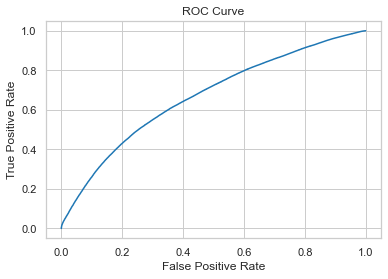

ROC AUC Score: 0.6665569418059409


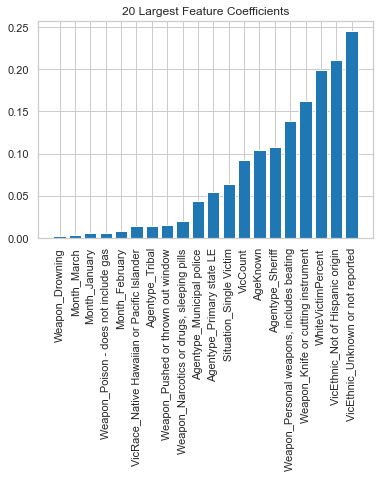

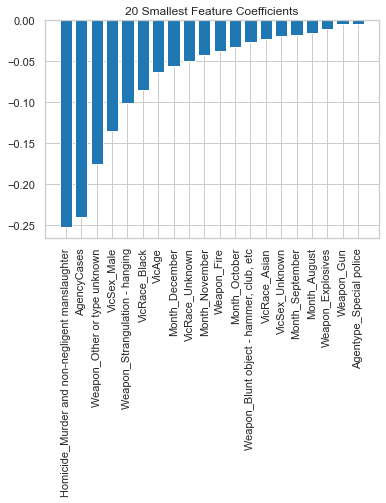

<ipython-input-7-ec92d65e6692>:64: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  chart_df = proba_df.groupby('Bin')['Solved', 'Predicted Probability'].mean()


     Bin    Actual  Predicted  Count
0   0.05  0.153846   0.045526     13
1    0.1  0.226891   0.086735    119
2   0.15  0.333333   0.130118    387
3    0.2  0.409922   0.178258   1149
4   0.25  0.484032   0.227605   2411
5    0.3  0.482301   0.280463   6102
6   0.35  0.539073   0.326770  13091
7    0.4  0.574573   0.376361  18170
8   0.45  0.620663   0.426022  26172
9    0.5  0.666240   0.474207  29707
10  0.55  0.725606   0.524349  25467
11   0.6  0.781481   0.574256  21934
12  0.65  0.825540   0.624762  19804
13   0.7  0.849991   0.673758  15959
14  0.75  0.864294   0.723263  10088
15   0.8  0.864890   0.771525   5440
16  0.85  0.891370   0.821242   2329
17   0.9  0.937158   0.875517   1098
18  0.95  0.961353   0.925660   1449
19     1  0.958763   0.959300    291


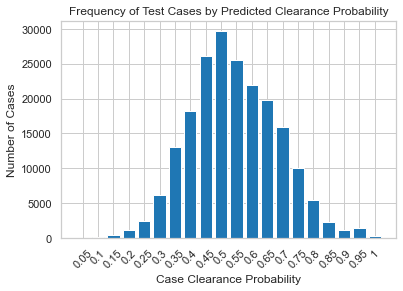

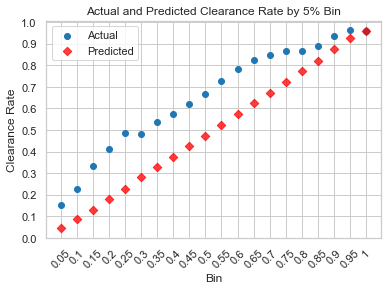

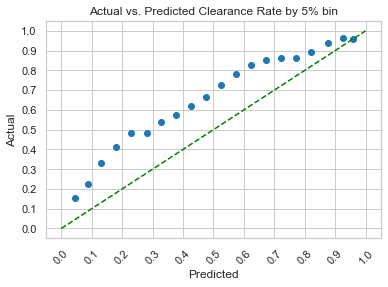

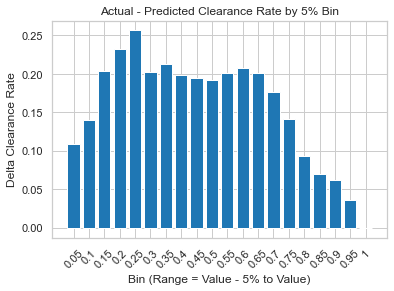

Sum of Squared Binned Residuals: 5853.721949195299
Reporting Time: 1.9 seconds


<ipython-input-3-96a6dbac1e69>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bin_df = df.groupby('Bin')['Actual', 'Predicted Probability'].mean()


In [99]:
model  = LogisticRegression(n_jobs = 6, 
                            random_state = 33,
                            fit_intercept = True,
                            penalty = 'l2',
                            C = .001)

train(model, X_train_balanced, y_train_balanced)
y_pred, y_pred_prob = predict(model, X_test)
proba_df, chart_df = reports(model, X_train.columns, y_test, y_pred, y_pred_prob)

In [100]:
model  = LogisticRegression(n_jobs = 6, 
                            random_state = 33,
                            class_weight = 'balanced')

grid = [{'fit_intercept' : [True, False],
         'penalty' : ['l2', 'none']}]

grid_results = grid_search(grid, model, X_train, y_train)
grid_results

Fitting 5 folds for each of 4 candidates, totalling 20 fits


BSSR Rank    BSSR Mean  \
{'fit_intercept': True, 'penalty': 'l2'}             2 -6313.951167   
{'fit_intercept': True, 'penalty': 'none'}           1 -6313.924874   
{'fit_intercept': False, 'penalty': 'l2'}            4 -7351.833155   
{'fit_intercept': False, 'penalty': 'none'}          3 -7351.665207   

                                               BSSR Std  ROC_AUC Rank  \
{'fit_intercept': True, 'penalty': 'l2'}     305.504046             2   
{'fit_intercept': True, 'penalty': 'none'}   305.488564             1   
{'fit_intercept': False, 'penalty': 'l2'}    437.282456             4   
{'fit_intercept': False, 'penalty': 'none'}  437.150785             3   

                                             ROC_AUC Mean  ROC_AUC Std  \
{'fit_intercept': True, 'penalty': 'l2'}         0.665038     0.001471   
{'fit_intercept': True, 'penalty': 'none'}       0.665039     0.001471   
{'fit_intercept': False, 'penalty': 'l2'}        0.665034     0.001470   
{'fit_intercept': False, 'penalty': 'none'}      0.665034     0.001470   

                                             Precision Rank  Precision Mean  \
{'fit_intercept': True, 'penalty': 'l2'}                  3        0.685765   
{'fit_intercept': True, 'penalty': 'none'}                4        0.685755   
{'fit_intercept': False, 'penalty': 'l2'}                 1        0.690588   
{'fit_intercept': False, 'penalty': 'none'}               2        0.690586   

                                             Precision Std  Recall Rank  \
{'fit_intercept': True, 'penalty': 'l2'}          0.000997            1   
{'fit_intercept': True, 'penalty': 'none'}        0.000984            2   
{'fit_intercept': False, 'penalty': 'l2'}         0.001326            3   
{'fit_intercept': False, 'penalty': 'none'}       0.001324            4   

                                             Recall Mean  Recall Std  \
{'fit_intercept': True, 'penalty': 'l2'}        0.608691    0.000892   
{'fit_intercept': True, 'penalty': 'none'}      0.608681    0.000881   
{'fit_intercept': False, 'penalty': 'l2'}       0.587371    0.001054   
{'fit_intercept': False, 'penalty': 'none'}     0.587368    0.001051   

                                             Accuracy Rank  Accuracy Mean  \
{'fit_intercept': True, 'penalty': 'l2'}                 1       0.608691   
{'fit_intercept': True, 'penalty': 'none'}               2       0.608681   
{'fit_intercept': False, 'penalty': 'l2'}                3       0.587371   
{'fit_intercept': False, 'penalty': 'none'}              4       0.587368   

                                             Accuracy Std  F1 Rank   F1 Mean  \
{'fit_intercept': True, 'penalty': 'l2'}         0.000892        1  0.626029   
{'fit_intercept': True, 'penalty': 'none'}       0.000881        2  0.626020   
{'fit_intercept': False, 'penalty': 'l2'}        0.001054        3  0.604824   
{'fit_intercept': False, 'penalty': 'none'}      0.001051        4  0.604821   

                                               F1 Std  Proba30 Rank  \
{'fit_intercept': True, 'penalty': 'l2'}     0.000850             4   
{'fit_intercept': True, 'penalty': 'none'}   0.000840             3   
{'fit_intercept': False, 'penalty': 'l2'}    0.001011             2   
{'fit_intercept': False, 'penalty': 'none'}  0.001008             1   

                                             Proba30 Mean  Proba30 Std  
{'fit_intercept': True, 'penalty': 'l2'}         0.013494     0.000125  
{'fit_intercept': True, 'penalty': 'none'}       0.013495     0.000123  
{'fit_intercept': False, 'penalty': 'l2'}        0.017934     0.000168  
{'fit_intercept': False, 'penalty': 'none'}      0.017935     0.000167

In [101]:
model  = LogisticRegression(n_jobs = 6, 
                            random_state = 33,
                            class_weight = 'balanced',
                            fit_intercept = True,
                            penalty = 'l2')

grid = [{'C' : np.logspace(-6, 3, 10)}]

grid_results = grid_search(grid, model, X_train, y_train)
grid_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits


BSSR Rank    BSSR Mean    BSSR Std  ROC_AUC Rank  ROC_AUC Mean  \
{'C': 1e-06}           1 -4163.812564  583.251643            10      0.644281   
{'C': 1e-05}           2 -4291.990589  148.132414             9      0.657066   
{'C': 0.0001}          3 -5542.894223  247.364959             8      0.663767   
{'C': 0.001}           4 -6264.915423  365.940165             7      0.664937   
{'C': 0.01}            5 -6304.648477  308.304453             6      0.665031   
{'C': 0.1}             6 -6311.238202  305.745729             5      0.665038   
{'C': 1.0}            10 -6313.951167  305.504046             4      0.665038   
{'C': 10.0}            7 -6313.922086  305.487976             3      0.665039   
{'C': 100.0}           8 -6313.924595  305.488505             2      0.665039   
{'C': 1000.0}          9 -6313.924846  305.488558             1      0.665039   

               ROC_AUC Std  Precision Rank  Precision Mean  Precision Std  \
{'C': 1e-06}      0.001804              10        0.669442       0.001300   
{'C': 1e-05}      0.001653               9        0.678199       0.001659   
{'C': 0.0001}     0.001526               8        0.683428       0.001271   
{'C': 0.001}      0.001482               7        0.685574       0.001071   
{'C': 0.01}       0.001471               6        0.685748       0.000991   
{'C': 0.1}        0.001471               2        0.685762       0.000985   
{'C': 1.0}        0.001471               1        0.685765       0.000997   
{'C': 10.0}       0.001471               3        0.685755       0.000984   
{'C': 100.0}      0.001471               3        0.685755       0.000984   
{'C': 1000.0}     0.001471               3        0.685755       0.000984   

               Recall Rank  Recall Mean  Recall Std  Accuracy Rank  \
{'C': 1e-06}            10     0.587164    0.001179             10   
{'C': 1e-05}             9     0.600890    0.001786              9   
{'C': 0.0001}            8     0.607543    0.001117              8   
{'C': 0.001}             7     0.608664    0.000946              7   
{'C': 0.01}              1     0.608696    0.000911              1   
{'C': 0.1}               3     0.608687    0.000895              3   
{'C': 1.0}               2     0.608691    0.000892              2   
{'C': 10.0}              4     0.608681    0.000881              4   
{'C': 100.0}             4     0.608681    0.000881              4   
{'C': 1000.0}            4     0.608681    0.000881              4   

               Accuracy Mean  Accuracy Std  F1 Rank   F1 Mean    F1 Std  \
{'C': 1e-06}        0.587164      0.001179       10  0.605465  0.001127   
{'C': 1e-05}        0.600890      0.001786        9  0.618576  0.001705   
{'C': 0.0001}       0.607543      0.001117        8  0.624917  0.001069   
{'C': 0.001}        0.608664      0.000946        7  0.626002  0.000903   
{'C': 0.01}         0.608696      0.000911        1  0.626034  0.000868   
{'C': 0.1}          0.608687      0.000895        3  0.626026  0.000854   
{'C': 1.0}          0.608691      0.000892        2  0.626029  0.000850   
{'C': 10.0}         0.608681      0.000881        4  0.626020  0.000840   
{'C': 100.0}        0.608681      0.000881        4  0.626020  0.000840   
{'C': 1000.0}       0.608681      0.000881        4  0.626020  0.000840   

               Proba30 Rank  Proba30 Mean  Proba30 Std  
{'C': 1e-06}             10      0.000000     0.000000  
{'C': 1e-05}              9      0.001340     0.000050  
{'C': 0.0001}             8      0.009761     0.000134  
{'C': 0.001}              7      0.013028     0.000130  
{'C': 0.01}               6      0.013444     0.000132  
{'C': 0.1}                5      0.013489     0.000130  
{'C': 1.0}                4      0.013494     0.000125  
{'C': 10.0}               1      0.013495     0.000123  
{'C': 100.0}              2      0.013495     0.000123  
{'C': 1000.0}             3      0.013495     0.000123

Training Time: 20.2 seconds
Prediction Time: 0.0 seconds
Confusion Matrix:
 [[39060 20113]
 [58294 83713]]
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.66      0.50     59173
           1       0.81      0.59      0.68    142007

    accuracy                           0.61    201180
   macro avg       0.60      0.62      0.59    201180
weighted avg       0.69      0.61      0.63    201180

Accuracy: 61.03 %
Log Loss: 0.6506834599361752
Brier Score Loss: 0.22982377245116184


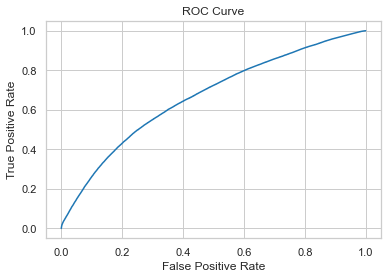

ROC AUC Score: 0.666883241039207


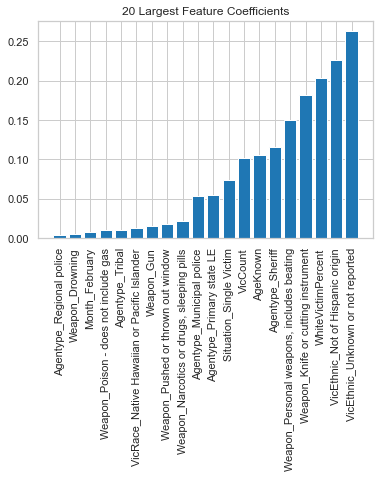

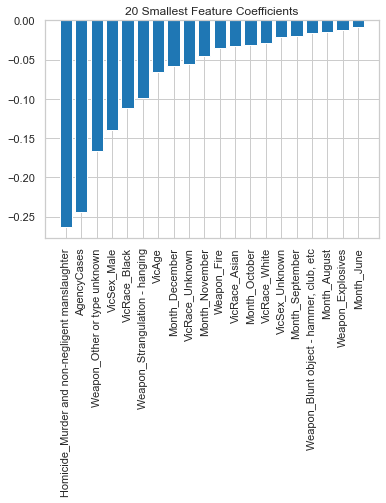

<ipython-input-7-ec92d65e6692>:64: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  chart_df = proba_df.groupby('Bin')['Solved', 'Predicted Probability'].mean()


     Bin    Actual  Predicted  Count
0   0.05  0.142857   0.043445     14
1    0.1  0.260870   0.084702    138
2   0.15  0.329466   0.130607    431
3    0.2  0.421138   0.178327   1230
4   0.25  0.484762   0.226644   2461
5    0.3  0.487121   0.280228   6522
6   0.35  0.540744   0.326324  13180
7    0.4  0.574626   0.376502  18137
8   0.45  0.621952   0.426071  26002
9    0.5  0.667088   0.474099  29239
10  0.55  0.723545   0.524218  25024
11   0.6  0.782018   0.574349  21722
12  0.65  0.824783   0.624833  19570
13   0.7  0.848874   0.673589  16033
14  0.75  0.863825   0.723377  10369
15   0.8  0.862717   0.771735   5638
16  0.85  0.890214   0.820961   2432
17   0.9  0.933393   0.875378   1111
18  0.95  0.956954   0.926708   1510
19     1  0.961631   0.959676    417


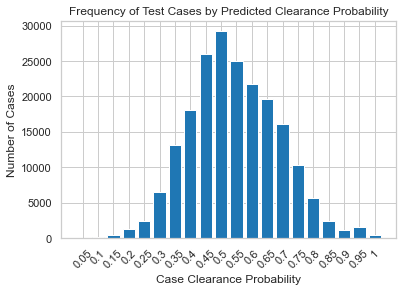

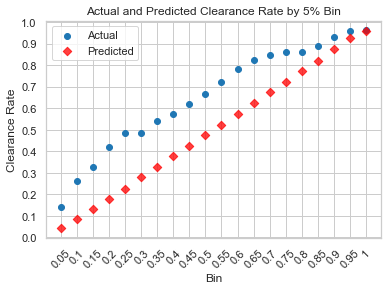

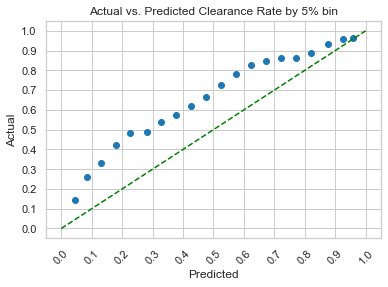

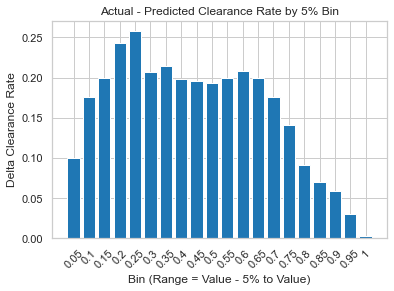

Sum of Squared Binned Residuals: 6003.402502105765
Reporting Time: 1.9 seconds


<ipython-input-3-96a6dbac1e69>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bin_df = df.groupby('Bin')['Actual', 'Predicted Probability'].mean()


In [103]:
model  = LogisticRegression(n_jobs = 6, 
                            random_state = 33,
                            class_weight = 'balanced',
                            fit_intercept = True,
                            penalty = 'l2',
                            C = 0.01)

train(model, X_train, y_train)
y_pred, y_pred_prob = predict(model, X_test)
proba_df, chart_df = reports(model, X_train.columns, y_test, y_pred, y_pred_prob)

In [104]:
model  = LogisticRegression(n_jobs = 6, 
                            random_state = 33)

grid = [{'fit_intercept' : [True, False],
         'penalty' : ['l2', 'none']}]

grid_results = grid_search(grid, model, X_train, y_train)
grid_results

Fitting 5 folds for each of 4 candidates, totalling 20 fits


BSSR Rank    BSSR Mean  \
{'fit_intercept': True, 'penalty': 'l2'}             1  -747.721155   
{'fit_intercept': True, 'penalty': 'none'}           2  -748.546455   
{'fit_intercept': False, 'penalty': 'l2'}            4 -6547.357096   
{'fit_intercept': False, 'penalty': 'none'}          3 -6546.772714   

                                               BSSR Std  ROC_AUC Rank  \
{'fit_intercept': True, 'penalty': 'l2'}     245.646701             2   
{'fit_intercept': True, 'penalty': 'none'}   246.515327             1   
{'fit_intercept': False, 'penalty': 'l2'}    242.047332             4   
{'fit_intercept': False, 'penalty': 'none'}  240.577285             3   

                                             ROC_AUC Mean  ROC_AUC Std  \
{'fit_intercept': True, 'penalty': 'l2'}         0.664977     0.001480   
{'fit_intercept': True, 'penalty': 'none'}       0.664977     0.001480   
{'fit_intercept': False, 'penalty': 'l2'}        0.664502     0.001468   
{'fit_intercept': False, 'penalty': 'none'}      0.664503     0.001468   

                                             Precision Rank  Precision Mean  \
{'fit_intercept': True, 'penalty': 'l2'}                  3        0.663742   
{'fit_intercept': True, 'penalty': 'none'}                3        0.663742   
{'fit_intercept': False, 'penalty': 'l2'}                 1        0.688460   
{'fit_intercept': False, 'penalty': 'none'}               1        0.688460   

                                             Precision Std  Recall Rank  \
{'fit_intercept': True, 'penalty': 'l2'}          0.001748            1   
{'fit_intercept': True, 'penalty': 'none'}        0.001748            1   
{'fit_intercept': False, 'penalty': 'l2'}         0.001274            3   
{'fit_intercept': False, 'penalty': 'none'}       0.001274            3   

                                             Recall Mean  Recall Std  \
{'fit_intercept': True, 'penalty': 'l2'}        0.709061    0.000483   
{'fit_intercept': True, 'penalty': 'none'}      0.709061    0.000483   
{'fit_intercept': False, 'penalty': 'l2'}       0.596589    0.001220   
{'fit_intercept': False, 'penalty': 'none'}     0.596589    0.001220   

                                             Accuracy Rank  Accuracy Mean  \
{'fit_intercept': True, 'penalty': 'l2'}                 1       0.709061   
{'fit_intercept': True, 'penalty': 'none'}               1       0.709061   
{'fit_intercept': False, 'penalty': 'l2'}                3       0.596589   
{'fit_intercept': False, 'penalty': 'none'}              3       0.596589   

                                             Accuracy Std  F1 Rank   F1 Mean  \
{'fit_intercept': True, 'penalty': 'l2'}         0.000483        1  0.624363   
{'fit_intercept': True, 'penalty': 'none'}       0.000483        1  0.624363   
{'fit_intercept': False, 'penalty': 'l2'}        0.001220        3  0.614254   
{'fit_intercept': False, 'penalty': 'none'}      0.001220        3  0.614254   

                                               F1 Std  Proba30 Rank  \
{'fit_intercept': True, 'penalty': 'l2'}     0.000611             4   
{'fit_intercept': True, 'penalty': 'none'}   0.000611             3   
{'fit_intercept': False, 'penalty': 'l2'}    0.001169             2   
{'fit_intercept': False, 'penalty': 'none'}  0.001169             1   

                                             Proba30 Mean  Proba30 Std  
{'fit_intercept': True, 'penalty': 'l2'}         0.000629     0.000039  
{'fit_intercept': True, 'penalty': 'none'}       0.000630     0.000038  
{'fit_intercept': False, 'penalty': 'l2'}        0.009569     0.000148  
{'fit_intercept': False, 'penalty': 'none'}      0.009570     0.000148

In [107]:
model  = LogisticRegression(n_jobs = 6, 
                            random_state = 33,
                            fit_intercept = True,
                            penalty = 'l2')

grid = [{'C' : np.logspace(-6, 3, 10)}]

grid_results = grid_search(grid, model, X_train, y_train)
grid_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits


BSSR Rank    BSSR Mean    BSSR Std  ROC_AUC Rank  ROC_AUC Mean  \
{'C': 1e-06}           9 -1725.666687  212.633664            10      0.643593   
{'C': 1e-05}          10 -1746.039855  325.320960             9      0.656011   
{'C': 0.0001}          1  -555.334236  182.572948             8      0.663371   
{'C': 0.001}           2  -695.699674  246.247100             7      0.664837   
{'C': 0.01}            3  -739.950412  245.999315             6      0.664965   
{'C': 0.1}             4  -745.061796  243.148761             5      0.664976   
{'C': 1.0}             5  -747.721155  245.646701             4      0.664977   
{'C': 10.0}            6  -748.543562  246.516415             3      0.664977   
{'C': 100.0}           7  -748.546306  246.515255             2      0.664977   
{'C': 1000.0}          8  -748.546413  246.515319             1      0.664977   

               ROC_AUC Std  Precision Rank  Precision Mean  Precision Std  \
{'C': 1e-06}      0.001807              10        0.498252       0.000004   
{'C': 1e-05}      0.001662               1        0.697202       0.007291   
{'C': 0.0001}     0.001543               2        0.666131       0.002132   
{'C': 0.001}      0.001493               3        0.664618       0.001819   
{'C': 0.01}       0.001482               4        0.663791       0.001671   
{'C': 0.1}        0.001480               5        0.663749       0.001760   
{'C': 1.0}        0.001480               6        0.663742       0.001748   
{'C': 10.0}       0.001480               6        0.663742       0.001748   
{'C': 100.0}      0.001480               6        0.663742       0.001748   
{'C': 1000.0}     0.001480               6        0.663742       0.001748   

               Recall Rank  Recall Mean  Recall Std  Accuracy Rank  \
{'C': 1e-06}            10     0.705869    0.000003             10   
{'C': 1e-05}             9     0.707122    0.000178              9   
{'C': 0.0001}            2     0.709112    0.000437              2   
{'C': 0.001}             1     0.709253    0.000479              1   
{'C': 0.01}              3     0.709071    0.000460              3   
{'C': 0.1}               4     0.709062    0.000486              4   
{'C': 1.0}               5     0.709061    0.000483              5   
{'C': 10.0}              5     0.709061    0.000483              5   
{'C': 100.0}             5     0.709061    0.000483              5   
{'C': 1000.0}            5     0.709061    0.000483              5   

               Accuracy Mean  Accuracy Std  F1 Rank   F1 Mean    F1 Std  \
{'C': 1e-06}        0.705869      0.000003       10  0.584161  0.000004   
{'C': 1e-05}        0.707122      0.000178        9  0.589240  0.000289   
{'C': 0.0001}       0.709112      0.000437        8  0.615150  0.000722   
{'C': 0.001}        0.709253      0.000479        7  0.623278  0.000595   
{'C': 0.01}         0.709071      0.000460        6  0.624234  0.000610   
{'C': 0.1}          0.709062      0.000486        5  0.624360  0.000610   
{'C': 1.0}          0.709061      0.000483        1  0.624363  0.000611   
{'C': 10.0}         0.709061      0.000483        1  0.624363  0.000611   
{'C': 100.0}        0.709061      0.000483        1  0.624363  0.000611   
{'C': 1000.0}       0.709061      0.000483        1  0.624363  0.000611   

               Proba30 Rank  Proba30 Mean  Proba30 Std  
{'C': 1e-06}             10      0.000000     0.000000  
{'C': 1e-05}              9      0.000011     0.000006  
{'C': 0.0001}             8      0.000337     0.000019  
{'C': 0.001}              7      0.000599     0.000039  
{'C': 0.01}               6      0.000628     0.000037  
{'C': 0.1}                4      0.000629     0.000039  
{'C': 1.0}                5      0.000629     0.000039  
{'C': 10.0}               1      0.000630     0.000038  
{'C': 100.0}              2      0.000630     0.000038  
{'C': 1000.0}             3      0.000630     0.000038

Training Time: 18.7 seconds
Prediction Time: 0.0 seconds
Confusion Matrix:
 [[  4780  54393]
 [  4040 137967]]
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.08      0.14     59173
           1       0.72      0.97      0.83    142007

    accuracy                           0.71    201180
   macro avg       0.63      0.53      0.48    201180
weighted avg       0.67      0.71      0.62    201180

Accuracy: 70.95 %
Log Loss: 0.5703240910866411
Brier Score Loss: 0.19330455579084987


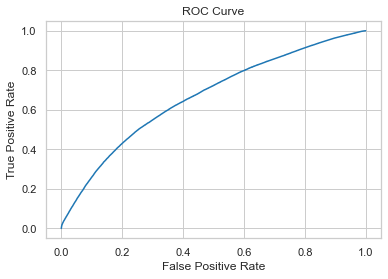

ROC AUC Score: 0.6666901335988402


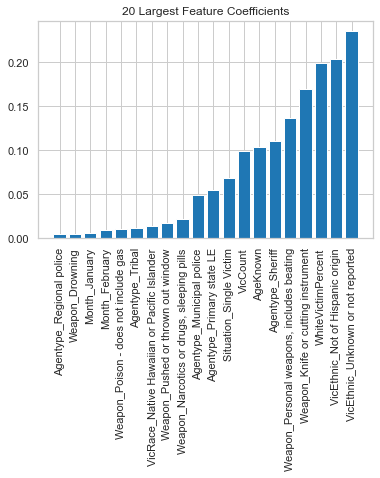

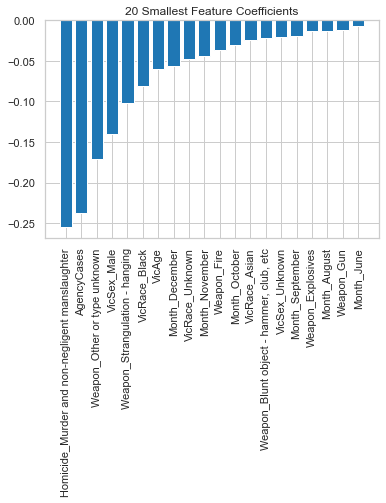

<ipython-input-7-ec92d65e6692>:64: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  chart_df = proba_df.groupby('Bin')['Solved', 'Predicted Probability'].mean()


     Bin    Actual  Predicted  Count
0   0.05       NaN        NaN      0
1    0.1  0.000000   0.094799      5
2   0.15  0.214286   0.120891     14
3    0.2  0.162162   0.180250     74
4   0.25  0.369128   0.225174    149
5    0.3  0.307692   0.280049    273
6   0.35  0.382876   0.328258    619
7    0.4  0.446541   0.377665   1113
8   0.45  0.496164   0.426807   1955
9    0.5  0.472499   0.479821   4618
10  0.55  0.530576   0.526816  10564
11   0.6  0.567951   0.575585  15732
12  0.65  0.600653   0.626387  25106
13   0.7  0.660269   0.674950  33865
14  0.75  0.725702   0.724673  31495
15   0.8  0.796157   0.774724  29248
16  0.85  0.845143   0.823476  26024
17   0.9  0.862563   0.871475  14232
18  0.95  0.893939   0.918847   4026
19     1  0.955513   0.967696   2068


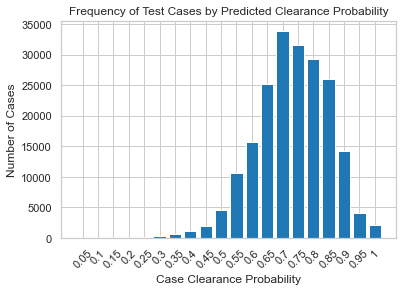

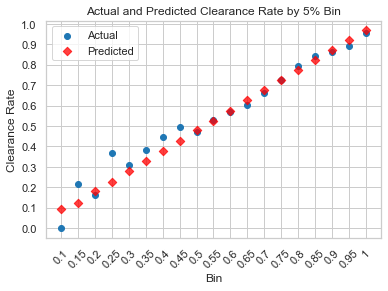

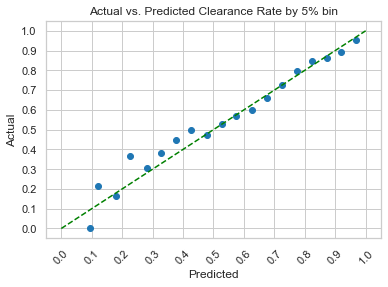

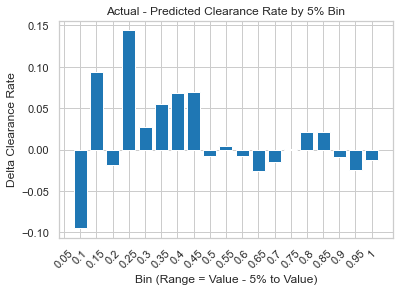

Sum of Squared Binned Residuals: 548.4271126188196
Reporting Time: 1.9 seconds


<ipython-input-3-96a6dbac1e69>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bin_df = df.groupby('Bin')['Actual', 'Predicted Probability'].mean()


In [108]:
model  = LogisticRegression(n_jobs = 6, 
                            random_state = 33,
                            fit_intercept = True,
                            penalty = 'l2',
                            C = .001)

train(model, X_train, y_train)
y_pred, y_pred_prob = predict(model, X_test)
proba_df, chart_df = reports(model, X_train.columns, y_test, y_pred, y_pred_prob)

Random Forest

In [110]:
model  = RandomForestClassifier(n_jobs = 10, 
                                random_state = 33)

grid = [{'max_depth' : [5, 10, 15, 20, 25]
        }]

grid_results = grid_search(grid, model, X_train_balanced, y_train_balanced)
grid_results

Fitting 5 folds for each of 5 candidates, totalling 25 fits


BSSR Rank    BSSR Mean    BSSR Std  ROC_AUC Rank  \
{'max_depth': 5}           5 -2963.226912  184.481400             5   
{'max_depth': 10}          4 -1489.112230  411.514854             4   
{'max_depth': 15}          3  -919.225305  806.180559             3   
{'max_depth': 20}          1  -107.593355   36.461189             1   
{'max_depth': 25}          2  -138.962063   43.423395             2   

                   ROC_AUC Mean  ROC_AUC Std  Precision Rank  Precision Mean  \
{'max_depth': 5}       0.675678     0.002087               5        0.625790   
{'max_depth': 10}      0.700100     0.001945               4        0.646746   
{'max_depth': 15}      0.713226     0.002021               3        0.657910   
{'max_depth': 20}      0.719705     0.002027               1        0.662003   
{'max_depth': 25}      0.715273     0.002113               2        0.659042   

                   Precision Std  Recall Rank  Recall Mean  Recall Std  \
{'max_depth': 5}        0.002532            5     0.624939    0.002867   
{'max_depth': 10}       0.001802            4     0.646159    0.001737   
{'max_depth': 15}       0.001452            3     0.657163    0.001444   
{'max_depth': 20}       0.001807            1     0.661281    0.001781   
{'max_depth': 25}       0.001493            2     0.658673    0.001491   

                   Accuracy Rank  Accuracy Mean  Accuracy Std  F1 Rank  \
{'max_depth': 5}               5       0.624939      0.002867        5   
{'max_depth': 10}              4       0.646159      0.001737        4   
{'max_depth': 15}              3       0.657163      0.001444        3   
{'max_depth': 20}              1       0.661281      0.001781        1   
{'max_depth': 25}              2       0.658673      0.001491        2   

                    F1 Mean    F1 Std  Proba30 Rank  Proba30 Mean  Proba30 Std  
{'max_depth': 5}   0.624295  0.003158             5      0.000042     0.000023  
{'max_depth': 10}  0.645805  0.001714             4      0.003960     0.000946  
{'max_depth': 15}  0.656758  0.001449             3      0.024737     0.000414  
{'max_depth': 20}  0.660904  0.001776             2      0.031542     0.000432  
{'max_depth': 25}  0.658475  0.001494             1      0.037437     0.000225

In [112]:
model  = RandomForestClassifier(n_jobs = 10, 
                                random_state = 33,
                                max_depth = 20)

grid = [{
         'n_estimators' : [50, 100, 250, 500, 1000]
        }]

grid_results = grid_search(grid, model, X_train_balanced, y_train_balanced)
grid_results

Fitting 5 folds for each of 5 candidates, totalling 25 fits


BSSR Rank   BSSR Mean   BSSR Std  ROC_AUC Rank  \
{'n_estimators': 50}            1  -96.049275  12.828720             5   
{'n_estimators': 100}           2 -107.593355  36.461189             4   
{'n_estimators': 250}           3 -119.460890  28.326311             3   
{'n_estimators': 500}           4 -120.229226  23.756834             2   
{'n_estimators': 1000}          5 -127.157879  22.869194             1   

                        ROC_AUC Mean  ROC_AUC Std  Precision Rank  \
{'n_estimators': 50}        0.718503     0.001774               5   
{'n_estimators': 100}       0.719705     0.002027               4   
{'n_estimators': 250}       0.720646     0.001916               3   
{'n_estimators': 500}       0.720889     0.002025               2   
{'n_estimators': 1000}      0.721028     0.002023               1   

                        Precision Mean  Precision Std  Recall Rank  \
{'n_estimators': 50}          0.661419       0.001848            5   
{'n_estimators': 100}         0.662003       0.001807            4   
{'n_estimators': 250}         0.662663       0.001747            3   
{'n_estimators': 500}         0.662894       0.001909            1   
{'n_estimators': 1000}        0.662903       0.001747            2   

                        Recall Mean  Recall Std  Accuracy Rank  Accuracy Mean  \
{'n_estimators': 50}       0.660701    0.001800              5       0.660701   
{'n_estimators': 100}      0.661281    0.001781              4       0.661281   
{'n_estimators': 250}      0.661997    0.001708              3       0.661997   
{'n_estimators': 500}      0.662228    0.001873              1       0.662228   
{'n_estimators': 1000}     0.662219    0.001707              2       0.662219   

                        Accuracy Std  F1 Rank   F1 Mean    F1 Std  \
{'n_estimators': 50}        0.001800        5  0.660324  0.001786   
{'n_estimators': 100}       0.001781        4  0.660904  0.001776   
{'n_estimators': 250}       0.001708        3  0.661650  0.001694   
{'n_estimators': 500}       0.001873        1  0.661882  0.001862   
{'n_estimators': 1000}      0.001707        2  0.661865  0.001693   

                        Proba30 Rank  Proba30 Mean  Proba30 Std  
{'n_estimators': 50}               1      0.031753     0.000543  
{'n_estimators': 100}              3      0.031542     0.000432  
{'n_estimators': 250}              2      0.031550     0.000222  
{'n_estimators': 500}              4      0.031538     0.000162  
{'n_estimators': 1000}             5      0.031449     0.000113

In [113]:
model  = RandomForestClassifier(n_jobs = 10, 
                                random_state = 33,
                                max_depth = 20,
                                n_estimators = 50)

grid = [{
         'min_samples_leaf' : [1, 2, 4, 7, 10]
        }]

grid_results = grid_search(grid, model, X_train_balanced, y_train_balanced)
grid_results

Fitting 5 folds for each of 5 candidates, totalling 25 fits


BSSR Rank   BSSR Mean   BSSR Std  ROC_AUC Rank  \
{'min_samples_leaf': 1}           1  -96.049275  12.828720             2   
{'min_samples_leaf': 2}           2 -144.498641  22.136853             1   
{'min_samples_leaf': 4}           3 -204.320998  24.911395             3   
{'min_samples_leaf': 7}           4 -286.719314  47.304293             4   
{'min_samples_leaf': 10}          5 -323.303536  36.102615             5   

                          ROC_AUC Mean  ROC_AUC Std  Precision Rank  \
{'min_samples_leaf': 1}       0.718503     0.001774               1   
{'min_samples_leaf': 2}       0.718744     0.001866               2   
{'min_samples_leaf': 4}       0.717864     0.002174               3   
{'min_samples_leaf': 7}       0.717431     0.002110               4   
{'min_samples_leaf': 10}      0.716505     0.002212               5   

                          Precision Mean  Precision Std  Recall Rank  \
{'min_samples_leaf': 1}         0.661419       0.001848            1   
{'min_samples_leaf': 2}         0.661131       0.001943            2   
{'min_samples_leaf': 4}         0.660720       0.001787            3   
{'min_samples_leaf': 7}         0.659466       0.001657            4   
{'min_samples_leaf': 10}        0.659287       0.002455            5   

                          Recall Mean  Recall Std  Accuracy Rank  \
{'min_samples_leaf': 1}      0.660701    0.001800              1   
{'min_samples_leaf': 2}      0.660419    0.001890              2   
{'min_samples_leaf': 4}      0.660034    0.001782              3   
{'min_samples_leaf': 7}      0.658851    0.001635              4   
{'min_samples_leaf': 10}     0.658679    0.002455              5   

                          Accuracy Mean  Accuracy Std  F1 Rank   F1 Mean  \
{'min_samples_leaf': 1}        0.660701      0.001800        1  0.660324   
{'min_samples_leaf': 2}        0.660419      0.001890        2  0.660045   
{'min_samples_leaf': 4}        0.660034      0.001782        3  0.659670   
{'min_samples_leaf': 7}        0.658851      0.001635        4  0.658521   
{'min_samples_leaf': 10}       0.658679      0.002455        5  0.658352   

                            F1 Std  Proba30 Rank  Proba30 Mean  Proba30 Std  
{'min_samples_leaf': 1}   0.001786             1      0.031753     0.000543  
{'min_samples_leaf': 2}   0.001869             2      0.030921     0.000465  
{'min_samples_leaf': 4}   0.001786             3      0.030162     0.000629  
{'min_samples_leaf': 7}   0.001629             4      0.028842     0.000575  
{'min_samples_leaf': 10}  0.002463             5      0.028617     0.000414

Training Time: 4.6 seconds
Prediction Time: 0.6 seconds
Confusion Matrix:
 [[41399 17774]
 [52766 89241]]
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.70      0.54     59173
           1       0.83      0.63      0.72    142007

    accuracy                           0.65    201180
   macro avg       0.64      0.66      0.63    201180
weighted avg       0.72      0.65      0.66    201180

Accuracy: 64.94 %
Log Loss: 0.615930928675797
Brier Score Loss: 0.21435141464136656


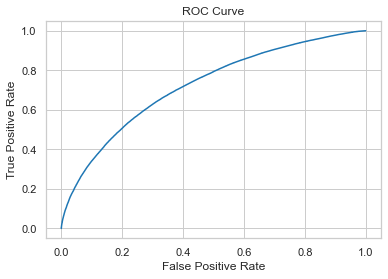

ROC AUC Score: 0.722499833458194


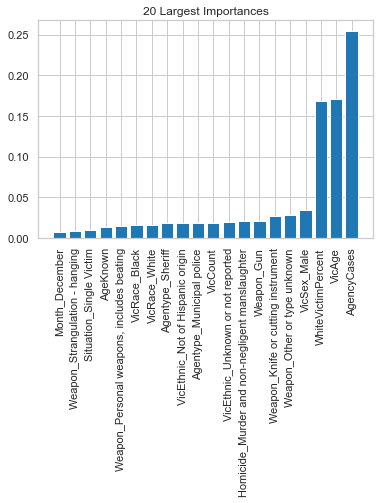

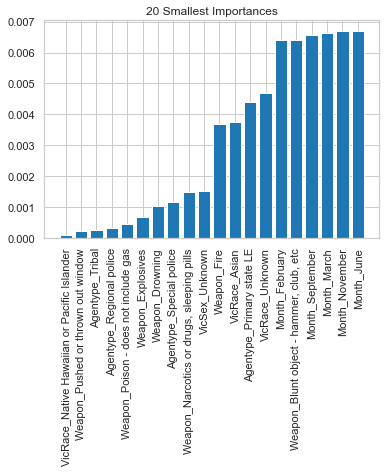

     Bin    Actual  Predicted  Count
0   0.05  0.034965   0.023910    143
1    0.1  0.129310   0.077665    232
2   0.15  0.251603   0.131506    624
3    0.2  0.318146   0.177259   2524
4   0.25  0.396724   0.229882   5800
5    0.3  0.439586   0.273505  11115
6   0.35  0.491731   0.326739  12275
7    0.4  0.564742   0.377669  20744
8   0.45  0.639895   0.424789  22449
9    0.5  0.682916   0.473732  18257
10  0.55  0.736220   0.525242  17526
11   0.6  0.778559   0.575307  18488
12  0.65  0.812489   0.623862  17807
13   0.7  0.847771   0.674736  15076
14  0.75  0.877545   0.724670  13948
15   0.8  0.909099   0.772805  11210
16  0.85  0.933554   0.822560   6652
17   0.9  0.951934   0.872665   3620
18  0.95  0.970392   0.921821   2094
19     1  0.969697   0.963840    594


<ipython-input-7-ec92d65e6692>:64: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  chart_df = proba_df.groupby('Bin')['Solved', 'Predicted Probability'].mean()


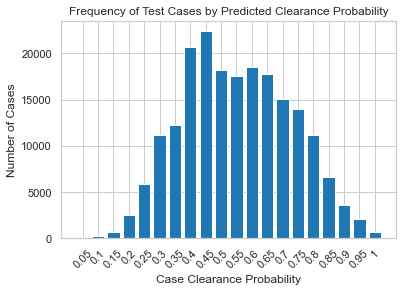

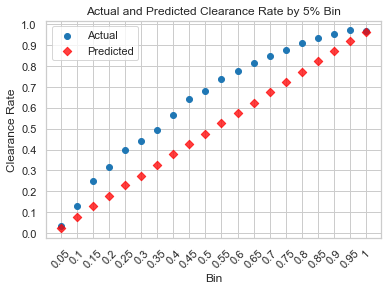

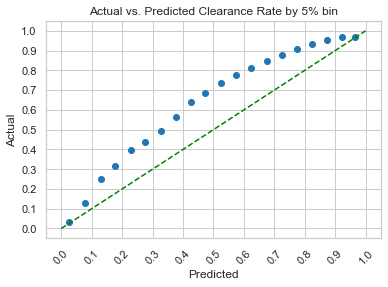

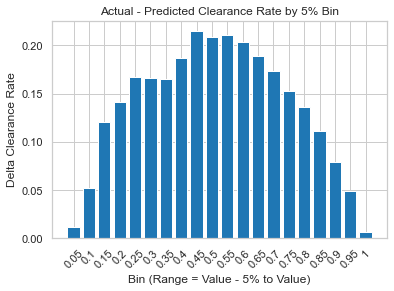

Sum of Squared Binned Residuals: 4590.162248236987
Reporting Time: 1.9 seconds


<ipython-input-3-96a6dbac1e69>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bin_df = df.groupby('Bin')['Actual', 'Predicted Probability'].mean()


In [114]:
model  = RandomForestClassifier(n_jobs = 10, 
                            random_state = 33,
                            max_depth = 20,
                            n_estimators = 50,
                            min_samples_leaf = 1)

train(model, X_train_balanced, y_train_balanced)
y_pred, y_pred_prob = predict(model, X_test)
proba_df, chart_df = reports(model, X_train.columns, y_test, y_pred, y_pred_prob)

In [115]:
model  = RandomForestClassifier(n_jobs = 10, 
                                random_state = 33,
                                class_weight = 'balanced')

grid = [{'max_depth' : [5, 10, 15, 20, 25]
        }]

grid_results = grid_search(grid, model, X_train, y_train)
grid_results

Fitting 5 folds for each of 5 candidates, totalling 25 fits


BSSR Rank    BSSR Mean    BSSR Std  ROC_AUC Rank  \
{'max_depth': 5}           5 -4793.500402  141.452980             5   
{'max_depth': 10}          4 -4217.004154  123.349485             4   
{'max_depth': 15}          3 -3800.889943   23.850717             3   
{'max_depth': 20}          2 -3434.604474   60.643412             1   
{'max_depth': 25}          1 -3290.982463  147.099367             2   

                   ROC_AUC Mean  ROC_AUC Std  Precision Rank  Precision Mean  \
{'max_depth': 5}       0.676477     0.002449               5        0.688434   
{'max_depth': 10}      0.700304     0.001967               4        0.703715   
{'max_depth': 15}      0.713229     0.001638               2        0.710956   
{'max_depth': 20}      0.719387     0.001827               1        0.711926   
{'max_depth': 25}      0.716062     0.001725               3        0.705979   

                   Precision Std  Recall Rank  Recall Mean  Recall Std  \
{'max_depth': 5}        0.001036            5     0.615708    0.003678   
{'max_depth': 10}       0.001216            4     0.630852    0.003239   
{'max_depth': 15}       0.001409            3     0.647954    0.001582   
{'max_depth': 20}       0.001517            2     0.665474    0.001315   
{'max_depth': 25}       0.000953            1     0.682552    0.001464   

                   Accuracy Rank  Accuracy Mean  Accuracy Std  F1 Rank  \
{'max_depth': 5}               5       0.615708      0.003678        5   
{'max_depth': 10}              4       0.630852      0.003239        4   
{'max_depth': 15}              3       0.647954      0.001582        3   
{'max_depth': 20}              2       0.665474      0.001315        2   
{'max_depth': 25}              1       0.682552      0.001464        1   

                    F1 Mean    F1 Std  Proba30 Rank  Proba30 Mean  Proba30 Std  
{'max_depth': 5}   0.632648  0.003446             5      0.000047     0.000007  
{'max_depth': 10}  0.647140  0.003051             4      0.002007     0.000839  
{'max_depth': 15}  0.663144  0.001494             3      0.017913     0.000880  
{'max_depth': 20}  0.678594  0.001283             2      0.020750     0.000314  
{'max_depth': 25}  0.691098  0.001256             1      0.021882     0.000282

In [116]:
model  = RandomForestClassifier(n_jobs = 10, 
                                random_state = 33,
                                class_weight = 'balanced',
                                max_depth = 20)

grid = [{
         'n_estimators' : [50, 100, 250, 500, 1000]
        }]

grid_results = grid_search(grid, model, X_train, y_train)
grid_results

Fitting 5 folds for each of 5 candidates, totalling 25 fits


BSSR Rank    BSSR Mean   BSSR Std  ROC_AUC Rank  \
{'n_estimators': 50}            5 -3474.045817  62.587912             5   
{'n_estimators': 100}           4 -3434.604474  60.643412             4   
{'n_estimators': 250}           2 -3390.242575  60.028189             3   
{'n_estimators': 500}           3 -3391.828248  60.860259             1   
{'n_estimators': 1000}          1 -3389.988413  64.334730             2   

                        ROC_AUC Mean  ROC_AUC Std  Precision Rank  \
{'n_estimators': 50}        0.718172     0.001935               5   
{'n_estimators': 100}       0.719387     0.001827               4   
{'n_estimators': 250}       0.720014     0.001877               3   
{'n_estimators': 500}       0.720145     0.001827               1   
{'n_estimators': 1000}      0.720143     0.001850               2   

                        Precision Mean  Precision Std  Recall Rank  \
{'n_estimators': 50}          0.711199       0.001635            5   
{'n_estimators': 100}         0.711926       0.001517            4   
{'n_estimators': 250}         0.712184       0.001637            3   
{'n_estimators': 500}         0.712576       0.001501            1   
{'n_estimators': 1000}        0.712306       0.001537            2   

                        Recall Mean  Recall Std  Accuracy Rank  Accuracy Mean  \
{'n_estimators': 50}       0.664508    0.001512              5       0.664508   
{'n_estimators': 100}      0.665474    0.001315              4       0.665474   
{'n_estimators': 250}      0.666028    0.001856              3       0.666028   
{'n_estimators': 500}      0.666513    0.001742              1       0.666513   
{'n_estimators': 1000}     0.666091    0.001770              2       0.666091   

                        Accuracy Std  F1 Rank   F1 Mean    F1 Std  \
{'n_estimators': 50}        0.001512        5  0.677689  0.001465   
{'n_estimators': 100}       0.001315        4  0.678594  0.001283   
{'n_estimators': 250}       0.001856        3  0.679094  0.001755   
{'n_estimators': 500}       0.001742        1  0.679551  0.001645   
{'n_estimators': 1000}      0.001770        2  0.679162  0.001673   

                        Proba30 Rank  Proba30 Mean  Proba30 Std  
{'n_estimators': 50}               2      0.020664     0.000231  
{'n_estimators': 100}              1      0.020750     0.000314  
{'n_estimators': 250}              3      0.020520     0.000463  
{'n_estimators': 500}              4      0.020482     0.000449  
{'n_estimators': 1000}             5      0.020469     0.000401

In [117]:
model  = RandomForestClassifier(n_jobs = 10, 
                                random_state = 33,
                                class_weight = 'balanced',
                                max_depth = 20,
                                n_estimators = 500)

grid = [{
         'min_samples_leaf' : [1, 2, 4, 7, 10]
        }]

grid_results = grid_search(grid, model, X_train, y_train)
grid_results

Fitting 5 folds for each of 5 candidates, totalling 25 fits


BSSR Rank    BSSR Mean   BSSR Std  ROC_AUC Rank  \
{'min_samples_leaf': 1}           1 -3391.828248  60.860259             3   
{'min_samples_leaf': 2}           2 -3597.836497  51.673760             1   
{'min_samples_leaf': 4}           3 -3753.699398  37.356025             2   
{'min_samples_leaf': 7}           4 -3866.641254  65.295994             4   
{'min_samples_leaf': 10}          5 -3940.155704  85.424613             5   

                          ROC_AUC Mean  ROC_AUC Std  Precision Rank  \
{'min_samples_leaf': 1}       0.720145     0.001827               5   
{'min_samples_leaf': 2}       0.720955     0.001868               4   
{'min_samples_leaf': 4}       0.720684     0.001962               2   
{'min_samples_leaf': 7}       0.719979     0.001710               1   
{'min_samples_leaf': 10}      0.719412     0.001985               3   

                          Precision Mean  Precision Std  Recall Rank  \
{'min_samples_leaf': 1}         0.712576       0.001501            1   
{'min_samples_leaf': 2}         0.713609       0.001392            2   
{'min_samples_leaf': 4}         0.713828       0.001399            3   
{'min_samples_leaf': 7}         0.713950       0.001271            4   
{'min_samples_leaf': 10}        0.713760       0.001291            5   

                          Recall Mean  Recall Std  Accuracy Rank  \
{'min_samples_leaf': 1}      0.666513    0.001742              1   
{'min_samples_leaf': 2}      0.661663    0.001734              2   
{'min_samples_leaf': 4}      0.657982    0.001734              3   
{'min_samples_leaf': 7}      0.655477    0.001420              4   
{'min_samples_leaf': 10}     0.653584    0.002148              5   

                          Accuracy Mean  Accuracy Std  F1 Rank   F1 Mean  \
{'min_samples_leaf': 1}        0.666513      0.001742        1  0.679551   
{'min_samples_leaf': 2}        0.661663      0.001734        2  0.675500   
{'min_samples_leaf': 4}        0.657982      0.001734        3  0.672295   
{'min_samples_leaf': 7}        0.655477      0.001420        4  0.670083   
{'min_samples_leaf': 10}       0.653584      0.002148        5  0.668378   

                            F1 Std  Proba30 Rank  Proba30 Mean  Proba30 Std  
{'min_samples_leaf': 1}   0.001645             5      0.020482     0.000449  
{'min_samples_leaf': 2}   0.001623             4      0.020992     0.000446  
{'min_samples_leaf': 4}   0.001624             3      0.021298     0.000500  
{'min_samples_leaf': 7}   0.001338             1      0.021495     0.000546  
{'min_samples_leaf': 10}  0.002002             2      0.021468     0.000556

Training Time: 90.7 seconds
Prediction Time: 5.6 seconds
Confusion Matrix:
 [[38743 20430]
 [46599 95408]]
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.65      0.54     59173
           1       0.82      0.67      0.74    142007

    accuracy                           0.67    201180
   macro avg       0.64      0.66      0.64    201180
weighted avg       0.71      0.67      0.68    201180

Accuracy: 66.68 %
Log Loss: 0.598424054460421
Brier Score Loss: 0.20674973765214094


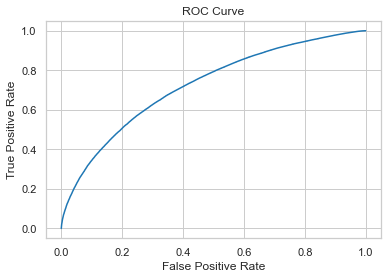

ROC AUC Score: 0.7233182408359715


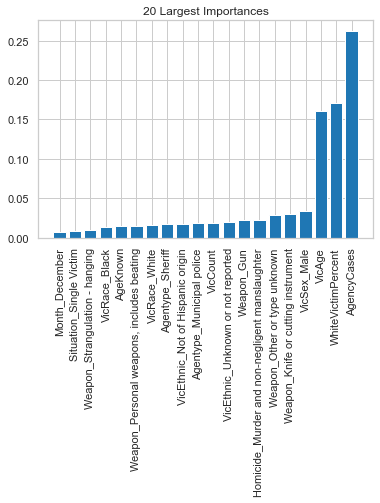

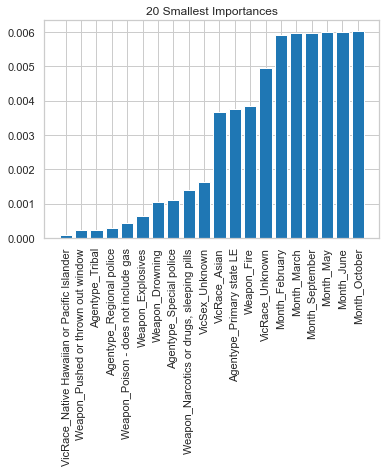

<ipython-input-7-ec92d65e6692>:64: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  chart_df = proba_df.groupby('Bin')['Solved', 'Predicted Probability'].mean()


     Bin    Actual  Predicted  Count
0   0.05  0.000000   0.025074     74
1    0.1  0.132743   0.075789    113
2   0.15  0.161826   0.127912    241
3    0.2  0.257680   0.177837   1595
4   0.25  0.369945   0.230378   4525
5    0.3  0.422930   0.273052  10231
6   0.35  0.461858   0.327019  11064
7    0.4  0.546841   0.377950  19086
8   0.45  0.623825   0.424487  22120
9    0.5  0.662063   0.474257  16293
10  0.55  0.713642   0.524471  16633
11   0.6  0.755788   0.575776  18615
12  0.65  0.791268   0.624180  18186
13   0.7  0.827238   0.674858  15831
14  0.75  0.863433   0.725240  16102
15   0.8  0.895493   0.772697  13578
16  0.85  0.923626   0.822703   7987
17   0.9  0.950340   0.872735   4410
18  0.95  0.966491   0.924327   3611
19     1  0.975141   0.961859    885


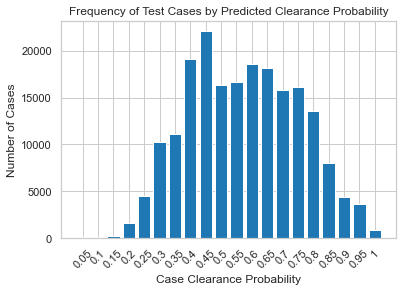

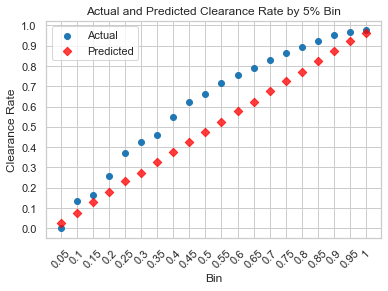

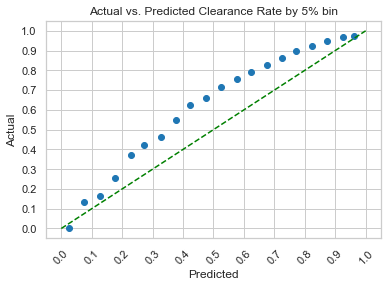

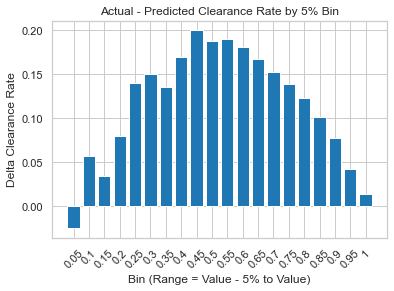

Sum of Squared Binned Residuals: 3467.1934592279267
Reporting Time: 2.7 seconds


<ipython-input-3-96a6dbac1e69>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bin_df = df.groupby('Bin')['Actual', 'Predicted Probability'].mean()


In [118]:
model  = RandomForestClassifier(n_jobs = 10, 
                            random_state = 33,
                            class_weight = 'balanced',
                            max_depth = 20,
                            n_estimators = 500,
                            min_samples_leaf = 1)

train(model, X_train, y_train)
y_pred, y_pred_prob = predict(model, X_test)
proba_df, chart_df = reports(model, X_train.columns, y_test, y_pred, y_pred_prob)

In [119]:
model  = RandomForestClassifier(n_jobs = 10, 
                                random_state = 33)

grid = [{'max_depth' : [5, 10, 15, 20, 25]
        }]

grid_results = grid_search(grid, model, X_train, y_train)
grid_results

Fitting 5 folds for each of 5 candidates, totalling 25 fits


BSSR Rank    BSSR Mean    BSSR Std  ROC_AUC Rank  \
{'max_depth': 5}           5 -4792.418422  441.269793             5   
{'max_depth': 10}          4 -2943.249382  338.884821             4   
{'max_depth': 15}          3  -941.721253  217.809467             3   
{'max_depth': 20}          1  -193.248934   91.528614             1   
{'max_depth': 25}          2  -306.520442  113.425666             2   

                   ROC_AUC Mean  ROC_AUC Std  Precision Rank  Precision Mean  \
{'max_depth': 5}       0.676319     0.002485               1        0.757645   
{'max_depth': 10}      0.700780     0.001812               2        0.715703   
{'max_depth': 15}      0.714930     0.001320               5        0.699079   
{'max_depth': 20}      0.722698     0.001900               3        0.700744   
{'max_depth': 25}      0.719319     0.001716               4        0.700025   

                   Precision Std  Recall Rank  Recall Mean  Recall Std  \
{'max_depth': 5}        0.011637            5     0.706255    0.000079   
{'max_depth': 10}       0.003552            4     0.711047    0.000356   
{'max_depth': 15}       0.001688            3     0.723315    0.000782   
{'max_depth': 20}       0.000959            2     0.726879    0.000500   
{'max_depth': 25}       0.001175            1     0.727348    0.000761   

                   Accuracy Rank  Accuracy Mean  Accuracy Std  F1 Rank  \
{'max_depth': 5}               5       0.706255      0.000079        5   
{'max_depth': 10}              4       0.711047      0.000356        4   
{'max_depth': 15}              3       0.723315      0.000782        3   
{'max_depth': 20}              2       0.726879      0.000500        2   
{'max_depth': 25}              1       0.727348      0.000761        1   

                    F1 Mean    F1 Std  Proba30 Rank  Proba30 Mean  Proba30 Std  
{'max_depth': 5}   0.585181  0.000212             5      0.000000     0.000000  
{'max_depth': 10}  0.601453  0.000896             4      0.000123     0.000023  
{'max_depth': 15}  0.657953  0.003115             3      0.000382     0.000023  
{'max_depth': 20}  0.675634  0.000933             2      0.001448     0.000133  
{'max_depth': 25}  0.687724  0.000826             1      0.004142     0.000191

In [120]:
model  = RandomForestClassifier(n_jobs = 10, 
                                random_state = 33)

grid = [{'max_depth' : [15, 20, 25, 30, 35]
        }]

grid_results = grid_search(grid, model, X_train, y_train)
grid_results

Fitting 5 folds for each of 5 candidates, totalling 25 fits


BSSR Rank    BSSR Mean    BSSR Std  ROC_AUC Rank  \
{'max_depth': 15}          3  -941.721253  217.809467             3   
{'max_depth': 20}          1  -193.248934   91.528614             1   
{'max_depth': 25}          2  -306.520442  113.425666             2   
{'max_depth': 30}          4 -1840.539343  269.638549             4   
{'max_depth': 35}          5 -4277.534604  311.179999             5   

                   ROC_AUC Mean  ROC_AUC Std  Precision Rank  Precision Mean  \
{'max_depth': 15}      0.714930     0.001320               3        0.699079   
{'max_depth': 20}      0.722698     0.001900               1        0.700744   
{'max_depth': 25}      0.719319     0.001716               2        0.700025   
{'max_depth': 30}      0.705017     0.001580               4        0.693457   
{'max_depth': 35}      0.688579     0.001387               5        0.685884   

                   Precision Std  Recall Rank  Recall Mean  Recall Std  \
{'max_depth': 15}       0.001688            3     0.723315    0.000782   
{'max_depth': 20}       0.000959            2     0.726879    0.000500   
{'max_depth': 25}       0.001175            1     0.727348    0.000761   
{'max_depth': 30}       0.001680            4     0.720937    0.001385   
{'max_depth': 35}       0.001157            5     0.710910    0.001082   

                   Accuracy Rank  Accuracy Mean  Accuracy Std  F1 Rank  \
{'max_depth': 15}              3       0.723315      0.000782        5   
{'max_depth': 20}              2       0.726879      0.000500        4   
{'max_depth': 25}              1       0.727348      0.000761        3   
{'max_depth': 30}              4       0.720937      0.001385        1   
{'max_depth': 35}              5       0.710910      0.001082        2   

                    F1 Mean    F1 Std  Proba30 Rank  Proba30 Mean  Proba30 Std  
{'max_depth': 15}  0.657953  0.003115             5      0.000382     0.000023  
{'max_depth': 20}  0.675634  0.000933             4      0.001448     0.000133  
{'max_depth': 25}  0.687724  0.000826             3      0.004142     0.000191  
{'max_depth': 30}  0.692491  0.001189             2      0.007723     0.000308  
{'max_depth': 35}  0.690256  0.000977             1      0.011816     0.000192

In [121]:
model  = RandomForestClassifier(n_jobs = 10, 
                                random_state = 33,
                                max_depth = 25)

grid = [{
         'n_estimators' : [50, 100, 250, 500, 1000]
        }]

grid_results = grid_search(grid, model, X_train, y_train)
grid_results

Fitting 5 folds for each of 5 candidates, totalling 25 fits


BSSR Rank   BSSR Mean    BSSR Std  ROC_AUC Rank  \
{'n_estimators': 50}            5 -383.226500  112.926019             5   
{'n_estimators': 100}           4 -306.520442  113.425666             4   
{'n_estimators': 250}           3 -287.656455   83.917526             3   
{'n_estimators': 500}           2 -269.512404   69.366274             2   
{'n_estimators': 1000}          1 -255.577176   73.622368             1   

                        ROC_AUC Mean  ROC_AUC Std  Precision Rank  \
{'n_estimators': 50}        0.717061     0.001681               5   
{'n_estimators': 100}       0.719319     0.001716               4   
{'n_estimators': 250}       0.720749     0.001624               2   
{'n_estimators': 500}       0.721196     0.001605               3   
{'n_estimators': 1000}      0.721351     0.001630               1   

                        Precision Mean  Precision Std  Recall Rank  \
{'n_estimators': 50}          0.698467       0.001409            5   
{'n_estimators': 100}         0.700025       0.001175            4   
{'n_estimators': 250}         0.700711       0.001496            2   
{'n_estimators': 500}         0.700542       0.001356            3   
{'n_estimators': 1000}        0.700790       0.001325            1   

                        Recall Mean  Recall Std  Accuracy Rank  Accuracy Mean  \
{'n_estimators': 50}       0.726342    0.000915              5       0.726342   
{'n_estimators': 100}      0.727348    0.000761              4       0.727348   
{'n_estimators': 250}      0.727788    0.000961              2       0.727788   
{'n_estimators': 500}      0.727681    0.000870              3       0.727681   
{'n_estimators': 1000}     0.727838    0.000846              1       0.727838   

                        Accuracy Std  F1 Rank   F1 Mean    F1 Std  \
{'n_estimators': 50}        0.000915        5  0.686881  0.001400   
{'n_estimators': 100}       0.000761        2  0.687724  0.000826   
{'n_estimators': 250}       0.000961        1  0.687941  0.001018   
{'n_estimators': 500}       0.000870        4  0.687653  0.000853   
{'n_estimators': 1000}      0.000846        3  0.687681  0.000836   

                        Proba30 Rank  Proba30 Mean  Proba30 Std  
{'n_estimators': 50}               1      0.004342     0.000176  
{'n_estimators': 100}              2      0.004142     0.000191  
{'n_estimators': 250}              3      0.004055     0.000172  
{'n_estimators': 500}              4      0.004005     0.000162  
{'n_estimators': 1000}             5      0.003985     0.000172

In [30]:
model  = RandomForestClassifier(#n_jobs = -3, 
                                random_state = 33,
                                max_depth = 25)

grid = [{
         'n_estimators' : [1250]
        }]

grid_results = grid_search(grid, model, X_train, y_train)
grid_results

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Grid Search Time: 1952.8 seconds


BSSR Rank   BSSR Mean   BSSR Std  ROC_AUC Rank  \
{'n_estimators': 1250}          1 -260.622424  73.448285             1   

                        ROC_AUC Mean  ROC_AUC Std  Precision Rank  \
{'n_estimators': 1250}      0.721391     0.001637               1   

                        Precision Mean  Precision Std  Recall Rank  \
{'n_estimators': 1250}        0.700863       0.001355            1   

                        Recall Mean  Recall Std  Accuracy Rank  Accuracy Mean  \
{'n_estimators': 1250}     0.727885    0.000863              1       0.727885   

                        Accuracy Std  F1 Rank   F1 Mean    F1 Std  \
{'n_estimators': 1250}      0.000863        1  0.687714  0.000827   

                        Proba30 Rank  Proba30 Mean  Proba30 Std  
{'n_estimators': 1250}             1      0.003969     0.000168

In [32]:
model  = RandomForestClassifier(#n_jobs = -3, 
                                random_state = 33,
                                max_depth = 25)

grid = [{
         'n_estimators' : [1500]
        }]

grid_results = grid_search(grid, model, X_train, y_train)
grid_results

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Grid Search Time: 2312.9 seconds


BSSR Rank   BSSR Mean  BSSR Std  ROC_AUC Rank  \
{'n_estimators': 1500}          1 -260.585307    84.998             1   

                        ROC_AUC Mean  ROC_AUC Std  Precision Rank  \
{'n_estimators': 1500}      0.721448     0.001678               1   

                        Precision Mean  Precision Std  Recall Rank  \
{'n_estimators': 1500}        0.700895       0.001356            1   

                        Recall Mean  Recall Std  Accuracy Rank  Accuracy Mean  \
{'n_estimators': 1500}     0.727906    0.000865              1       0.727906   

                        Accuracy Std  F1 Rank   F1 Mean    F1 Std  \
{'n_estimators': 1500}      0.000865        1  0.687831  0.000833   

                        Proba30 Rank  Proba30 Mean  Proba30 Std  
{'n_estimators': 1500}             1      0.003986     0.000172

In [35]:
model  = RandomForestClassifier(n_jobs = 10, 
                                random_state = 33,
                                max_depth = 25,
                                n_estimators = 1250)

grid = [{
         'min_samples_leaf' : [1, 2, 3, 5]
        }]

grid_results = grid_search(grid, model, X_train, y_train)
grid_results

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Grid Search Time: 4387.3 seconds


BSSR Rank   BSSR Mean    BSSR Std  ROC_AUC Rank  \
{'min_samples_leaf': 1}          3 -260.622424   73.448285             4   
{'min_samples_leaf': 2}          1 -172.328703   84.320056             2   
{'min_samples_leaf': 3}          2 -248.459342   94.657171             1   
{'min_samples_leaf': 5}          4 -432.071374  120.271480             3   

                         ROC_AUC Mean  ROC_AUC Std  Precision Rank  \
{'min_samples_leaf': 1}      0.721391     0.001637               4   
{'min_samples_leaf': 2}      0.724699     0.001713               1   
{'min_samples_leaf': 3}      0.724895     0.001736               2   
{'min_samples_leaf': 5}      0.724358     0.001767               3   

                         Precision Mean  Precision Std  Recall Rank  \
{'min_samples_leaf': 1}        0.700863       0.001355            3   
{'min_samples_leaf': 2}        0.702395       0.001669            1   
{'min_samples_leaf': 3}        0.702255       0.001497            2   
{'min_samples_leaf': 5}        0.701842       0.001569            4   

                         Recall Mean  Recall Std  Accuracy Rank  \
{'min_samples_leaf': 1}     0.727885    0.000863              3   
{'min_samples_leaf': 2}     0.728526    0.000969              1   
{'min_samples_leaf': 3}     0.728214    0.000827              2   
{'min_samples_leaf': 5}     0.727677    0.000854              4   

                         Accuracy Mean  Accuracy Std  F1 Rank   F1 Mean  \
{'min_samples_leaf': 1}       0.727885      0.000863        1  0.687714   
{'min_samples_leaf': 2}       0.728526      0.000969        2  0.683225   
{'min_samples_leaf': 3}       0.728214      0.000827        3  0.680838   
{'min_samples_leaf': 5}       0.727677      0.000854        4  0.677957   

                           F1 Std  Proba30 Rank  Proba30 Mean  Proba30 Std  
{'min_samples_leaf': 1}  0.000827             1      0.003969     0.000168  
{'min_samples_leaf': 2}  0.001094             2      0.002407     0.000095  
{'min_samples_leaf': 3}  0.000915             3      0.001879     0.000123  
{'min_samples_leaf': 5}  0.001224             4      0.001359     0.000117

In [ ]:
model  = RandomForestClassifier(n_jobs = 9, 
                            random_state = 33,
                            max_depth = 25,
                            n_estimators = 1250,
                            min_samples_leaf = 2)

train(model, X_train, y_train)
y_pred, y_pred_prob = predict(model, X_test)
proba_df, chart_df = reports(model, X_train.columns, y_test, y_pred, y_pred_prob)

Training Time: 245.5 seconds
Prediction Time: 17.7 seconds
Confusion Matrix:
 [[ 13676  45497]
 [  8966 133041]]
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.23      0.33     59173
           1       0.75      0.94      0.83    142007

    accuracy                           0.73    201180
   macro avg       0.67      0.58      0.58    201180
weighted avg       0.70      0.73      0.68    201180

Accuracy: 72.93 %
Log Loss: 0.5358906464319934
Brier Score Loss: 0.17958895144414172


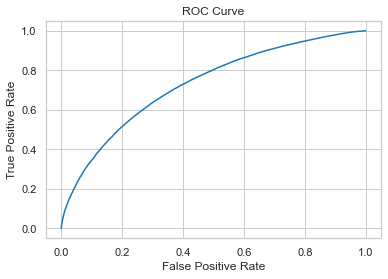

ROC AUC Score: 0.7287810026594383


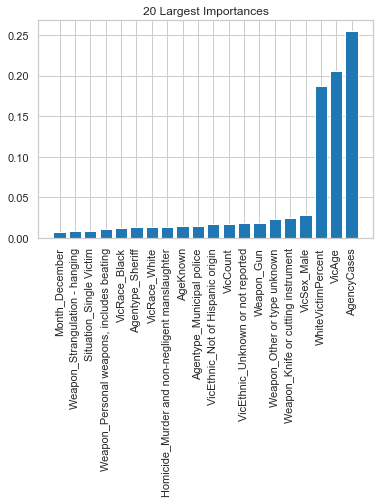

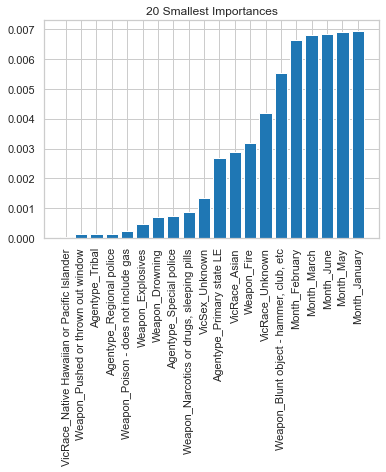

<ipython-input-8-23bb74971df8>:64: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  chart_df = proba_df.groupby('Bin')['Solved', 'Predicted Probability'].mean()


     Bin    Actual  Predicted  Count
0   0.05  0.000000   0.035007     29
1    0.1  0.030303   0.076762     66
2   0.15  0.100000   0.129578     90
3    0.2  0.120219   0.177280    183
4   0.25  0.229730   0.231220    518
5    0.3  0.265517   0.277391   1160
6   0.35  0.318832   0.326791   1747
7    0.4  0.371005   0.377278   3442
8   0.45  0.413094   0.426402   6858
9    0.5  0.449058   0.475883   8549
10  0.55  0.482649   0.525413  10979
11   0.6  0.552404   0.577136  15266
12  0.65  0.622253   0.625430  21067
13   0.7  0.681462   0.674559  20660
14  0.75  0.736214   0.725539  20854
15   0.8  0.788790   0.775651  24871
16  0.85  0.834650   0.824450  24554
17   0.9  0.887514   0.874608  23354
18  0.95  0.933600   0.921490  13238
19     1  0.966171   0.964363   3695


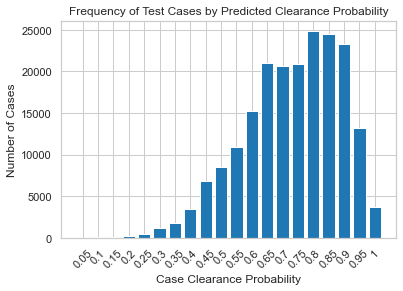

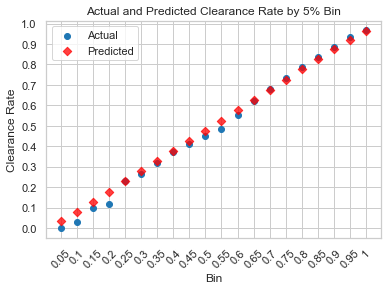

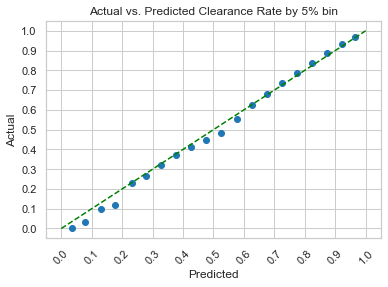

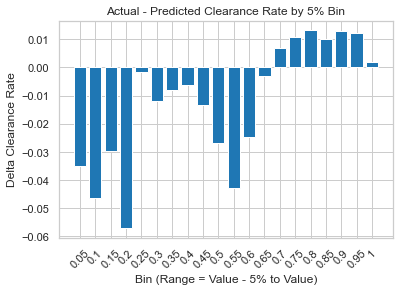

Sum of Squared Binned Residuals: 118.62669226513442
Reporting Time: 2.3 seconds


<ipython-input-3-96a6dbac1e69>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bin_df = df.groupby('Bin')['Actual', 'Predicted Probability'].mean()


In [37]:
model  = RandomForestClassifier(n_jobs = 9, 
                            random_state = 33,
                            max_depth = 25,
                            n_estimators = 1250,
                            min_samples_leaf = 2)

train(model, X_train, y_train)
y_pred, y_pred_prob = predict(model, X_test)
proba_df, chart_df = reports(model, X_train.columns, y_test, y_pred, y_pred_prob)

Training Time: 201.5 seconds
Prediction Time: 16.9 seconds
Confusion Matrix:
 [[ 15022  44151]
 [ 10338 131669]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.25      0.36     59173
           1       0.75      0.93      0.83    142007

    accuracy                           0.73    201180
   macro avg       0.67      0.59      0.59    201180
weighted avg       0.70      0.73      0.69    201180

Accuracy: 72.92 %
Log Loss: 0.5372542303026939
Brier Score Loss: 0.18013319048744184


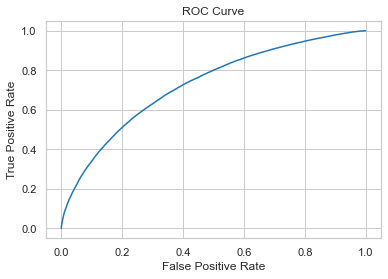

ROC AUC Score: 0.7261321353003481


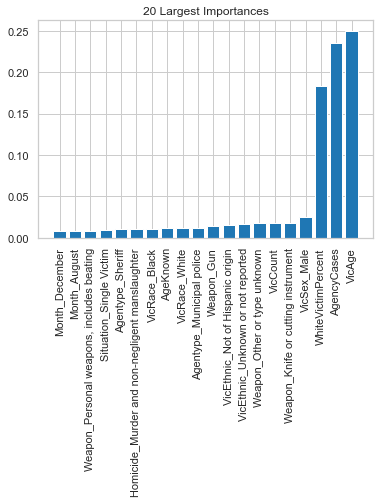

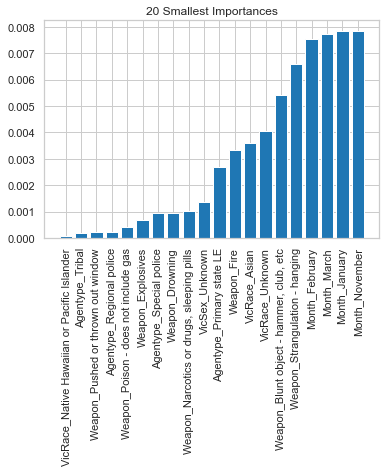

     Bin    Actual  Predicted  Count
0   0.05  0.044248   0.024584    113
1    0.1  0.150794   0.077331    126
2   0.15  0.165000   0.126818    200
3    0.2  0.225166   0.179398    453
4   0.25  0.273879   0.227021   1026
5    0.3  0.326101   0.277052   1521
6   0.35  0.358041   0.326976   2226
7    0.4  0.400654   0.377331   3976
8   0.45  0.423933   0.426451   7053
9    0.5  0.464113   0.476253   8666
10  0.55  0.499382   0.525647  10519
11   0.6  0.562075   0.576820  14402
12  0.65  0.623954   0.625206  19830
13   0.7  0.684367   0.674669  19830
14  0.75  0.728397   0.725287  19488
15   0.8  0.781675   0.775853  23465
16  0.85  0.827300   0.824727  24256
17   0.9  0.875610   0.874874  23346
18  0.95  0.924226   0.921732  15190
19     1  0.963233   0.967720   5494


<ipython-input-8-23bb74971df8>:64: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  chart_df = proba_df.groupby('Bin')['Solved', 'Predicted Probability'].mean()


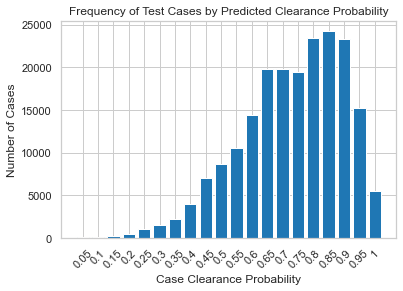

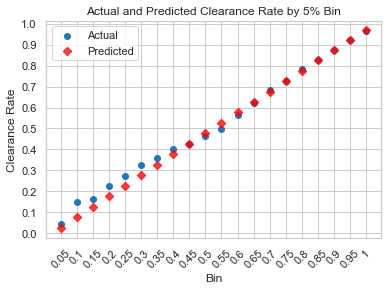

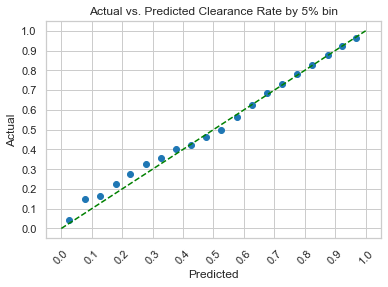

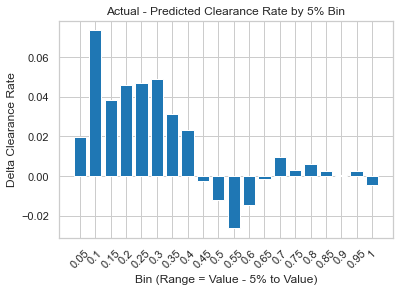

Sum of Squared Binned Residuals: 166.80158577216486
Reporting Time: 2.1 seconds


<ipython-input-3-96a6dbac1e69>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bin_df = df.groupby('Bin')['Actual', 'Predicted Probability'].mean()


In [24]:
model  = RandomForestClassifier(n_jobs = 9, 
                            random_state = 33,
                            max_depth = 25,
                            n_estimators = 1000,
                            min_samples_leaf = 1)

train(model, X_train, y_train)
y_pred, y_pred_prob = predict(model, X_test)
proba_df, chart_df = reports(model, X_train.columns, y_test, y_pred, y_pred_prob)

Training Time: 183.6 seconds
Prediction Time: 11.7 seconds
Confusion Matrix:
 [[ 12043  47130]
 [  7672 134335]]
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.20      0.31     59173
           1       0.74      0.95      0.83    142007

    accuracy                           0.73    201180
   macro avg       0.68      0.57      0.57    201180
weighted avg       0.70      0.73      0.68    201180

Accuracy: 72.76 %
Log Loss: 0.5375207418076177
Brier Score Loss: 0.18027141894567528


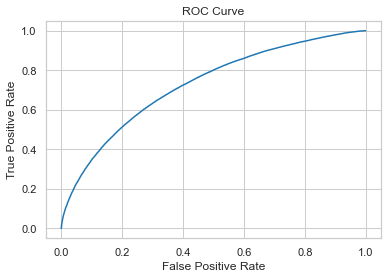

ROC AUC Score: 0.7273264976275211


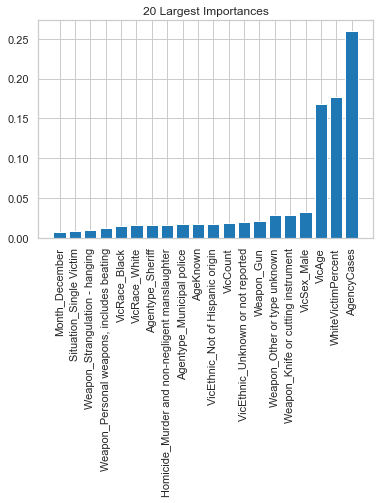

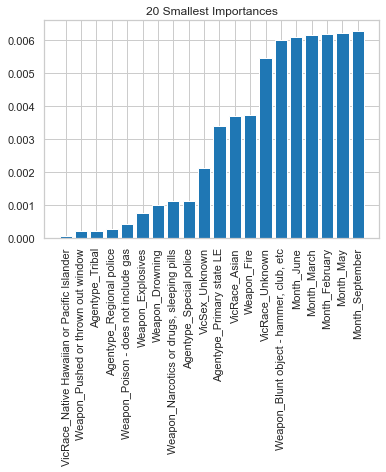

<ipython-input-54-b663c39b4905>:63: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  chart_df = proba_df.groupby('Bin')['Solved', 'Predicted Probability'].mean()


     Bin    Actual  Predicted  Count
0   0.05  0.000000   0.023179     51
1    0.1  0.044118   0.077783     68
2   0.15  0.156863   0.126454    102
3    0.2  0.094488   0.175999    127
4   0.25  0.174359   0.227367    195
5    0.3  0.185639   0.280092    571
6   0.35  0.299514   0.325944   1439
7    0.4  0.324324   0.377903   2553
8   0.45  0.406044   0.431182   5923
9    0.5  0.441745   0.474033   8686
10  0.55  0.472114   0.525807   9521
11   0.6  0.537134   0.577232  15929
12  0.65  0.618466   0.624787  25214
13   0.7  0.680559   0.673127  21666
14  0.75  0.737161   0.725306  21789
15   0.8  0.791591   0.775172  26947
16  0.85  0.844315   0.825064  23432
17   0.9  0.892795   0.873153  23637
18  0.95  0.943587   0.920885  10494
19     1  0.974260   0.963797   2836


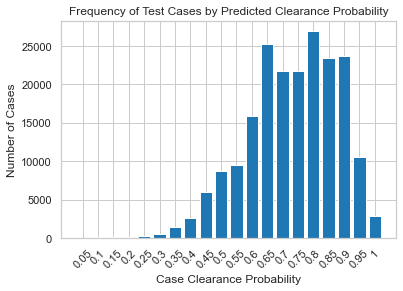

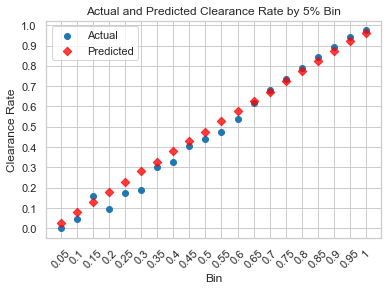

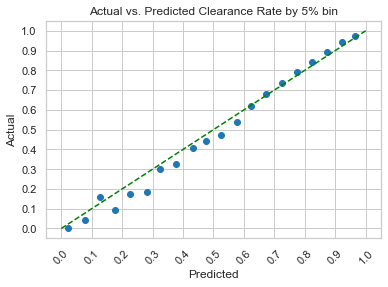

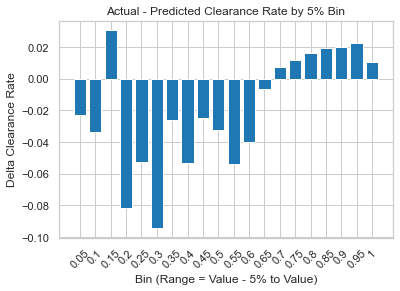

Sum of Squared Binned Residuals: 325.91698220521613
Reporting Time: 2.0 seconds


<ipython-input-3-96a6dbac1e69>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bin_df = df.groupby('Bin')['Actual', 'Predicted Probability'].mean()


In [88]:
model  = RandomForestClassifier(n_jobs = 9, 
                            random_state = 33,
                            max_depth = 20,
                            n_estimators = 1000,
                            min_samples_leaf = 1)

train(model, X_train, y_train)
y_pred, y_pred_prob = predict(model, X_test)
proba_df, chart_df = reports(model, X_train.columns, y_test, y_pred, y_pred_prob)

Naive Bayes

In [31]:
model  = GaussianNB()

grid = [{'var_smoothing' : np.logspace(-10, 0, 11)}]

grid_results = grid_search(grid, model, X_train_balanced, y_train_balanced)
grid_results

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Grid Search Time: 14.4 seconds


BSSR Rank     BSSR Mean    BSSR Std  ROC_AUC Rank  \
{'var_smoothing': 1e-10}          10 -15369.414110  426.510140            10   
{'var_smoothing': 1e-09}           9 -15369.414075  426.510136            10   
{'var_smoothing': 1e-08}           8 -15369.413724  426.510104             9   
{'var_smoothing': 1e-07}           7 -15369.410212  426.509779             8   
{'var_smoothing': 1e-06}          11 -15369.564988  426.650668             7   
{'var_smoothing': 1e-05}           6 -15369.373062  426.925082             6   
{'var_smoothing': 0.0001}          5 -15367.867945  428.279186             5   
{'var_smoothing': 0.001}           4 -15357.170295  426.470507             4   
{'var_smoothing': 0.01}            3 -15264.064361  395.735807             3   
{'var_smoothing': 0.1}             2 -14303.472180  429.130680             2   
{'var_smoothing': 1.0}             1  -7516.905675  545.209874             1   

                           ROC_AUC Mean  ROC_AUC Std  Precision Rank  \
{'var_smoothing': 1e-10}       0.642222     0.001604               4   
{'var_smoothing': 1e-09}       0.642222     0.001604               4   
{'var_smoothing': 1e-08}       0.642222     0.001604               4   
{'var_smoothing': 1e-07}       0.642222     0.001604               4   
{'var_smoothing': 1e-06}       0.642222     0.001604               4   
{'var_smoothing': 1e-05}       0.642222     0.001604               4   
{'var_smoothing': 0.0001}      0.642223     0.001604              10   
{'var_smoothing': 0.001}       0.642229     0.001604              11   
{'var_smoothing': 0.01}        0.642288     0.001605               3   
{'var_smoothing': 0.1}         0.642835     0.001616               2   
{'var_smoothing': 1.0}         0.645374     0.001622               1   

                           Precision Mean  Precision Std  Recall Rank  \
{'var_smoothing': 1e-10}         0.608290       0.001380            3   
{'var_smoothing': 1e-09}         0.608290       0.001380            3   
{'var_smoothing': 1e-08}         0.608290       0.001380            3   
{'var_smoothing': 1e-07}         0.608290       0.001380            3   
{'var_smoothing': 1e-06}         0.608290       0.001380            3   
{'var_smoothing': 1e-05}         0.608290       0.001380            3   
{'var_smoothing': 0.0001}        0.608287       0.001379            9   
{'var_smoothing': 0.001}         0.608269       0.001361           10   
{'var_smoothing': 0.01}          0.608319       0.001293            2   
{'var_smoothing': 0.1}           0.609341       0.001315            1   
{'var_smoothing': 1.0}           0.618709       0.001073           11   

                           Recall Mean  Recall Std  Accuracy Rank  \
{'var_smoothing': 1e-10}      0.561230    0.003034              3   
{'var_smoothing': 1e-09}      0.561230    0.003034              3   
{'var_smoothing': 1e-08}      0.561230    0.003034              3   
{'var_smoothing': 1e-07}      0.561230    0.003034              3   
{'var_smoothing': 1e-06}      0.561230    0.003034              3   
{'var_smoothing': 1e-05}      0.561230    0.003034              3   
{'var_smoothing': 0.0001}     0.561227    0.003036              9   
{'var_smoothing': 0.001}      0.561227    0.003031             10   
{'var_smoothing': 0.01}       0.561357    0.003004              2   
{'var_smoothing': 0.1}        0.561836    0.002833              1   
{'var_smoothing': 1.0}        0.554876    0.002780             11   

                           Accuracy Mean  Accuracy Std  F1 Rank   F1 Mean  \
{'var_smoothing': 1e-10}        0.561230      0.003034        4  0.507685   
{'var_smoothing': 1e-09}        0.561230      0.003034        4  0.507685   
{'var_smoothing': 1e-08}        0.561230      0.003034        4  0.507685   
{'var_smoothing': 1e-07}        0.561230      0.003034        4  0.507685   
{'var_smoothing': 1e-06}        0.561230      0.003034        4  0.507685   
{'var_smoothing': 1e-05}        0

In [36]:
model  = GaussianNB()

grid = [{'var_smoothing' : np.logspace(0, 10, 11)}]

grid_results = grid_search(grid, model, X_train_balanced, y_train_balanced)
grid_results

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Grid Search Time: 12.7 seconds


BSSR Rank    BSSR Mean     BSSR Std  \
{'var_smoothing': 1.0}                   10 -7516.905675   545.209874   
{'var_smoothing': 10.0}                  11 -9000.573648  2954.592005   
{'var_smoothing': 100.0}                  9 -1318.396224   695.399212   
{'var_smoothing': 1000.0}                 7  -557.764906    25.894356   
{'var_smoothing': 10000.0}                6  -555.752105    25.686497   
{'var_smoothing': 100000.0}               8  -666.149541   334.089449   
{'var_smoothing': 1000000.0}              1  -340.032600   278.476929   
{'var_smoothing': 10000000.0}             2  -340.032836   278.477123   
{'var_smoothing': 100000000.0}            5  -340.445892   278.809806   
{'var_smoothing': 1000000000.0}           3  -340.179848   278.595294   
{'var_smoothing': 10000000000.0}          4  -340.387106   278.712834   

                                  ROC_AUC Rank  ROC_AUC Mean  ROC_AUC Std  \
{'var_smoothing': 1.0}                       1      0.645374     0.001622   
{'var_smoothing': 10.0}                      2      0.644620     0.001802   
{'var_smoothing': 100.0}                     3      0.640543     0.002050   
{'var_smoothing': 1000.0}                    4      0.639126     0.002056   
{'var_smoothing': 10000.0}                   5      0.638932     0.002043   
{'var_smoothing': 100000.0}                  6      0.638909     0.002042   
{'var_smoothing': 1000000.0}                 7      0.638906     0.002041   
{'var_smoothing': 10000000.0}                9      0.638906     0.002041   
{'var_smoothing': 100000000.0}              10      0.638906     0.002041   
{'var_smoothing': 1000000000.0}             11      0.638906     0.002041   
{'var_smoothing': 10000000000.0}             8      0.638906     0.002041   

                                  Precision Rank  Precision Mean  \
{'var_smoothing': 1.0}                         6        0.618709   
{'var_smoothing': 10.0}                        2        0.627006   
{'var_smoothing': 100.0}                       3        0.623413   
{'var_smoothing': 1000.0}                      4        0.622600   
{'var_smoothing': 10000.0}                     5        0.622296   
{'var_smoothing': 100000.0}                    1        0.631590   
{'var_smoothing': 1000000.0}                   9        0.473977   
{'var_smoothing': 10000000.0}                  9        0.473977   
{'var_smoothing': 100000000.0}                 7        0.474021   
{'var_smoothing': 1000000000.0}                9        0.473977   
{'var_smoothing': 10000000000.0}               8        0.474020   

                                  Precision Std  Recall Rank  Recall Mean  \
{'var_smoothing': 1.0}                 0.001073            1     0.554876   
{'var_smoothing': 10.0}                0.002760            2     0.532729   
{'var_smoothing': 100.0}               0.003442            4     0.520449   
{'var_smoothing': 1000.0}              0.002962            5     0.517649   
{'var_smoothing': 10000.0}             0.003236            6     0.517460   
{'var_smoothing': 100000.0}            0.025764            3     0.522910   
{'var_smoothing': 1000000.0}           0.182903            8     0.510140   
{'var_smoothing': 10000000.0}          0.182903            8     0.510140   
{'var_smoothing': 100000000.0}         0.182939            7     0.510143   
{'var_smoothing': 1000000000.0}        0.182903            8     0.510140   
{'var_smoothing': 10000000000.0}       0.182938            8     0.510140   

                                  Recall Std  Accuracy Rank  Accuracy Mean  \
{'var_smoothing': 1.0}              0.002780              1       0.554876   
{'var_smoothing': 10.0}             0.003374              2       0.532729   
{'var_smoothing': 100.0}            0.003561              4       0.520449   
{'var_smoothing': 1000.0}           0.003366              5       0.517649   
{'var_smoothing': 10000.0}          0.004198              6       0.517460   
{'var_smoothing': 1000

Training Time: 0.3 seconds
Prediction Time: 0.3 seconds
Confusion Matrix:
 [[ 54567   4606]
 [115587  26420]]
Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.92      0.48     59173
           1       0.85      0.19      0.31    142007

    accuracy                           0.40    201180
   macro avg       0.59      0.55      0.39    201180
weighted avg       0.70      0.40      0.36    201180

Accuracy: 40.26 %
Log Loss: 1.1096870902251292
Brier Score Loss: 0.36592567109140656


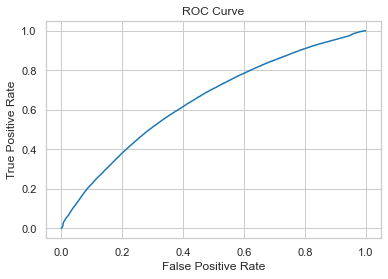

ROC AUC Score: 0.6465721722023938
     Bin    Actual  Predicted  Count
0   0.05  0.533168   0.005439   7658
1    0.1  0.496811   0.082128   7212
2   0.15  0.543573   0.129819  15560
3    0.2  0.624060   0.176620  39344
4   0.25  0.687826   0.223558  27821
5    0.3  0.732692   0.274247  23587
6   0.35  0.772247   0.322819  17418
7    0.4  0.784049   0.373932  11623
8   0.45  0.789962   0.425625  10141
9    0.5  0.808682   0.474662   9790
10  0.55  0.836965   0.522452   6747
11   0.6  0.837705   0.573427   4689
12  0.65  0.831113   0.624193   3754
13   0.7  0.851608   0.673872   2581
14  0.75  0.865191   0.722633   1491
15   0.8  0.833169   0.775806   1013
16  0.85  0.829003   0.823912   1193
17   0.9  0.810811   0.874608    666
18  0.95  0.851079   0.929294   2780
19     1  0.899542   0.993268   6112


<ipython-input-49-0dab07a5db0e>:63: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  chart_df = proba_df.groupby('Bin')['Solved', 'Predicted Probability'].mean()


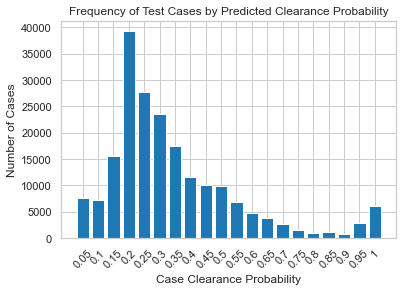

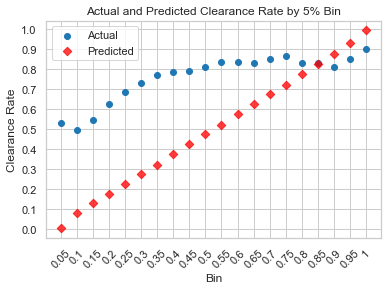

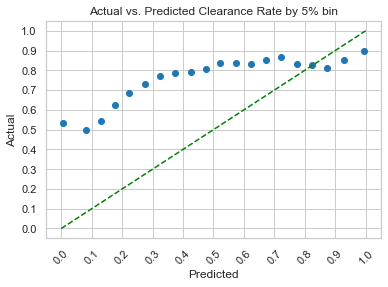

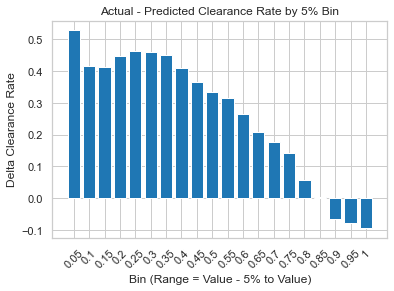

Sum of Squared Binned Residuals: 21478.424773601007
Reporting Time: 1.4 seconds


<ipython-input-3-96a6dbac1e69>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bin_df = df.groupby('Bin')['Actual', 'Predicted Probability'].mean()


In [51]:
model  = GaussianNB(var_smoothing = 1)

train(model, X_train_balanced, y_train_balanced)
y_pred, y_pred_prob = predict(model, X_test)
proba_df, chart_df = reports(model, X_train_balanced.columns, y_test, y_pred, y_pred_prob)

In [41]:
model  = GaussianNB()

grid = [{'var_smoothing' : np.logspace(-10, 0, 11)
        }]

grid_results = grid_search(grid, model, X_train, y_train)
grid_results

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Grid Search Time: 18.8 seconds


BSSR Rank     BSSR Mean    BSSR Std  ROC_AUC Rank  \
{'var_smoothing': 1e-10}          11 -28276.970535  515.731291             8   
{'var_smoothing': 1e-09}          10 -28276.970473  515.731289             8   
{'var_smoothing': 1e-08}           9 -28276.969862  515.731271            10   
{'var_smoothing': 1e-07}           8 -28276.963747  515.731089             7   
{'var_smoothing': 1e-06}           7 -28276.917439  515.695193            11   
{'var_smoothing': 1e-05}           6 -28276.715630  516.224370             6   
{'var_smoothing': 0.0001}          5 -28275.910599  515.858969             5   
{'var_smoothing': 0.001}           4 -28252.741334  516.425503             4   
{'var_smoothing': 0.01}            3 -28078.502806  521.740744             3   
{'var_smoothing': 0.1}             2 -26234.361999  554.483180             2   
{'var_smoothing': 1.0}             1 -14680.934995  322.481840             1   

                           ROC_AUC Mean  ROC_AUC Std  Precision Rank  \
{'var_smoothing': 1e-10}       0.642477     0.001152               2   
{'var_smoothing': 1e-09}       0.642477     0.001152               2   
{'var_smoothing': 1e-08}       0.642477     0.001152               2   
{'var_smoothing': 1e-07}       0.642477     0.001152               2   
{'var_smoothing': 1e-06}       0.642477     0.001152               2   
{'var_smoothing': 1e-05}       0.642477     0.001152               7   
{'var_smoothing': 0.0001}      0.642478     0.001152               8   
{'var_smoothing': 0.001}       0.642483     0.001152               1   
{'var_smoothing': 0.01}        0.642531     0.001153              10   
{'var_smoothing': 0.1}         0.642975     0.001163              11   
{'var_smoothing': 1.0}         0.645259     0.001255               9   

                           Precision Mean  Precision Std  Recall Rank  \
{'var_smoothing': 1e-10}         0.679047       0.001131            5   
{'var_smoothing': 1e-09}         0.679047       0.001131            5   
{'var_smoothing': 1e-08}         0.679047       0.001131            5   
{'var_smoothing': 1e-07}         0.679047       0.001131            5   
{'var_smoothing': 1e-06}         0.679047       0.001131            5   
{'var_smoothing': 1e-05}         0.679037       0.001140           10   
{'var_smoothing': 0.0001}        0.679026       0.001146           11   
{'var_smoothing': 0.001}         0.679056       0.001161            4   
{'var_smoothing': 0.01}          0.678945       0.001150            3   
{'var_smoothing': 0.1}           0.678399       0.001235            2   
{'var_smoothing': 1.0}           0.678971       0.000917            1   

                           Recall Mean  Recall Std  Accuracy Rank  \
{'var_smoothing': 1e-10}      0.463863    0.005066              5   
{'var_smoothing': 1e-09}      0.463863    0.005066              5   
{'var_smoothing': 1e-08}      0.463863    0.005066              5   
{'var_smoothing': 1e-07}      0.463863    0.005066              5   
{'var_smoothing': 1e-06}      0.463863    0.005066              5   
{'var_smoothing': 1e-05}      0.463861    0.005068             10   
{'var_smoothing': 0.0001}     0.463858    0.005065             11   
{'var_smoothing': 0.001}      0.463964    0.005085              4   
{'var_smoothing': 0.01}       0.464779    0.005098              3   
{'var_smoothing': 0.1}        0.471329    0.005131              2   
{'var_smoothing': 1.0}        0.531980    0.009482              1   

                           Accuracy Mean  Accuracy Std  F1 Rank   F1 Mean  \
{'var_smoothing': 1e-10}        0.463863      0.005066        6  0.456530   
{'var_smoothing': 1e-09}        0.463863      0.005066        6  0.456530   
{'var_smoothing': 1e-08}        0.463863      0.005066        6  0.456530   
{'var_smoothing': 1e-07}        0.463863      0.005066        6  0.456530   
{'var_smoothing': 1e-06}        0.463863      0.005066        6  0.456530   
{'var_smoothing': 1e-05}        0

In [42]:
model  = GaussianNB()

grid = [{'var_smoothing' : np.logspace(0, 10, 11)
        }]

grid_results = grid_search(grid, model, X_train, y_train)
grid_results

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Grid Search Time: 21.3 seconds


BSSR Rank     BSSR Mean      BSSR Std  \
{'var_smoothing': 1.0}                   10 -1.468093e+04  3.224818e+02   
{'var_smoothing': 10.0}                  11 -1.539215e+04  4.394762e+03   
{'var_smoothing': 100.0}                  9 -5.145325e+02  1.918327e+02   
{'var_smoothing': 1000.0}                 8 -1.448727e-03  1.632267e-04   
{'var_smoothing': 10000.0}                7 -1.461581e-05  3.005520e-06   
{'var_smoothing': 100000.0}               6 -2.619174e-07  3.920195e-07   
{'var_smoothing': 1000000.0}              5 -1.194620e-07  1.799463e-07   
{'var_smoothing': 10000000.0}             4 -1.181482e-07  1.615280e-07   
{'var_smoothing': 100000000.0}            1 -1.181461e-07  1.597540e-07   
{'var_smoothing': 1000000000.0}           2 -1.181472e-07  1.595774e-07   
{'var_smoothing': 10000000000.0}          3 -1.181473e-07  1.595597e-07   

                                  ROC_AUC Rank  ROC_AUC Mean  ROC_AUC Std  \
{'var_smoothing': 1.0}                       1      0.645259     0.001255   
{'var_smoothing': 10.0}                      2      0.644937     0.001577   
{'var_smoothing': 100.0}                     3      0.641053     0.001825   
{'var_smoothing': 1000.0}                    4      0.639341     0.001853   
{'var_smoothing': 10000.0}                   5      0.639098     0.001857   
{'var_smoothing': 100000.0}                  6      0.639069     0.001859   
{'var_smoothing': 1000000.0}                 8      0.639066     0.001859   
{'var_smoothing': 10000000.0}                9      0.639066     0.001859   
{'var_smoothing': 100000000.0}              11      0.639066     0.001859   
{'var_smoothing': 1000000000.0}             10      0.639066     0.001859   
{'var_smoothing': 10000000000.0}             7      0.639067     0.001860   

                                  Precision Rank  Precision Mean  \
{'var_smoothing': 1.0}                         2        0.678971   
{'var_smoothing': 10.0}                        1        0.683648   
{'var_smoothing': 100.0}                       3        0.498252   
{'var_smoothing': 1000.0}                      3        0.498252   
{'var_smoothing': 10000.0}                     3        0.498252   
{'var_smoothing': 100000.0}                    3        0.498252   
{'var_smoothing': 1000000.0}                   3        0.498252   
{'var_smoothing': 10000000.0}                  3        0.498252   
{'var_smoothing': 100000000.0}                 3        0.498252   
{'var_smoothing': 1000000000.0}                3        0.498252   
{'var_smoothing': 10000000000.0}               3        0.498252   

                                  Precision Std  Recall Rank  Recall Mean  \
{'var_smoothing': 1.0}                 0.000917           11     0.531980   
{'var_smoothing': 10.0}                0.008009            1     0.706375   
{'var_smoothing': 100.0}               0.000004            2     0.705869   
{'var_smoothing': 1000.0}              0.000004            2     0.705869   
{'var_smoothing': 10000.0}             0.000004            2     0.705869   
{'var_smoothing': 100000.0}            0.000004            2     0.705869   
{'var_smoothing': 1000000.0}           0.000004            2     0.705869   
{'var_smoothing': 10000000.0}          0.000004            2     0.705869   
{'var_smoothing': 100000000.0}         0.000004            2     0.705869   
{'var_smoothing': 1000000000.0}        0.000004            2     0.705869   
{'var_smoothing': 10000000000.0}       0.000004            2     0.705869   

                                  Recall Std  Accuracy Rank  Accuracy Mean  \
{'var_smoothing': 1.0}              0.009482             11       0.531980   
{'var_smoothing': 10.0}             0.000116              1       0.706375   
{'var_smoothing': 100.0}            0.000003              2       0.705869   
{'var_smoothing': 1000.0}           0.000003              2       0.705869   
{'var_smoothing': 10000.0}          0.000003              2       0.705869  

Training Time: 0.5 seconds
Prediction Time: 0.3 seconds
Confusion Matrix:
 [[45206 13967]
 [80504 61503]]
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.76      0.49     59173
           1       0.81      0.43      0.57    142007

    accuracy                           0.53    201180
   macro avg       0.59      0.60      0.53    201180
weighted avg       0.68      0.53      0.54    201180

Accuracy: 53.04 %
Log Loss: 0.9056876085612069
Brier Score Loss: 0.27481571536878097


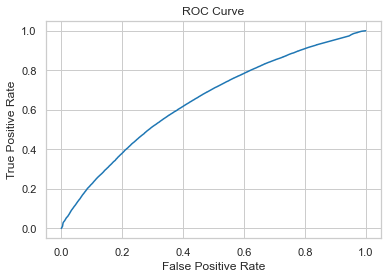

ROC AUC Score: 0.6467319751492391
     Bin    Actual  Predicted  Count
0   0.05  0.534993   0.002864   7230
1    0.1  0.532899   0.078055   1383
2   0.15  0.501210   0.129392   4958
3    0.2  0.499086   0.176283   6015
4   0.25  0.560900   0.227923  10041
5    0.3  0.598135   0.277769  20161
6   0.35  0.648098   0.323643  25706
7    0.4  0.689939   0.374785  17474
8   0.45  0.713813   0.424775  16926
9    0.5  0.753857   0.474473  15816
10  0.55  0.778486   0.523525  12243
11   0.6  0.788347   0.574474   9714
12  0.65  0.782628   0.625143   8980
13   0.7  0.800614   0.675050   9765
14  0.75  0.826547   0.722921   8325
15   0.8  0.835803   0.773976   5871
16  0.85  0.834770   0.824469   4987
17   0.9  0.858098   0.872529   3439
18  0.95  0.854796   0.926926   2252
19     1  0.873358   0.991816   9894


<ipython-input-49-0dab07a5db0e>:63: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  chart_df = proba_df.groupby('Bin')['Solved', 'Predicted Probability'].mean()


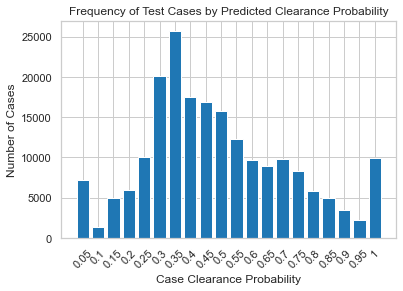

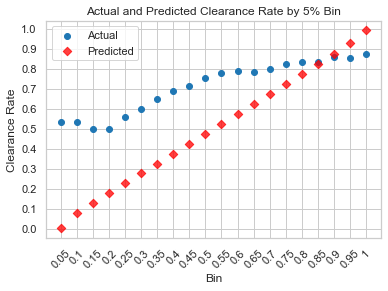

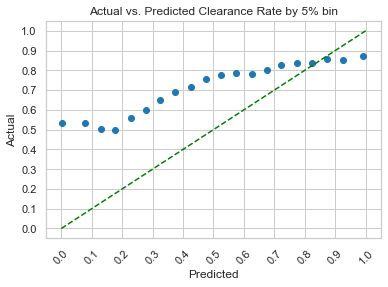

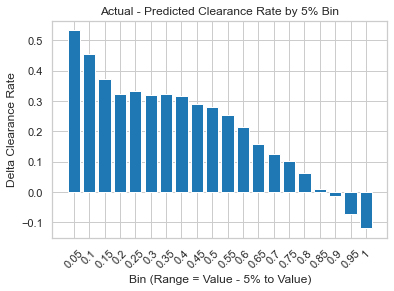

Sum of Squared Binned Residuals: 14976.198137133615
Reporting Time: 1.4 seconds


<ipython-input-3-96a6dbac1e69>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bin_df = df.groupby('Bin')['Actual', 'Predicted Probability'].mean()


In [50]:
model  = GaussianNB(var_smoothing = 1)

train(model, X_train, y_train)
y_pred, y_pred_prob = predict(model, X_test)
proba_df, chart_df = reports(model, X_train.columns, y_test, y_pred, y_pred_prob)

Algorithm 4

Testing a few for runtime

Training Time: 2.2 seconds
Prediction Time: 0.0 seconds
Confusion Matrix:
 [[  4800  54373]
 [  4462 137545]]
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.08      0.14     59173
           1       0.72      0.97      0.82    142007

    accuracy                           0.71    201180
   macro avg       0.62      0.52      0.48    201180
weighted avg       0.66      0.71      0.62    201180

Accuracy: 70.76 %
Log Loss: 0.5730154388024097
Brier Score Loss: 0.19421981279275993


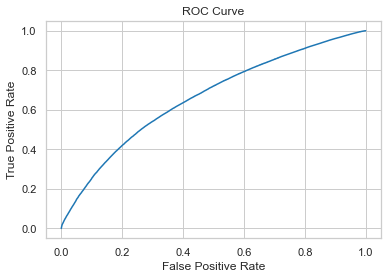

ROC AUC Score: 0.6618046778475272


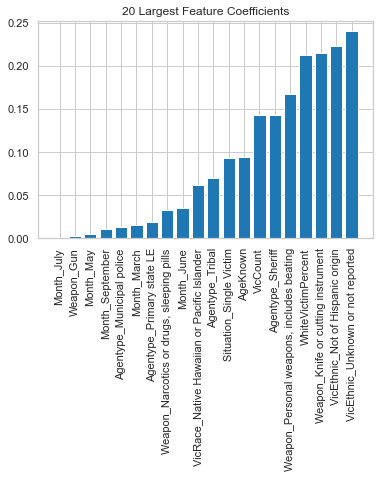

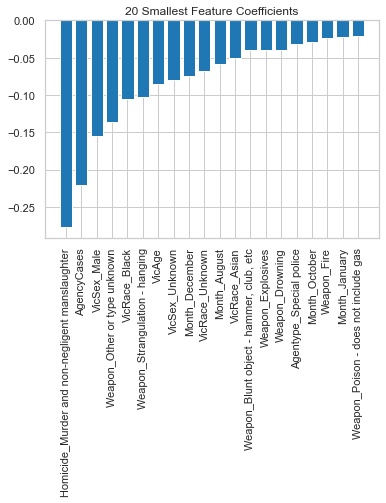

<ipython-input-54-b663c39b4905>:63: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  chart_df = proba_df.groupby('Bin')['Solved', 'Predicted Probability'].mean()


     Bin    Actual  Predicted  Count
0   0.05  0.130435   0.037152     23
1    0.1  0.266667   0.072571    105
2   0.15  0.300000   0.124675     90
3    0.2  0.357143   0.175365     70
4   0.25  0.380368   0.226354    163
5    0.3  0.412245   0.278204    245
6   0.35  0.419355   0.328131    496
7    0.4  0.439091   0.377971   1100
8   0.45  0.495767   0.427783   2126
9    0.5  0.510116   0.478847   4844
10  0.55  0.530391   0.527521  10990
11   0.6  0.567139   0.576090  17285
12  0.65  0.610347   0.626420  25302
13   0.7  0.666710   0.674746  30901
14  0.75  0.719756   0.724564  28047
15   0.8  0.783026   0.774957  27607
16  0.85  0.827822   0.824452  25038
17   0.9  0.859172   0.872104  17177
18  0.95  0.877581   0.919587   6829
19     1  0.943107   0.970968   2742


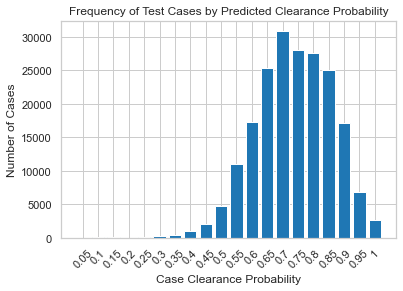

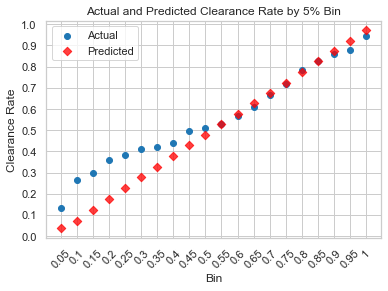

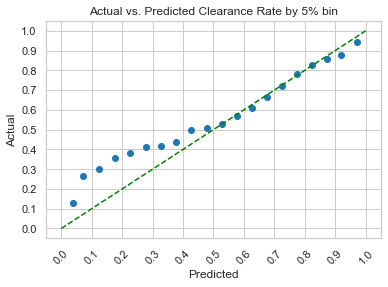

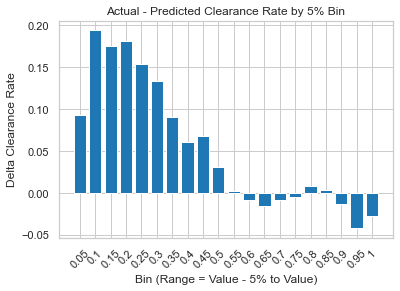

Sum of Squared Binned Residuals: 1727.2007509305809
Reporting Time: 1.8 seconds


<ipython-input-3-96a6dbac1e69>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bin_df = df.groupby('Bin')['Actual', 'Predicted Probability'].mean()


In [58]:
model  = SGDClassifier(loss = 'log', random_state = 33)

train(model, X_train, y_train)
y_pred, y_pred_prob = predict(model, X_test)
proba_df, chart_df = reports(model, X_train.columns, y_test, y_pred, y_pred_prob)

Training Time: 141.8 seconds
Prediction Time: 19.0 seconds
Confusion Matrix:
 [[ 24078  35095]
 [ 26889 115118]]
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.41      0.44     59173
           1       0.77      0.81      0.79    142007

    accuracy                           0.69    201180
   macro avg       0.62      0.61      0.61    201180
weighted avg       0.68      0.69      0.68    201180

Accuracy: 69.19 %
Log Loss: 2.431293878262993
Brier Score Loss: 0.22706882422148741


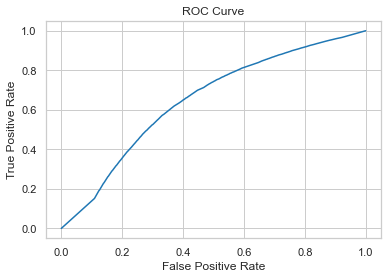

ROC AUC Score: 0.6487723184642877


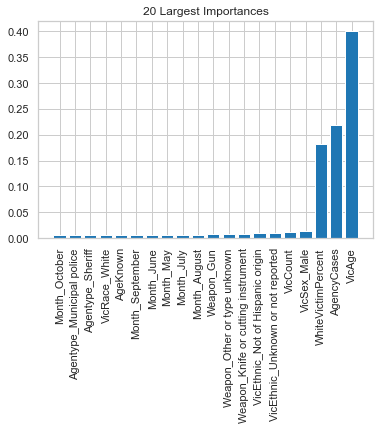

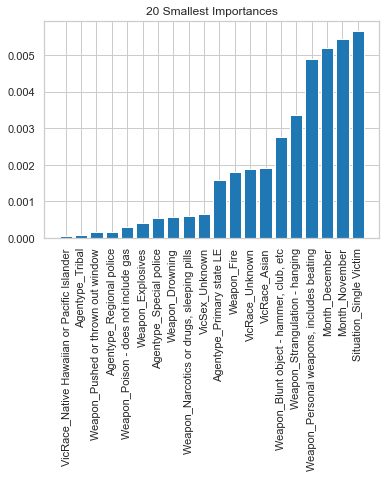

     Bin    Actual  Predicted  Count
0   0.05  0.437908   0.029509   1683
1    0.1  0.465258   0.079611   1799
2   0.15  0.483485   0.129445   2089
3    0.2  0.488356   0.181432   2877
4   0.25  0.499572   0.234668   3505
5    0.3  0.527044   0.278760   3106
6   0.35  0.527421   0.329515   5379
7    0.4  0.541700   0.381632   4940
8   0.45  0.567496   0.428949   4904
9    0.5  0.568615   0.489985  11324
10  0.55  0.625637   0.529681   5492
11   0.6  0.640719   0.577310   6616
12  0.65  0.670568   0.625454   7947
13   0.7  0.687062   0.675892   9839
14  0.75  0.710599   0.730880  10501
15   0.8  0.748904   0.781221  10717
16  0.85  0.781501   0.830445  12055
17   0.9  0.803344   0.880115  15250
18  0.95  0.819425   0.930544  20252
19     1  0.807058   0.988927  51544


<ipython-input-54-b663c39b4905>:63: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  chart_df = proba_df.groupby('Bin')['Solved', 'Predicted Probability'].mean()


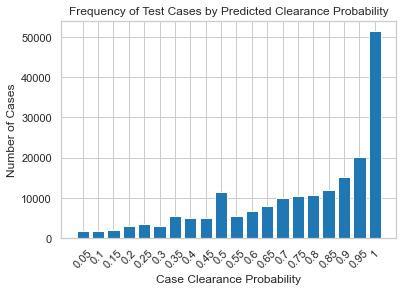

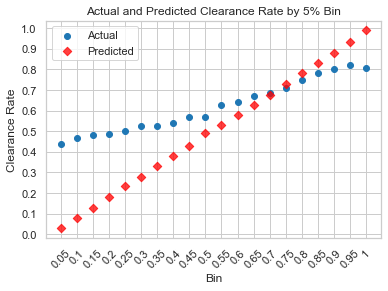

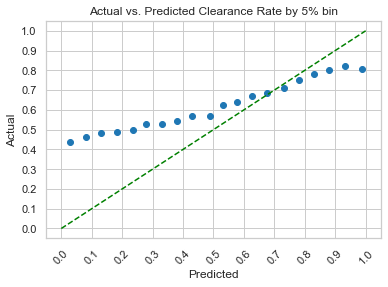

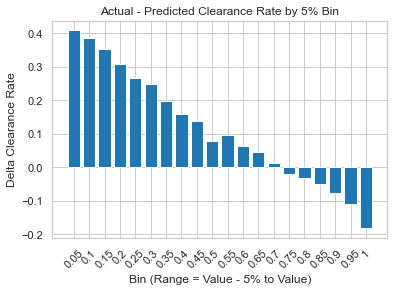

Sum of Squared Binned Residuals: 8276.039493248385
Reporting Time: 2.3 seconds


<ipython-input-3-96a6dbac1e69>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bin_df = df.groupby('Bin')['Actual', 'Predicted Probability'].mean()


In [59]:
model  = ExtraTreesClassifier(random_state = 33)

train(model, X_train, y_train)
y_pred, y_pred_prob = predict(model, X_test)
proba_df, chart_df = reports(model, X_train.columns, y_test, y_pred, y_pred_prob)

Training Time: 83.5 seconds
Prediction Time: 0.7 seconds
Confusion Matrix:
 [[ 10055  49118]
 [  6928 135079]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.17      0.26     59173
           1       0.73      0.95      0.83    142007

    accuracy                           0.72    201180
   macro avg       0.66      0.56      0.55    201180
weighted avg       0.69      0.72      0.66    201180

Accuracy: 72.14 %
Log Loss: 0.5512278050297944
Brier Score Loss: 0.1855567819962968


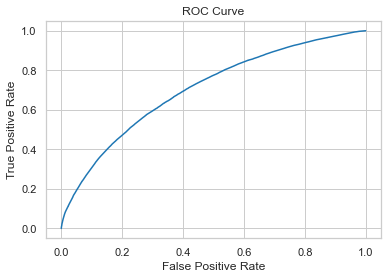

ROC AUC Score: 0.7042899781261903


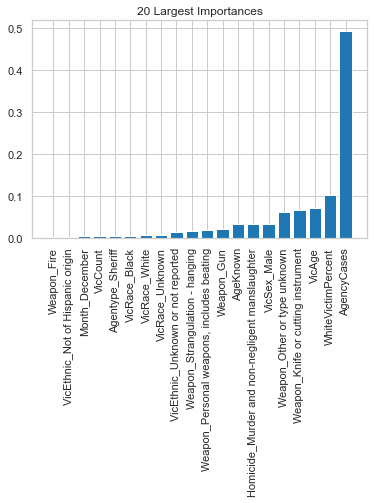

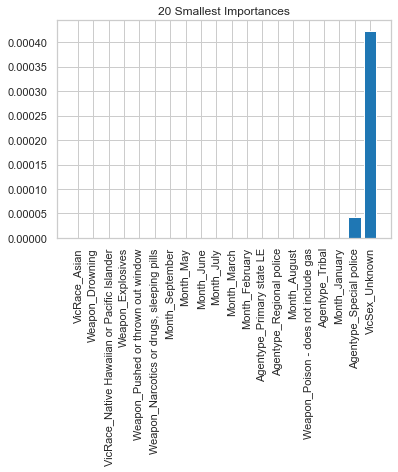

<ipython-input-54-b663c39b4905>:63: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  chart_df = proba_df.groupby('Bin')['Solved', 'Predicted Probability'].mean()


     Bin    Actual  Predicted  Count
0   0.05       NaN        NaN      0
1    0.1       NaN        NaN      0
2   0.15  0.000000   0.143569      9
3    0.2  0.066667   0.174032     75
4   0.25  0.154545   0.228046    110
5    0.3  0.216667   0.276618    240
6   0.35  0.273438   0.332389    384
7    0.4  0.323805   0.374822   2029
8   0.45  0.412628   0.431349   2043
9    0.5  0.434053   0.473458  12093
10  0.55  0.494991   0.526926  11079
11   0.6  0.553066   0.581409  12183
12  0.65  0.610231   0.626002  26526
13   0.7  0.681767   0.673010  24834
14  0.75  0.735875   0.725256  26673
15   0.8  0.781634   0.775858  24839
16  0.85  0.843299   0.825304  31423
17   0.9  0.894391   0.870948  20093
18  0.95  0.947664   0.923922   5694
19     1  0.973036   0.959436    853


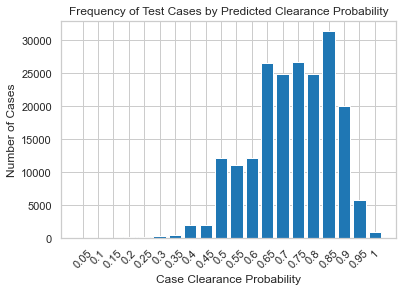

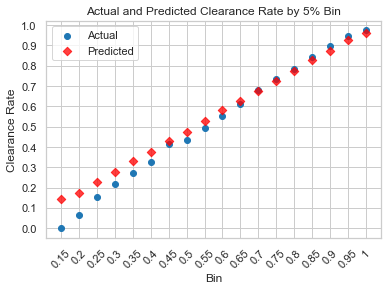

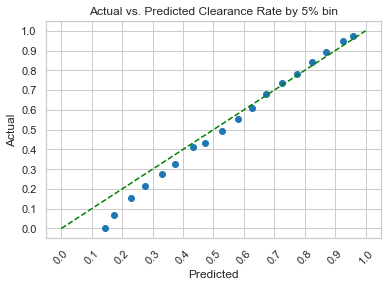

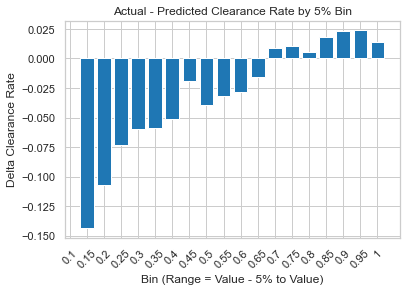

Sum of Squared Binned Residuals: 530.3392722639564
Reporting Time: 1.8 seconds


<ipython-input-3-96a6dbac1e69>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bin_df = df.groupby('Bin')['Actual', 'Predicted Probability'].mean()


In [60]:
model  = GradientBoostingClassifier(random_state = 33)

train(model, X_train, y_train)
y_pred, y_pred_prob = predict(model, X_test)
proba_df, chart_df = reports(model, X_train.columns, y_test, y_pred, y_pred_prob)

Extra Trees Classifier

In [61]:
model  = ExtraTreesClassifier(random_state = 33)

grid = [{'n_estimators' : [25, 50, 100, 250, 500]
        }]

grid_results = grid_search(grid, model, X_train_balanced, y_train_balanced)
grid_results

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\Work_Remote\anaconda3\envs\Murder Project\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.61999721 0.62153289 0.62267369 0.62277901        nan]
  warnings.warn(
C:\Users\Work_Remote\anaconda3\envs\Murder Project\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.619928   0.6214208  0.62261222 0.62274178        nan]
  warnings.warn(
C:\Users\Work_Remote\anaconda3\envs\Murder Project\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.64640393 0.64804601 0.648614   0.64900382        nan]
  warnings.warn(
C:\Users\Work_Remote\anaconda3\envs\Murder Project\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.61987312 0.62133365 0.62256499 0.62271318        nan]
  warnings.warn(
C:\Users\Work_Remote\anacond

Grid Search Time: 1425.1 seconds


BSSR Rank    BSSR Mean    BSSR Std  ROC_AUC Rank  \
{'n_estimators': 25}           4 -5693.946593  154.381976             4   
{'n_estimators': 50}           3 -5548.099371  147.650164             3   
{'n_estimators': 100}          2 -5483.716893  159.026801             2   
{'n_estimators': 250}          1 -5409.903919  166.674165             1   
{'n_estimators': 500}          5          NaN         NaN             5   

                       ROC_AUC Mean  ROC_AUC Std  Precision Rank  \
{'n_estimators': 25}       0.646404     0.002020               4   
{'n_estimators': 50}       0.648046     0.001896               3   
{'n_estimators': 100}      0.648614     0.002029               2   
{'n_estimators': 250}      0.649004     0.002072               1   
{'n_estimators': 500}           NaN          NaN               5   

                       Precision Mean  Precision Std  Recall Rank  \
{'n_estimators': 25}         0.619997       0.002133            4   
{'n_estimators': 50}         0.621533       0.002623            3   
{'n_estimators': 100}        0.622674       0.002095            2   
{'n_estimators': 250}        0.622779       0.002620            1   
{'n_estimators': 500}             NaN            NaN            5   

                       Recall Mean  Recall Std  Accuracy Rank  Accuracy Mean  \
{'n_estimators': 25}      0.619928    0.002137              4       0.619928   
{'n_estimators': 50}      0.621421    0.002614              3       0.621421   
{'n_estimators': 100}     0.622612    0.002090              2       0.622612   
{'n_estimators': 250}     0.622742    0.002619              1       0.622742   
{'n_estimators': 500}          NaN         NaN              5            NaN   

                       Accuracy Std  F1 Rank   F1 Mean    F1 Std  \
{'n_estimators': 25}       0.002137        4  0.619873  0.002140   
{'n_estimators': 50}       0.002614        3  0.621334  0.002609   
{'n_estimators': 100}      0.002090        2  0.622565  0.002088   
{'n_estimators': 250}      0.002619        1  0.622713  0.002619   
{'n_estimators': 500}           NaN        5       NaN       NaN   

                       Proba30 Rank  Proba30 Mean  Proba30 Std  
{'n_estimators': 25}              2      0.034524     0.000370  
{'n_estimators': 50}              4      0.033107     0.000253  
{'n_estimators': 100}             3      0.034088     0.000213  
{'n_estimators': 250}             1      0.035032     0.000184  
{'n_estimators': 500}             5           NaN          NaN

In [68]:
model  = ExtraTreesClassifier(random_state = 33)

grid = [{'n_estimators' : [500]
        }]

grid_results = grid_search(grid, model, X_train_balanced, y_train_balanced, folds = 3)
grid_results

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Grid Search Time: 787.9 seconds


BSSR Rank    BSSR Mean    BSSR Std  ROC_AUC Rank  \
{'n_estimators': 500}          1 -5562.807482  124.206518             1   

                       ROC_AUC Mean  ROC_AUC Std  Precision Rank  \
{'n_estimators': 500}      0.646659     0.001632               1   

                       Precision Mean  Precision Std  Recall Rank  \
{'n_estimators': 500}        0.620485       0.001685            1   

                       Recall Mean  Recall Std  Accuracy Rank  Accuracy Mean  \
{'n_estimators': 500}     0.620469    0.001691              1       0.620469   

                       Accuracy Std  F1 Rank   F1 Mean    F1 Std  \
{'n_estimators': 500}      0.001691        1  0.620456  0.001697   

                       Proba30 Rank  Proba30 Mean  Proba30 Std  
{'n_estimators': 500}             1      0.034792     0.000183

In [70]:
model  = ExtraTreesClassifier(random_state = 33,
                              n_estimators = 250)

grid = [{'max_depth' : [10, 15, 20, 25, 30]
        }]

grid_results = grid_search(grid, model, X_train_balanced, y_train_balanced, folds = 3)
grid_results

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Grid Search Time: 320.7 seconds


BSSR Rank    BSSR Mean   BSSR Std  ROC_AUC Rank  \
{'max_depth': 10}          4 -1390.468755  40.339947             4   
{'max_depth': 15}          3  -546.190466  22.113304             2   
{'max_depth': 20}          1  -136.421445  23.312610             1   
{'max_depth': 25}          2  -400.420408  35.390141             3   
{'max_depth': 30}          5 -1912.326078  86.372441             5   

                   ROC_AUC Mean  ROC_AUC Std  Precision Rank  Precision Mean  \
{'max_depth': 10}      0.685482     0.000969               5        0.634824   
{'max_depth': 15}      0.698532     0.000791               3        0.643994   
{'max_depth': 20}      0.704845     0.000863               1        0.648355   
{'max_depth': 25}      0.698457     0.000990               2        0.646109   
{'max_depth': 30}      0.681798     0.001412               4        0.637463   

                   Precision Std  Recall Rank  Recall Mean  Recall Std  \
{'max_depth': 10}       0.001447            5     0.633481    0.001400   
{'max_depth': 15}       0.001106            3     0.641824    0.000906   
{'max_depth': 20}       0.001349            1     0.646869    0.001286   
{'max_depth': 25}       0.000931            2     0.645480    0.000939   
{'max_depth': 30}       0.001277            4     0.637419    0.001261   

                   Accuracy Rank  Accuracy Mean  Accuracy Std  F1 Rank  \
{'max_depth': 10}              5       0.633481      0.001400        5   
{'max_depth': 15}              3       0.641824      0.000906        3   
{'max_depth': 20}              1       0.646869      0.001286        1   
{'max_depth': 25}              2       0.645480      0.000939        2   
{'max_depth': 30}              4       0.637419      0.001261        4   

                    F1 Mean    F1 Std  Proba30 Rank  Proba30 Mean  Proba30 Std  
{'max_depth': 10}  0.632567  0.001388             5      0.001947     0.000380  
{'max_depth': 15}  0.640471  0.000798             4      0.014604     0.000333  
{'max_depth': 20}  0.645982  0.001262             3      0.024811     0.000575  
{'max_depth': 25}  0.645098  0.000947             2      0.033394     0.000148  
{'max_depth': 30}  0.637390  0.001251             1      0.041858     0.000101

In [64]:
model  = ExtraTreesClassifier(random_state = 33,
                              n_estimators = 500)

grid = [{'max_depth' : [10, 15, 20, 25, 30]
        }]

grid_results = grid_search(grid, model, X_train_balanced, y_train_balanced, folds = 3)
grid_results

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Grid Search Time: 697.5 seconds


BSSR Rank    BSSR Mean    BSSR Std  ROC_AUC Rank  \
{'max_depth': 10}          4 -1456.188730  135.977735             4   
{'max_depth': 15}          3  -555.139210   20.420526             3   
{'max_depth': 20}          1  -139.376575   21.053397             1   
{'max_depth': 25}          2  -391.429129   31.029364             2   
{'max_depth': 30}          5 -1862.710953   89.733073             5   

                   ROC_AUC Mean  ROC_AUC Std  Precision Rank  Precision Mean  \
{'max_depth': 10}      0.685453     0.001079               5        0.635781   
{'max_depth': 15}      0.698405     0.000790               3        0.643735   
{'max_depth': 20}      0.704918     0.000667               1        0.648461   
{'max_depth': 25}      0.698630     0.001042               2        0.646079   
{'max_depth': 30}      0.681954     0.001403               4        0.637601   

                   Precision Std  Recall Rank  Recall Mean  Recall Std  \
{'max_depth': 10}       0.001430            5     0.634310    0.001352   
{'max_depth': 15}       0.000877            3     0.641579    0.000755   
{'max_depth': 20}       0.001421            1     0.646959    0.001384   
{'max_depth': 25}       0.000893            2     0.645407    0.000871   
{'max_depth': 30}       0.001045            4     0.637554    0.001037   

                   Accuracy Rank  Accuracy Mean  Accuracy Std  F1 Rank  \
{'max_depth': 10}              5       0.634310      0.001352        5   
{'max_depth': 15}              3       0.641579      0.000755        3   
{'max_depth': 20}              1       0.646959      0.001384        1   
{'max_depth': 25}              2       0.645407      0.000871        2   
{'max_depth': 30}              4       0.637554      0.001037        4   

                    F1 Mean    F1 Std  Proba30 Rank  Proba30 Mean  Proba30 Std  
{'max_depth': 10}  0.633317  0.001318             5      0.001691     0.000076  
{'max_depth': 15}  0.640231  0.000695             4      0.014697     0.000426  
{'max_depth': 20}  0.646064  0.001375             3      0.024656     0.000415  
{'max_depth': 25}  0.644999  0.000861             2      0.033174     0.000327  
{'max_depth': 30}  0.637523  0.001032             1      0.041760     0.000337

In [72]:
model  = ExtraTreesClassifier(random_state = 33,
                              n_estimators = 250,
                              max_depth = 20)

grid = [{'min_samples_split' : [1, 2, 5, 10, 20]
        }]

grid_results = grid_search(grid, model, X_train_balanced, y_train_balanced, folds = 3)
grid_results

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Grid Search Time: 280.1 seconds


C:\Users\Work_Remote\anaconda3\envs\Murder Project\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.64835533 0.64918699 0.64914628 0.64913748]
  warnings.warn(
C:\Users\Work_Remote\anaconda3\envs\Murder Project\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.64686879 0.64764335 0.64764617 0.64763208]
  warnings.warn(
C:\Users\Work_Remote\anaconda3\envs\Murder Project\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.70484454 0.70569698 0.70600737 0.70567306]
  warnings.warn(
C:\Users\Work_Remote\anaconda3\envs\Murder Project\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.64598234 0.64673006 0.64675834 0.6467406 ]
  warnings.warn(
C:\Users\Work_Remote\anacond

BSSR Rank   BSSR Mean   BSSR Std  ROC_AUC Rank  \
{'min_samples_split': 1}           5         NaN        NaN             5   
{'min_samples_split': 2}           1 -136.421445  23.312610             4   
{'min_samples_split': 5}           2 -164.286733  41.804884             2   
{'min_samples_split': 10}          3 -190.916254  10.691976             1   
{'min_samples_split': 20}          4 -226.153553  23.202708             3   

                           ROC_AUC Mean  ROC_AUC Std  Precision Rank  \
{'min_samples_split': 1}            NaN          NaN               5   
{'min_samples_split': 2}       0.704845     0.000863               4   
{'min_samples_split': 5}       0.705697     0.000831               1   
{'min_samples_split': 10}      0.706007     0.000159               2   
{'min_samples_split': 20}      0.705673     0.000440               3   

                           Precision Mean  Precision Std  Recall Rank  \
{'min_samples_split': 1}              NaN            NaN            5   
{'min_samples_split': 2}         0.648355       0.001349            4   
{'min_samples_split': 5}         0.649187       0.001467            2   
{'min_samples_split': 10}        0.649146       0.001230            1   
{'min_samples_split': 20}        0.649137       0.001400            3   

                           Recall Mean  Recall Std  Accuracy Rank  \
{'min_samples_split': 1}           NaN         NaN              5   
{'min_samples_split': 2}      0.646869    0.001286              4   
{'min_samples_split': 5}      0.647643    0.001387              2   
{'min_samples_split': 10}     0.647646    0.001160              1   
{'min_samples_split': 20}     0.647632    0.001391              3   

                           Accuracy Mean  Accuracy Std  F1 Rank   F1 Mean  \
{'min_samples_split': 1}             NaN           NaN        5       NaN   
{'min_samples_split': 2}        0.646869      0.001286        4  0.645982   
{'min_samples_split': 5}        0.647643      0.001387        3  0.646730   
{'min_samples_split': 10}       0.647646      0.001160        1  0.646758   
{'min_samples_split': 20}       0.647632      0.001391        2  0.646741   

                             F1 Std  Proba30 Rank  Proba30 Mean  Proba30 Std  
{'min_samples_split': 1}        NaN             5           NaN          NaN  
{'min_samples_split': 2}   0.001262             1      0.024811     0.000575  
{'min_samples_split': 5}   0.001352             2      0.023869     0.000559  
{'min_samples_split': 10}  0.001129             3      0.023798     0.000089  
{'min_samples_split': 20}  0.001402             4      0.022985     0.000320

Training Time: 119.9 seconds
Prediction Time: 20.1 seconds
Confusion Matrix:
 [[41523 17650]
 [56506 85501]]
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.70      0.53     59173
           1       0.83      0.60      0.70    142007

    accuracy                           0.63    201180
   macro avg       0.63      0.65      0.61    201180
weighted avg       0.71      0.63      0.65    201180

Accuracy: 63.14 %
Log Loss: 0.6248025620413322
Brier Score Loss: 0.21814473426432512


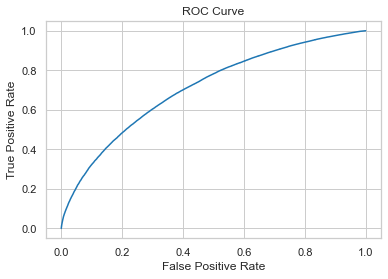

ROC AUC Score: 0.7105523929693329


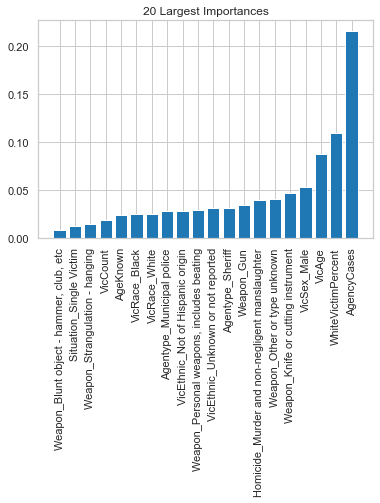

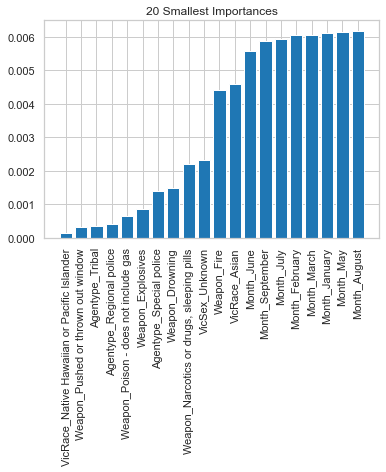

     Bin    Actual  Predicted  Count
0   0.05  0.021505   0.029145     93
1    0.1  0.176768   0.076873    198
2   0.15  0.257271   0.129329    447
3    0.2  0.334601   0.180697   1052
4   0.25  0.385228   0.232306   4143
5    0.3  0.414960   0.271863   8984
6   0.35  0.481786   0.326211  11667
7    0.4  0.548089   0.379223  17738
8   0.45  0.628976   0.424624  30874
9    0.5  0.697061   0.474139  22833
10  0.55  0.738975   0.525087  18504
11   0.6  0.774478   0.575172  17608
12  0.65  0.809911   0.624385  18323
13   0.7  0.853426   0.675435  17220
14  0.75  0.884749   0.722361  14950
15   0.8  0.914130   0.773132   8804
16  0.85  0.943649   0.820534   4188
17   0.9  0.956973   0.873533   2022
18  0.95  0.973069   0.921912   1411
19     1  0.983471   0.956809    121


<ipython-input-54-b663c39b4905>:63: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  chart_df = proba_df.groupby('Bin')['Solved', 'Predicted Probability'].mean()


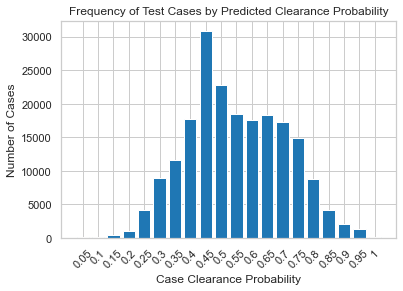

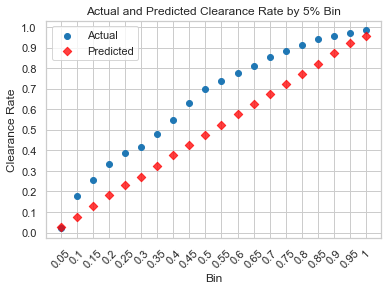

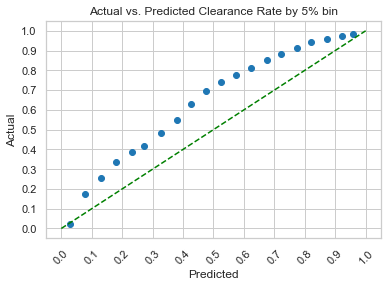

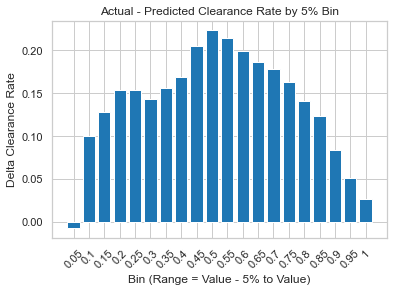

Sum of Squared Binned Residuals: 4613.976887926995
Reporting Time: 2.8 seconds


<ipython-input-3-96a6dbac1e69>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bin_df = df.groupby('Bin')['Actual', 'Predicted Probability'].mean()


In [74]:
model  = ExtraTreesClassifier(random_state = 33,
                              n_estimators = 250,
                              max_depth = 20,
                              min_samples_split = 5)

train(model, X_train_balanced, y_train_balanced)
y_pred, y_pred_prob = predict(model, X_test)
proba_df, chart_df = reports(model, X_train.columns, y_test, y_pred, y_pred_prob)

In [66]:
model  = ExtraTreesClassifier(random_state = 33,
                              class_weight = 'balanced',)

grid = [{'n_estimators' : [25, 50, 100, 250, 500]
        }]

grid_results = grid_search(grid, model, X_train, y_train, folds = 3)
grid_results

Fitting 3 folds for each of 5 candidates, totalling 15 fits


C:\Users\Work_Remote\anaconda3\envs\Murder Project\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.67912584 0.67985096 0.68036123 0.680495          nan]
  warnings.warn(
C:\Users\Work_Remote\anaconda3\envs\Murder Project\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.67892494 0.67947834 0.68078564 0.68150307        nan]
  warnings.warn(
C:\Users\Work_Remote\anaconda3\envs\Murder Project\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.642511   0.64311655 0.64310663 0.64296099        nan]
  warnings.warn(
C:\Users\Work_Remote\anaconda3\envs\Murder Project\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.67902496 0.67966369 0.68057223 0.68099213        nan]
  warnings.warn(
C:\Users\Work_Remote\anacond

Grid Search Time: 1038.8 seconds


BSSR Rank    BSSR Mean   BSSR Std  ROC_AUC Rank  \
{'n_estimators': 25}           4 -9926.795463  81.108434             4   
{'n_estimators': 50}           3 -9699.587062  35.914274             1   
{'n_estimators': 100}          2 -9662.975243  69.172533             2   
{'n_estimators': 250}          1 -9566.048409  46.933350             3   
{'n_estimators': 500}          5          NaN        NaN             5   

                       ROC_AUC Mean  ROC_AUC Std  Precision Rank  \
{'n_estimators': 25}       0.642511     0.000684               4   
{'n_estimators': 50}       0.643117     0.000829               3   
{'n_estimators': 100}      0.643107     0.000827               2   
{'n_estimators': 250}      0.642961     0.000814               1   
{'n_estimators': 500}           NaN          NaN               5   

                       Precision Mean  Precision Std  Recall Rank  \
{'n_estimators': 25}         0.679126       0.000627            4   
{'n_estimators': 50}         0.679851       0.000561            3   
{'n_estimators': 100}        0.680361       0.000521            2   
{'n_estimators': 250}        0.680495       0.000684            1   
{'n_estimators': 500}             NaN            NaN            5   

                       Recall Mean  Recall Std  Accuracy Rank  Accuracy Mean  \
{'n_estimators': 25}      0.678925    0.000471              4       0.678925   
{'n_estimators': 50}      0.679478    0.000537              3       0.679478   
{'n_estimators': 100}     0.680786    0.000497              2       0.680786   
{'n_estimators': 250}     0.681503    0.000586              1       0.681503   
{'n_estimators': 500}          NaN         NaN              5            NaN   

                       Accuracy Std  F1 Rank   F1 Mean    F1 Std  \
{'n_estimators': 25}       0.000471        4  0.679025  0.000548   
{'n_estimators': 50}       0.000537        3  0.679664  0.000547   
{'n_estimators': 100}      0.000497        2  0.680572  0.000509   
{'n_estimators': 250}      0.000586        1  0.680992  0.000635   
{'n_estimators': 500}           NaN        5       NaN       NaN   

                       Proba30 Rank  Proba30 Mean  Proba30 Std  
{'n_estimators': 25}              1      0.027390     0.000134  
{'n_estimators': 50}              4      0.026717     0.000174  
{'n_estimators': 100}             3      0.027071     0.000174  
{'n_estimators': 250}             2      0.027193     0.000201  
{'n_estimators': 500}             5           NaN          NaN

In [71]:
model  = ExtraTreesClassifier(random_state = 33,
                              class_weight = 'balanced',)

grid = [{'n_estimators' : [500]
        }]

grid_results = grid_search(grid, model, X_train, y_train, folds = 3)
grid_results

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Grid Search Time: 1529.7 seconds


BSSR Rank    BSSR Mean   BSSR Std  ROC_AUC Rank  \
{'n_estimators': 500}          1 -9535.863269  69.690353             1   

                       ROC_AUC Mean  ROC_AUC Std  Precision Rank  \
{'n_estimators': 500}      0.642826     0.000833               1   

                       Precision Mean  Precision Std  Recall Rank  \
{'n_estimators': 500}        0.680486        0.00061            1   

                       Recall Mean  Recall Std  Accuracy Rank  Accuracy Mean  \
{'n_estimators': 500}     0.681694    0.000495              1       0.681694   

                       Accuracy Std  F1 Rank  F1 Mean    F1 Std  Proba30 Rank  \
{'n_estimators': 500}      0.000495        1  0.68108  0.000554             1   

                       Proba30 Mean  Proba30 Std  
{'n_estimators': 500}       0.02718     0.000207

In [75]:
model  = ExtraTreesClassifier(random_state = 33,
                              class_weight = 'balanced',
                              n_estimators = 250)

grid = [{'max_depth' : [10, 15, 20, 25, 30]
        }]

grid_results = grid_search(grid, model, X_train, y_train, folds = 3)
grid_results

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Grid Search Time: 685.6 seconds


BSSR Rank    BSSR Mean    BSSR Std  ROC_AUC Rank  \
{'max_depth': 10}          3 -4135.454301  115.481136             4   
{'max_depth': 15}          1 -3893.848093   35.015886             3   
{'max_depth': 20}          2 -3915.432071    9.178919             1   
{'max_depth': 25}          4 -4629.064546   35.747514             2   
{'max_depth': 30}          5 -6480.923937   96.878467             5   

                   ROC_AUC Mean  ROC_AUC Std  Precision Rank  Precision Mean  \
{'max_depth': 10}      0.686231     0.002147               4        0.696305   
{'max_depth': 15}      0.699322     0.001678               2        0.702136   
{'max_depth': 20}      0.705793     0.001314               1        0.704191   
{'max_depth': 25}      0.700250     0.001585               3        0.699254   
{'max_depth': 30}      0.685398     0.001656               5        0.692876   

                   Precision Std  Recall Rank  Recall Mean  Recall Std  \
{'max_depth': 10}       0.002093            5     0.613481    0.001759   
{'max_depth': 15}       0.000846            4     0.620781    0.000895   
{'max_depth': 20}       0.001175            3     0.639411    0.001842   
{'max_depth': 25}       0.001185            2     0.658147    0.001724   
{'max_depth': 30}       0.001156            1     0.677020    0.001743   

                   Accuracy Rank  Accuracy Mean  Accuracy Std  F1 Rank  \
{'max_depth': 10}              5       0.613481      0.001759        5   
{'max_depth': 15}              4       0.620781      0.000895        4   
{'max_depth': 20}              3       0.639411      0.001842        3   
{'max_depth': 25}              2       0.658147      0.001724        2   
{'max_depth': 30}              1       0.677020      0.001743        1   

                    F1 Mean    F1 Std  Proba30 Rank  Proba30 Mean  Proba30 Std  
{'max_depth': 10}  0.630609  0.001679             5      0.000999     0.000179  
{'max_depth': 15}  0.637596  0.000856             4      0.010887     0.000149  
{'max_depth': 20}  0.655051  0.001731             3      0.016399     0.000257  
{'max_depth': 25}  0.670786  0.001582             2      0.020085     0.000405  
{'max_depth': 30}  0.683474  0.001529             1      0.024500     0.000323

In [76]:
model  = ExtraTreesClassifier(random_state = 33,
                              class_weight = 'balanced',
                              n_estimators = 250,
                              max_depth = 25)

grid = [{'min_samples_split' : [1, 2, 5, 10, 20]
        }]

grid_results = grid_search(grid, model, X_train, y_train, folds = 3)
grid_results

Fitting 3 folds for each of 5 candidates, totalling 15 fits


C:\Users\Work_Remote\anaconda3\envs\Murder Project\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.69925445 0.70451907 0.70671602 0.70765756]
  warnings.warn(
C:\Users\Work_Remote\anaconda3\envs\Murder Project\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.65814746 0.65421896 0.65087203 0.64736438]
  warnings.warn(
C:\Users\Work_Remote\anaconda3\envs\Murder Project\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.70024964 0.70681873 0.70997172 0.71119696]
  warnings.warn(
C:\Users\Work_Remote\anaconda3\envs\Murder Project\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.67078647 0.66816585 0.66546318 0.66241934]
  warnings.warn(
C:\Users\Work_Remote\anacond

Grid Search Time: 729.2 seconds


BSSR Rank    BSSR Mean   BSSR Std  ROC_AUC Rank  \
{'min_samples_split': 1}           5          NaN        NaN             5   
{'min_samples_split': 2}           4 -4629.064546  35.747514             4   
{'min_samples_split': 5}           3 -4357.106919  17.238833             3   
{'min_samples_split': 10}          2 -4238.369396   6.177130             2   
{'min_samples_split': 20}          1 -4195.709930  22.763238             1   

                           ROC_AUC Mean  ROC_AUC Std  Precision Rank  \
{'min_samples_split': 1}            NaN          NaN               5   
{'min_samples_split': 2}       0.700250     0.001585               4   
{'min_samples_split': 5}       0.706819     0.001419               3   
{'min_samples_split': 10}      0.709972     0.001433               2   
{'min_samples_split': 20}      0.711197     0.001575               1   

                           Precision Mean  Precision Std  Recall Rank  \
{'min_samples_split': 1}              NaN            NaN            5   
{'min_samples_split': 2}         0.699254       0.001185            1   
{'min_samples_split': 5}         0.704519       0.000876            2   
{'min_samples_split': 10}        0.706716       0.001070            3   
{'min_samples_split': 20}        0.707658       0.001357            4   

                           Recall Mean  Recall Std  Accuracy Rank  \
{'min_samples_split': 1}           NaN         NaN              5   
{'min_samples_split': 2}      0.658147    0.001724              1   
{'min_samples_split': 5}      0.654219    0.001654              2   
{'min_samples_split': 10}     0.650872    0.001412              3   
{'min_samples_split': 20}     0.647364    0.002124              4   

                           Accuracy Mean  Accuracy Std  F1 Rank   F1 Mean  \
{'min_samples_split': 1}             NaN           NaN        5       NaN   
{'min_samples_split': 2}        0.658147      0.001724        1  0.670786   
{'min_samples_split': 5}        0.654219      0.001654        2  0.668166   
{'min_samples_split': 10}       0.650872      0.001412        3  0.665463   
{'min_samples_split': 20}       0.647364      0.002124        4  0.662419   

                             F1 Std  Proba30 Rank  Proba30 Mean  Proba30 Std  
{'min_samples_split': 1}        NaN             5           NaN          NaN  
{'min_samples_split': 2}   0.001582             4      0.020085     0.000405  
{'min_samples_split': 5}   0.001512             3      0.020272     0.000209  
{'min_samples_split': 10}  0.001322             2      0.020296     0.000355  
{'min_samples_split': 20}  0.001984             1      0.020363     0.000173

Training Time: 202.0 seconds
Prediction Time: 15.1 seconds
Confusion Matrix:
 [[41254 17919]
 [58338 83669]]
Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.70      0.52     59173
           1       0.82      0.59      0.69    142007

    accuracy                           0.62    201180
   macro avg       0.62      0.64      0.60    201180
weighted avg       0.70      0.62      0.64    201180

Accuracy: 62.1 %
Log Loss: 0.6315353566587129
Brier Score Loss: 0.2210032449814777


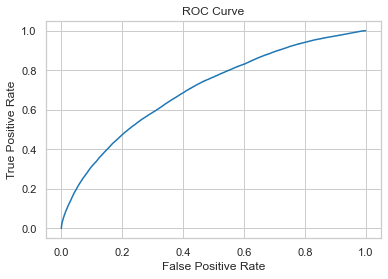

ROC AUC Score: 0.7014331068856066


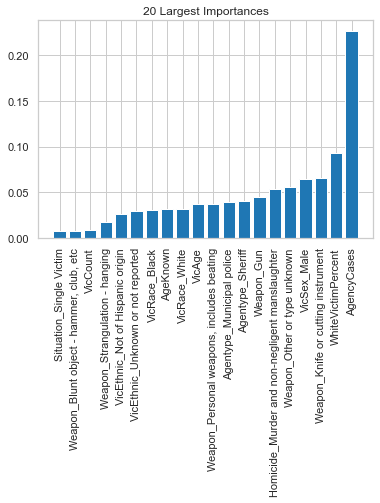

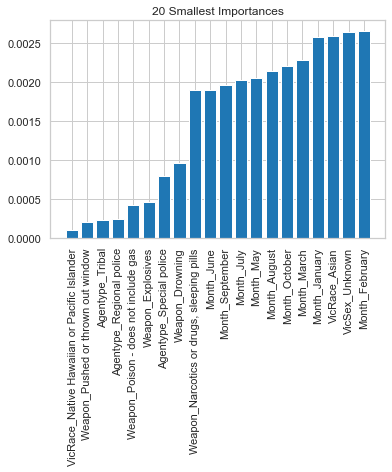

<ipython-input-54-b663c39b4905>:63: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  chart_df = proba_df.groupby('Bin')['Solved', 'Predicted Probability'].mean()


     Bin    Actual  Predicted  Count
0   0.05  0.000000   0.042557     15
1    0.1  0.028986   0.077177     69
2   0.15  0.132911   0.127404    158
3    0.2  0.236181   0.175787    199
4   0.25  0.260946   0.229776    571
5    0.3  0.410468   0.278372   7394
6   0.35  0.429525   0.332358  10933
7    0.4  0.539559   0.377412  18087
8   0.45  0.620662   0.424951  36598
9    0.5  0.700641   0.471976  25568
10  0.55  0.723818   0.525136  18553
11   0.6  0.778851   0.576038  20502
12  0.65  0.817738   0.624555  20668
13   0.7  0.866601   0.675032  20375
14  0.75  0.897293   0.721524  12005
15   0.8  0.927184   0.768413   5713
16  0.85  0.961877   0.822459   2046
17   0.9  0.969072   0.872830   1455
18  0.95  0.985240   0.912790    271
19     1       NaN        NaN      0


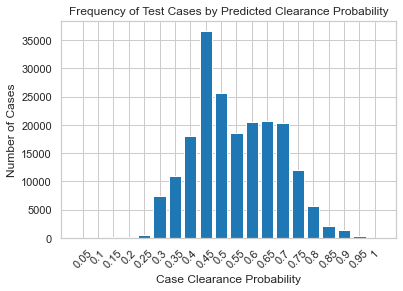

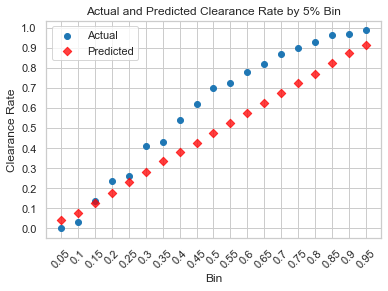

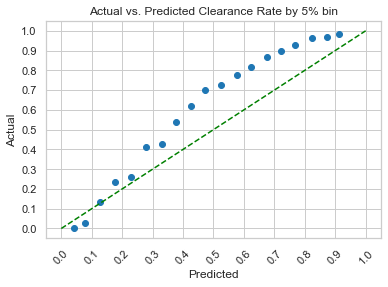

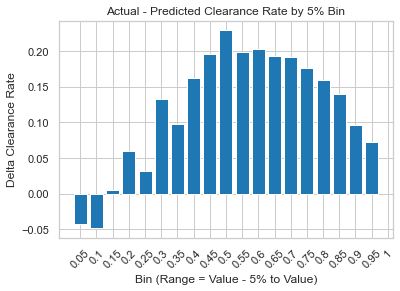

Sum of Squared Binned Residuals: 3972.3442695686394
Reporting Time: 2.5 seconds


<ipython-input-3-96a6dbac1e69>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bin_df = df.groupby('Bin')['Actual', 'Predicted Probability'].mean()


In [78]:
model  = ExtraTreesClassifier(random_state = 33,
                              class_weight = 'balanced',
                              n_estimators = 250,
                              max_depth = 15,
                              min_samples_split = 20)

train(model, X_train, y_train)
y_pred, y_pred_prob = predict(model, X_test)
proba_df, chart_df = reports(model, X_train.columns, y_test, y_pred, y_pred_prob)

Training Time: 251.2 seconds
Prediction Time: 20.2 seconds
Confusion Matrix:
 [[40862 18311]
 [54930 87077]]
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.69      0.53     59173
           1       0.83      0.61      0.70    142007

    accuracy                           0.64    201180
   macro avg       0.63      0.65      0.62    201180
weighted avg       0.71      0.64      0.65    201180

Accuracy: 63.59 %
Log Loss: 0.6208888935852747
Brier Score Loss: 0.21638680961348838


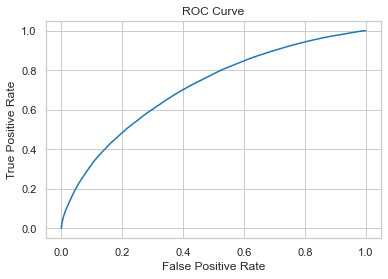

ROC AUC Score: 0.711165238277865


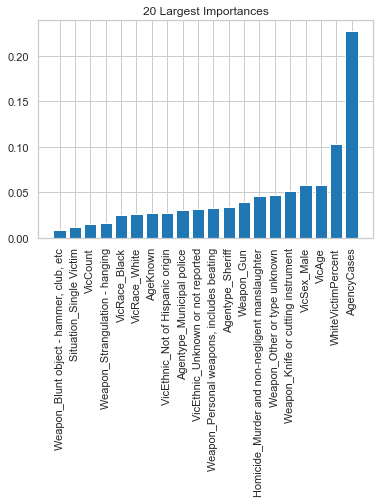

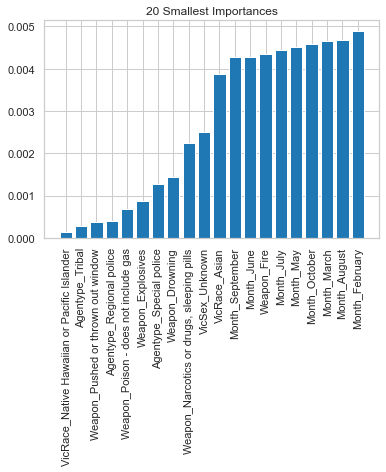

     Bin    Actual  Predicted  Count
0   0.05  0.000000   0.037205     35
1    0.1  0.090164   0.079774    122
2   0.15  0.176230   0.129294    244
3    0.2  0.282209   0.181305    652
4   0.25  0.384108   0.234689   4241
5    0.3  0.398550   0.273040   8275
6   0.35  0.471790   0.325803  11060
7    0.4  0.536979   0.379523  17902
8   0.45  0.627525   0.424907  30539
9    0.5  0.694041   0.474194  22722
10  0.55  0.732820   0.525243  18699
11   0.6  0.767662   0.575285  18047
12  0.65  0.810804   0.624437  18568
13   0.7  0.850634   0.675086  18217
14  0.75  0.884867   0.722145  15139
15   0.8  0.911313   0.773070   8919
16  0.85  0.945086   0.820435   4243
17   0.9  0.960900   0.873746   1867
18  0.95  0.969577   0.922276   1512
19     1  0.988701   0.957780    177


<ipython-input-54-b663c39b4905>:63: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  chart_df = proba_df.groupby('Bin')['Solved', 'Predicted Probability'].mean()


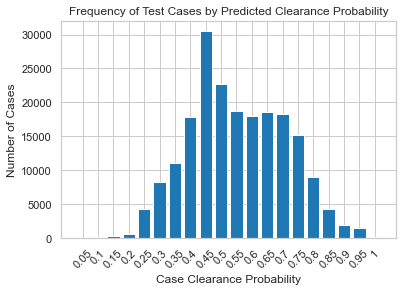

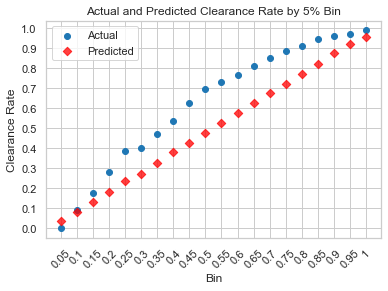

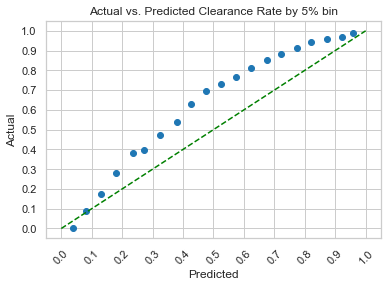

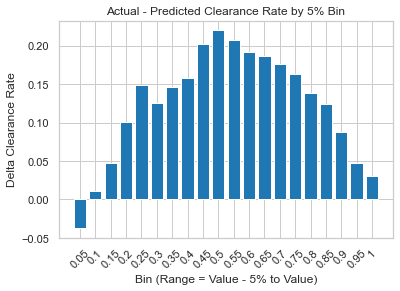

Sum of Squared Binned Residuals: 4050.0995980547123
Reporting Time: 1.9 seconds


<ipython-input-3-96a6dbac1e69>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bin_df = df.groupby('Bin')['Actual', 'Predicted Probability'].mean()


In [79]:
model  = ExtraTreesClassifier(random_state = 33,
                              class_weight = 'balanced',
                              n_estimators = 250,
                              max_depth = 20,
                              min_samples_split = 20)

train(model, X_train, y_train)
y_pred, y_pred_prob = predict(model, X_test)
proba_df, chart_df = reports(model, X_train.columns, y_test, y_pred, y_pred_prob)

Training Time: 285.3 seconds
Prediction Time: 24.2 seconds
Confusion Matrix:
 [[39967 19206]
 [51306 90701]]
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.68      0.53     59173
           1       0.83      0.64      0.72    142007

    accuracy                           0.65    201180
   macro avg       0.63      0.66      0.63    201180
weighted avg       0.71      0.65      0.66    201180

Accuracy: 64.95 %
Log Loss: 0.6121357247696536
Brier Score Loss: 0.21259634335215818


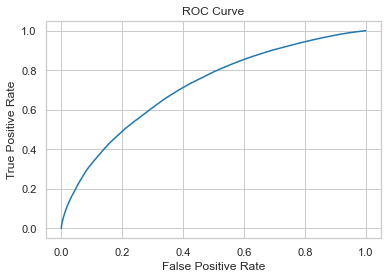

ROC AUC Score: 0.7164102827017833


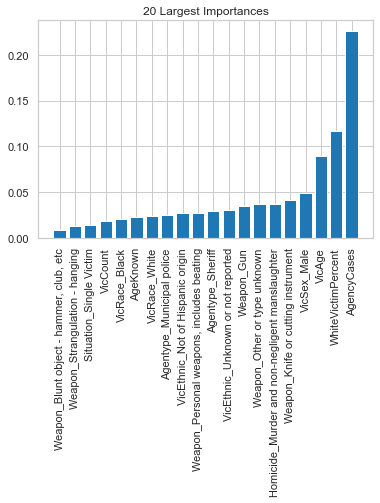

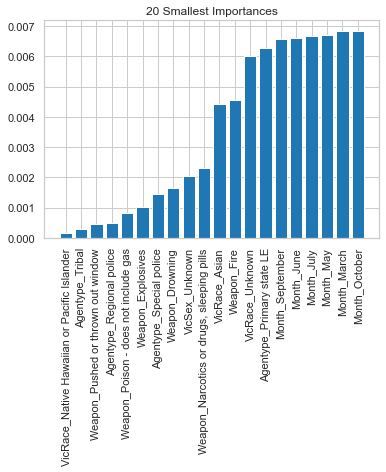

<ipython-input-54-b663c39b4905>:63: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  chart_df = proba_df.groupby('Bin')['Solved', 'Predicted Probability'].mean()


     Bin    Actual  Predicted  Count
0   0.05  0.034483   0.036900     58
1    0.1  0.117949   0.079729    195
2   0.15  0.268349   0.129996    436
3    0.2  0.323880   0.180632   1763
4   0.25  0.373724   0.228713   6759
5    0.3  0.435950   0.276580   7783
6   0.35  0.480754   0.325142  11509
7    0.4  0.541344   0.377624  17717
8   0.45  0.625754   0.425160  24190
9    0.5  0.690840   0.474541  20863
10  0.55  0.733424   0.523878  18400
11   0.6  0.760707   0.574969  17301
12  0.65  0.802306   0.625386  17608
13   0.7  0.836315   0.674831  16599
14  0.75  0.870701   0.724543  16226
15   0.8  0.898679   0.773400  10827
16  0.85  0.927305   0.822279   6768
17   0.9  0.943568   0.872075   3296
18  0.95  0.964303   0.923851   2073
19     1  0.980222   0.963701    809


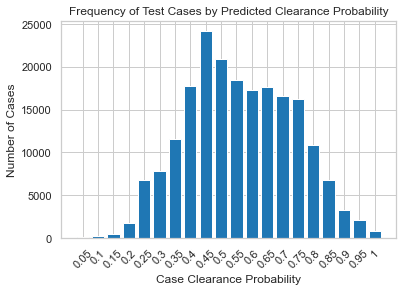

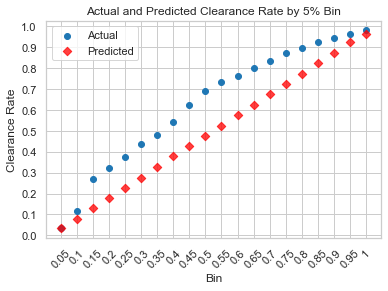

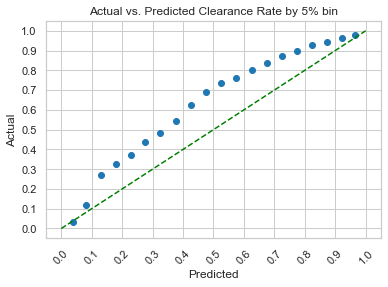

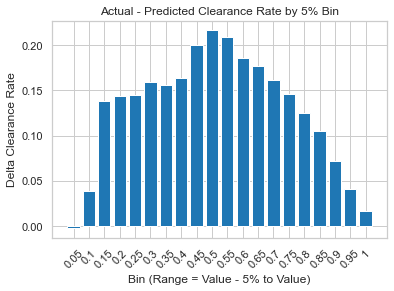

Sum of Squared Binned Residuals: 4164.917973688161
Reporting Time: 2.0 seconds


<ipython-input-3-96a6dbac1e69>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bin_df = df.groupby('Bin')['Actual', 'Predicted Probability'].mean()


In [80]:
model  = ExtraTreesClassifier(random_state = 33,
                              class_weight = 'balanced',
                              n_estimators = 250,
                              max_depth = 25,
                              min_samples_split = 20)

train(model, X_train, y_train)
y_pred, y_pred_prob = predict(model, X_test)
proba_df, chart_df = reports(model, X_train.columns, y_test, y_pred, y_pred_prob)

Training Time: 305.8 seconds
Prediction Time: 27.4 seconds
Confusion Matrix:
 [[38480 20693]
 [46842 95165]]
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.65      0.53     59173
           1       0.82      0.67      0.74    142007

    accuracy                           0.66    201180
   macro avg       0.64      0.66      0.64    201180
weighted avg       0.71      0.66      0.68    201180

Accuracy: 66.43 %
Log Loss: 0.6063527584820003
Brier Score Loss: 0.20994625404168535


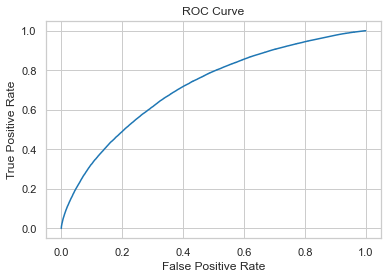

ROC AUC Score: 0.7175194164574238


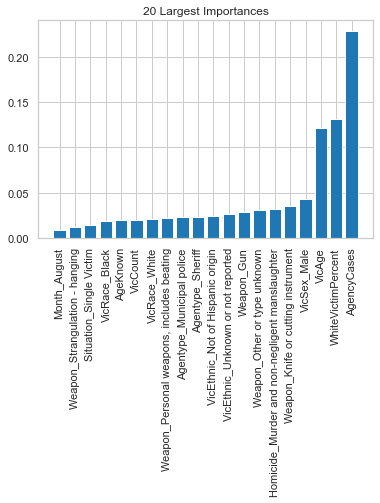

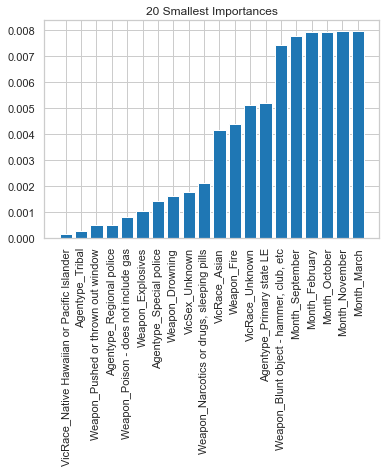

     Bin    Actual  Predicted  Count
0   0.05  0.078652   0.034753     89
1    0.1  0.164751   0.080364    261
2   0.15  0.295474   0.131236   1171
3    0.2  0.345794   0.178509   3745
4   0.25  0.406949   0.226343   6217
5    0.3  0.451557   0.276420   9217
6   0.35  0.486201   0.325736  12320
7    0.4  0.559560   0.376110  15094
8   0.45  0.614369   0.425239  18707
9    0.5  0.677261   0.474807  18501
10  0.55  0.728510   0.524844  19032
11   0.6  0.761184   0.574637  17235
12  0.65  0.789982   0.624998  16889
13   0.7  0.822230   0.674631  16302
14  0.75  0.860107   0.724822  15955
15   0.8  0.885458   0.773562  12502
16  0.85  0.908608   0.822730   8655
17   0.9  0.933438   0.872648   5093
18  0.95  0.950265   0.923050   2835
19     1  0.977941   0.969015   1360


<ipython-input-54-b663c39b4905>:63: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  chart_df = proba_df.groupby('Bin')['Solved', 'Predicted Probability'].mean()


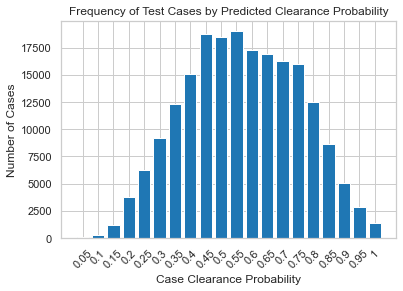

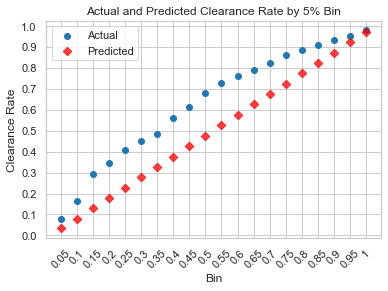

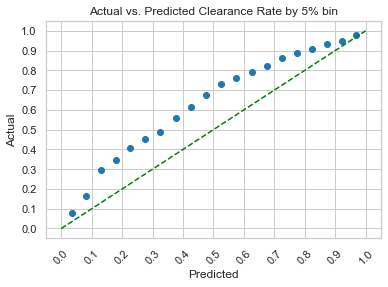

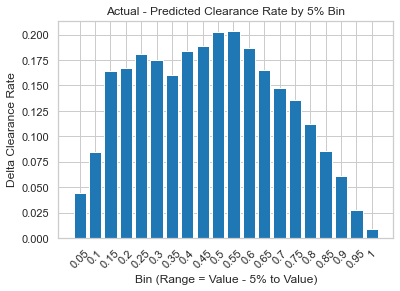

Sum of Squared Binned Residuals: 4314.577698987837
Reporting Time: 2.0 seconds


<ipython-input-3-96a6dbac1e69>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bin_df = df.groupby('Bin')['Actual', 'Predicted Probability'].mean()


In [81]:
model  = ExtraTreesClassifier(random_state = 33,
                              class_weight = 'balanced',
                              n_estimators = 250,
                              max_depth = 30,
                              min_samples_split = 20)

train(model, X_train, y_train)
y_pred, y_pred_prob = predict(model, X_test)
proba_df, chart_df = reports(model, X_train.columns, y_test, y_pred, y_pred_prob)

In [67]:
model  = ExtraTreesClassifier(random_state = 33)

grid = [{'n_estimators' : [25, 50, 100, 250, 500]
        }]

grid_results = grid_search(grid, model, X_train, y_train, folds = 3)
grid_results

Fitting 3 folds for each of 5 candidates, totalling 15 fits


C:\Users\Work_Remote\anaconda3\envs\Murder Project\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.67285888 0.67353177 0.67399176 0.67388753        nan]
  warnings.warn(
C:\Users\Work_Remote\anaconda3\envs\Murder Project\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.68592864 0.68646382 0.68771809 0.68809421        nan]
  warnings.warn(
C:\Users\Work_Remote\anaconda3\envs\Murder Project\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.63797461 0.6385742  0.63861167 0.63831826        nan]
  warnings.warn(
C:\Users\Work_Remote\anaconda3\envs\Murder Project\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.67810511 0.67872931 0.67939631 0.67941618        nan]
  warnings.warn(
C:\Users\Work_Remote\anacond

Grid Search Time: 912.0 seconds


BSSR Rank    BSSR Mean    BSSR Std  ROC_AUC Rank  \
{'n_estimators': 25}           4 -9506.006513  113.018211             4   
{'n_estimators': 50}           3 -9260.565658   66.499575             2   
{'n_estimators': 100}          1 -9131.919493   61.408143             1   
{'n_estimators': 250}          2 -9158.066371   54.875868             3   
{'n_estimators': 500}          5          NaN         NaN             5   

                       ROC_AUC Mean  ROC_AUC Std  Precision Rank  \
{'n_estimators': 25}       0.637975     0.000530               4   
{'n_estimators': 50}       0.638574     0.000639               3   
{'n_estimators': 100}      0.638612     0.000686               1   
{'n_estimators': 250}      0.638318     0.000733               2   
{'n_estimators': 500}           NaN          NaN               5   

                       Precision Mean  Precision Std  Recall Rank  \
{'n_estimators': 25}         0.672859       0.000178            4   
{'n_estimators': 50}         0.673532       0.000132            3   
{'n_estimators': 100}        0.673992       0.000181            2   
{'n_estimators': 250}        0.673888       0.000094            1   
{'n_estimators': 500}             NaN            NaN            5   

                       Recall Mean  Recall Std  Accuracy Rank  Accuracy Mean  \
{'n_estimators': 25}      0.685929    0.000150              4       0.685929   
{'n_estimators': 50}      0.686464    0.000220              3       0.686464   
{'n_estimators': 100}     0.687718    0.000357              2       0.687718   
{'n_estimators': 250}     0.688094    0.000314              1       0.688094   
{'n_estimators': 500}          NaN         NaN              5            NaN   

                       Accuracy Std  F1 Rank   F1 Mean    F1 Std  \
{'n_estimators': 25}       0.000150        4  0.678105  0.000096   
{'n_estimators': 50}       0.000220        3  0.678729  0.000120   
{'n_estimators': 100}      0.000357        2  0.679396  0.000215   
{'n_estimators': 250}      0.000314        1  0.679416  0.000147   
{'n_estimators': 500}           NaN        5       NaN       NaN   

                       Proba30 Rank  Proba30 Mean  Proba30 Std  
{'n_estimators': 25}              2      0.013092     0.000097  
{'n_estimators': 50}              4      0.012450     0.000141  
{'n_estimators': 100}             3      0.012738     0.000099  
{'n_estimators': 250}             1      0.013105     0.000186  
{'n_estimators': 500}             5           NaN          NaN

In [82]:
model  = ExtraTreesClassifier(random_state = 33)

grid = [{'n_estimators' : [500]
        }]

grid_results = grid_search(grid, model, X_train, y_train, folds = 3)
grid_results

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Grid Search Time: 1436.8 seconds


BSSR Rank    BSSR Mean   BSSR Std  ROC_AUC Rank  \
{'n_estimators': 500}          1 -9138.734554  32.771916             1   

                       ROC_AUC Mean  ROC_AUC Std  Precision Rank  \
{'n_estimators': 500}      0.638137     0.000843               1   

                       Precision Mean  Precision Std  Recall Rank  \
{'n_estimators': 500}        0.674111       0.000036            1   

                       Recall Mean  Recall Std  Accuracy Rank  Accuracy Mean  \
{'n_estimators': 500}     0.688508    0.000294              1       0.688508   

                       Accuracy Std  F1 Rank   F1 Mean    F1 Std  \
{'n_estimators': 500}      0.000294        1  0.679682  0.000097   

                       Proba30 Rank  Proba30 Mean  Proba30 Std  
{'n_estimators': 500}             1      0.013151     0.000202

In [83]:
model  = ExtraTreesClassifier(random_state = 33,
                              n_estimators = 250)

grid = [{'max_depth' : [10, 15, 20, 25, 30]
        }]

grid_results = grid_search(grid, model, X_train, y_train, folds = 3)
grid_results

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Grid Search Time: 642.2 seconds


BSSR Rank    BSSR Mean    BSSR Std  ROC_AUC Rank  \
{'max_depth': 10}          4 -2470.401566  164.301644             5   
{'max_depth': 15}          2  -815.507728   60.509608             3   
{'max_depth': 20}          1  -213.744070   20.519595             1   
{'max_depth': 25}          3 -1332.733544  100.402108             2   
{'max_depth': 30}          5 -4301.295142   77.585261             4   

                   ROC_AUC Mean  ROC_AUC Std  Precision Rank  Precision Mean  \
{'max_depth': 10}      0.686447     0.001814               1        0.711477   
{'max_depth': 15}      0.699770     0.001704               4        0.689603   
{'max_depth': 20}      0.707930     0.001466               2        0.695876   
{'max_depth': 25}      0.703901     0.001360               3        0.689795   
{'max_depth': 30}      0.687692     0.001165               5        0.683661   

                   Precision Std  Recall Rank  Recall Mean  Recall Std  \
{'max_depth': 10}       0.009094            5     0.708699    0.000354   
{'max_depth': 15}       0.001288            3     0.715985    0.000394   
{'max_depth': 20}       0.000403            1     0.722438    0.000287   
{'max_depth': 25}       0.000816            2     0.721161    0.000476   
{'max_depth': 30}       0.000088            4     0.714054    0.000178   

                   Accuracy Rank  Accuracy Mean  Accuracy Std  F1 Rank  \
{'max_depth': 10}              5       0.708699      0.000354        5   
{'max_depth': 15}              3       0.715985      0.000394        4   
{'max_depth': 20}              1       0.722438      0.000287        3   
{'max_depth': 25}              2       0.721161      0.000476        2   
{'max_depth': 30}              4       0.714054      0.000178        1   

                    F1 Mean    F1 Std  Proba30 Rank  Proba30 Mean  Proba30 Std  
{'max_depth': 10}  0.594207  0.002046             5      0.000145     0.000008  
{'max_depth': 15}  0.632246  0.000827             4      0.000353     0.000013  
{'max_depth': 20}  0.658767  0.000935             3      0.001029     0.000067  
{'max_depth': 25}  0.673649  0.000072             2      0.003562     0.000116  
{'max_depth': 30}  0.683630  0.000151             1      0.008540     0.000161

In [84]:
model  = ExtraTreesClassifier(random_state = 33,
                              n_estimators = 250,
                              max_depth = 20)

grid = [{'min_samples_split' : [1, 2, 5, 10, 20]
        }]

grid_results = grid_search(grid, model, X_train, y_train, folds = 3)
grid_results

Fitting 3 folds for each of 5 candidates, totalling 15 fits


C:\Users\Work_Remote\anaconda3\envs\Murder Project\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.69587631 0.69757703 0.69727003 0.69696916]
  warnings.warn(
C:\Users\Work_Remote\anaconda3\envs\Murder Project\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.72243836 0.72284264 0.72263553 0.72212355]
  warnings.warn(
C:\Users\Work_Remote\anaconda3\envs\Murder Project\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.70793009 0.70836025 0.70813479 0.70742788]
  warnings.warn(
C:\Users\Work_Remote\anaconda3\envs\Murder Project\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.65876721 0.65785869 0.65726252 0.65495515]
  warnings.warn(
C:\Users\Work_Remote\anacond

Grid Search Time: 566.1 seconds


BSSR Rank   BSSR Mean   BSSR Std  ROC_AUC Rank  \
{'min_samples_split': 1}           5         NaN        NaN             5   
{'min_samples_split': 2}           2 -213.744070  20.519595             3   
{'min_samples_split': 5}           1 -189.444619  19.401876             1   
{'min_samples_split': 10}          3 -243.052944  29.985561             2   
{'min_samples_split': 20}          4 -422.847660  36.847110             4   

                           ROC_AUC Mean  ROC_AUC Std  Precision Rank  \
{'min_samples_split': 1}            NaN          NaN               5   
{'min_samples_split': 2}       0.707930     0.001466               4   
{'min_samples_split': 5}       0.708360     0.001489               1   
{'min_samples_split': 10}      0.708135     0.001240               2   
{'min_samples_split': 20}      0.707428     0.001712               3   

                           Precision Mean  Precision Std  Recall Rank  \
{'min_samples_split': 1}              NaN            NaN            5   
{'min_samples_split': 2}         0.695876       0.000403            3   
{'min_samples_split': 5}         0.697577       0.000410            1   
{'min_samples_split': 10}        0.697270       0.000318            2   
{'min_samples_split': 20}        0.696969       0.000690            4   

                           Recall Mean  Recall Std  Accuracy Rank  \
{'min_samples_split': 1}           NaN         NaN              5   
{'min_samples_split': 2}      0.722438    0.000287              3   
{'min_samples_split': 5}      0.722843    0.000287              1   
{'min_samples_split': 10}     0.722636    0.000120              2   
{'min_samples_split': 20}     0.722124    0.000472              4   

                           Accuracy Mean  Accuracy Std  F1 Rank   F1 Mean  \
{'min_samples_split': 1}             NaN           NaN        5       NaN   
{'min_samples_split': 2}        0.722438      0.000287        1  0.658767   
{'min_samples_split': 5}        0.722843      0.000287        2  0.657859   
{'min_samples_split': 10}       0.722636      0.000120        3  0.657263   
{'min_samples_split': 20}       0.722124      0.000472        4  0.654955   

                             F1 Std  Proba30 Rank  Proba30 Mean  Proba30 Std  
{'min_samples_split': 1}        NaN             5           NaN          NaN  
{'min_samples_split': 2}   0.000935             1      0.001029     0.000067  
{'min_samples_split': 5}   0.001137             2      0.000844     0.000044  
{'min_samples_split': 10}  0.000713             3      0.000712     0.000035  
{'min_samples_split': 20}  0.001427             4      0.000579     0.000024

In [85]:
model  = ExtraTreesClassifier(random_state = 33,
                              n_estimators = 250,
                              max_depth = 20)

grid = [{'min_samples_split' : [3, 4]
        }]

grid_results = grid_search(grid, model, X_train, y_train, folds = 3)
grid_results

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Grid Search Time: 269.8 seconds


BSSR Rank   BSSR Mean   BSSR Std  ROC_AUC Rank  \
{'min_samples_split': 3}          2 -178.454403  11.331255             2   
{'min_samples_split': 4}          1 -165.545489  28.441430             1   

                          ROC_AUC Mean  ROC_AUC Std  Precision Rank  \
{'min_samples_split': 3}      0.708324     0.001276               1   
{'min_samples_split': 4}      0.708457     0.001438               2   

                          Precision Mean  Precision Std  Recall Rank  \
{'min_samples_split': 3}        0.697449       0.000208            1   
{'min_samples_split': 4}        0.697340       0.000138            2   

                          Recall Mean  Recall Std  Accuracy Rank  \
{'min_samples_split': 3}     0.722930    0.000164              1   
{'min_samples_split': 4}     0.722921    0.000091              2   

                          Accuracy Mean  Accuracy Std  F1 Rank   F1 Mean  \
{'min_samples_split': 3}       0.722930      0.000164        2  0.658575   
{'min_samples_split': 4}       0.722921      0.000091        1  0.658728   

                            F1 Std  Proba30 Rank  Proba30 Mean  Proba30 Std  
{'min_samples_split': 3}  0.000639             1      0.000954     0.000058  
{'min_samples_split': 4}  0.000681             2      0.000876     0.000048

Training Time: 238.3 seconds
Prediction Time: 20.7 seconds
Confusion Matrix:
 [[  8875  50298]
 [  5560 136447]]
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.15      0.24     59173
           1       0.73      0.96      0.83    142007

    accuracy                           0.72    201180
   macro avg       0.67      0.56      0.54    201180
weighted avg       0.70      0.72      0.66    201180

Accuracy: 72.23 %
Log Loss: 0.5474788767093726
Brier Score Loss: 0.1842044050336915


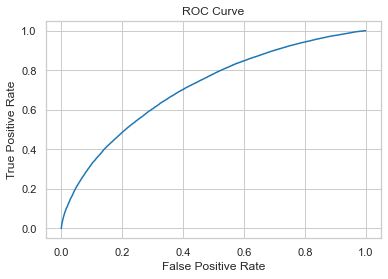

ROC AUC Score: 0.7119699045784175


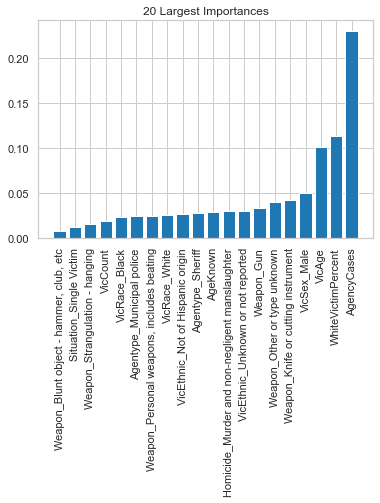

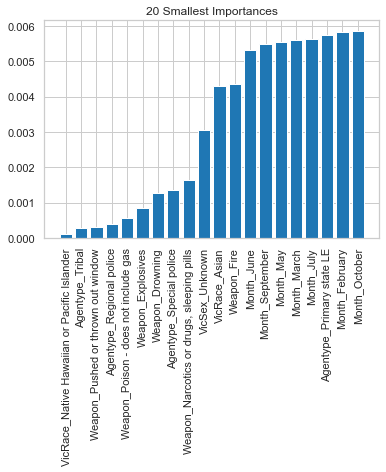

     Bin    Actual  Predicted  Count
0   0.05  0.021277   0.031023     47
1    0.1  0.031250   0.076865     64
2   0.15  0.161616   0.124572     99
3    0.2  0.163934   0.178205    122
4   0.25  0.242105   0.225631    190
5    0.3  0.236842   0.276373    304
6   0.35  0.296992   0.327923    532
7    0.4  0.344194   0.378322   1197
8   0.45  0.397251   0.432943   4584
9    0.5  0.412829   0.473012   7296
10  0.55  0.465316   0.529272   9572
11   0.6  0.534587   0.579434  13560
12  0.65  0.612352   0.626401  32158
13   0.7  0.688040   0.673924  27106
14  0.75  0.739499   0.725130  23021
15   0.8  0.789223   0.775985  25017
16  0.85  0.845110   0.825500  26464
17   0.9  0.898000   0.871358  21049
18  0.95  0.946863   0.918956   7189
19     1  0.969546   0.962246   1609


<ipython-input-54-b663c39b4905>:63: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  chart_df = proba_df.groupby('Bin')['Solved', 'Predicted Probability'].mean()


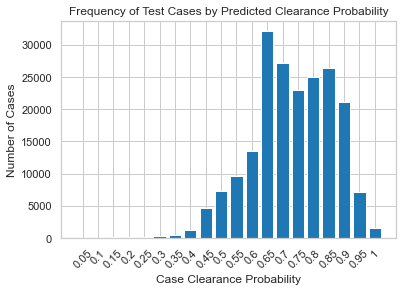

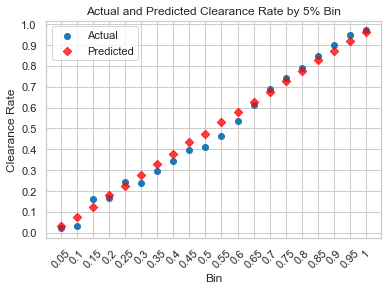

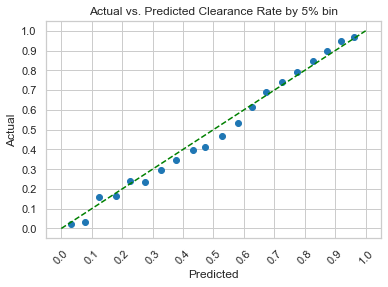

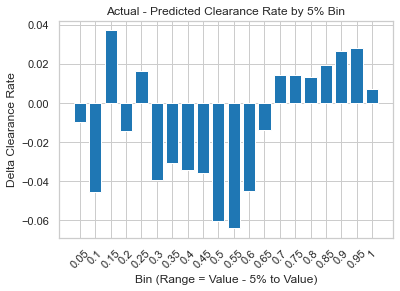

Sum of Squared Binned Residuals: 214.09469717218715
Reporting Time: 2.2 seconds


<ipython-input-3-96a6dbac1e69>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bin_df = df.groupby('Bin')['Actual', 'Predicted Probability'].mean()


In [86]:
model  = ExtraTreesClassifier(random_state = 33,
                              n_estimators = 250,
                              max_depth = 20,
                              min_samples_split = 3)

train(model, X_train, y_train)
y_pred, y_pred_prob = predict(model, X_test)
proba_df, chart_df = reports(model, X_train.columns, y_test, y_pred, y_pred_prob)

Training Time: 475.8 seconds
Prediction Time: 42.3 seconds
Confusion Matrix:
 [[  9000  50173]
 [  5570 136437]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.15      0.24     59173
           1       0.73      0.96      0.83    142007

    accuracy                           0.72    201180
   macro avg       0.67      0.56      0.54    201180
weighted avg       0.70      0.72      0.66    201180

Accuracy: 72.29 %
Log Loss: 0.5472309584296469
Brier Score Loss: 0.1840935656633618


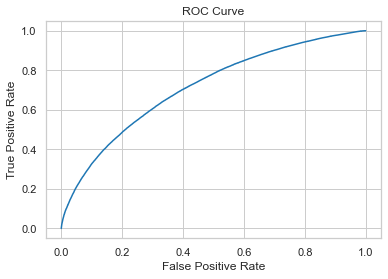

ROC AUC Score: 0.7124484904371269


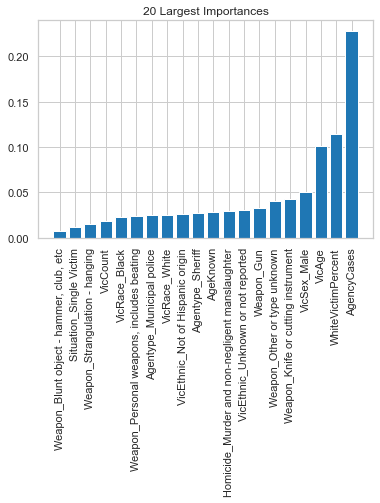

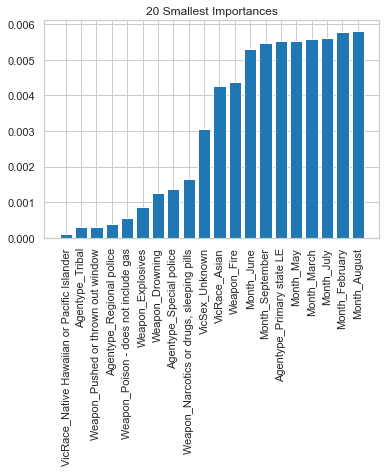

     Bin    Actual  Predicted  Count
0   0.05  0.021277   0.031182     47
1    0.1  0.032787   0.076128     61
2   0.15  0.141509   0.126935    106
3    0.2  0.166667   0.178010    120
4   0.25  0.232804   0.224233    189
5    0.3  0.244373   0.277062    311
6   0.35  0.298113   0.327988    530
7    0.4  0.343980   0.378186   1221
8   0.45  0.389438   0.433194   4753
9    0.5  0.412472   0.473289   7232
10  0.55  0.470836   0.529357   9481
11   0.6  0.529947   0.579082  13858
12  0.65  0.613830   0.626256  31758
13   0.7  0.688886   0.673881  27003
14  0.75  0.738101   0.724905  22818
15   0.8  0.789095   0.775991  24888
16  0.85  0.845272   0.825263  26944
17   0.9  0.898391   0.871335  21071
18  0.95  0.945116   0.919026   7197
19     1  0.970477   0.961809   1592


<ipython-input-54-b663c39b4905>:63: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  chart_df = proba_df.groupby('Bin')['Solved', 'Predicted Probability'].mean()


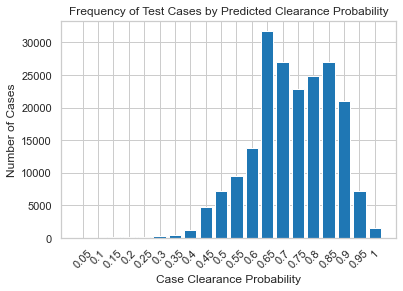

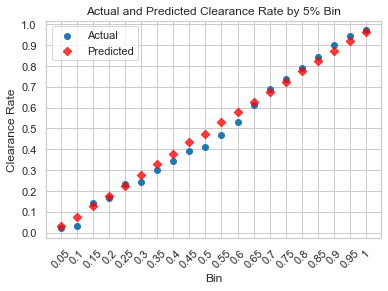

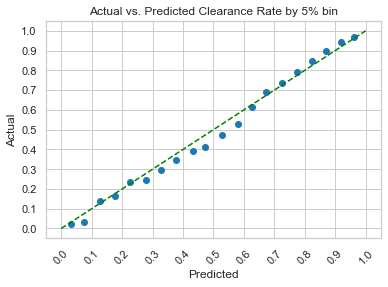

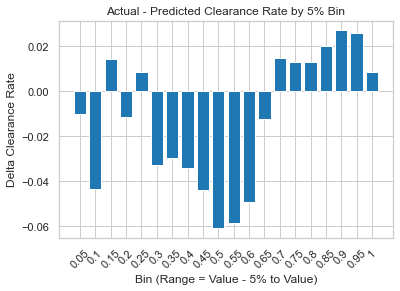

Sum of Squared Binned Residuals: 195.88009806817982
Reporting Time: 2.1 seconds


<ipython-input-3-96a6dbac1e69>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bin_df = df.groupby('Bin')['Actual', 'Predicted Probability'].mean()


In [87]:
model  = ExtraTreesClassifier(random_state = 33,
                              n_estimators = 500,
                              max_depth = 20,
                              min_samples_split = 3)

train(model, X_train, y_train)
y_pred, y_pred_prob = predict(model, X_test)
proba_df, chart_df = reports(model, X_train.columns, y_test, y_pred, y_pred_prob)

Training Time: 950.2 seconds
Prediction Time: 82.7 seconds
Confusion Matrix:
 [[  8978  50195]
 [  5554 136453]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.15      0.24     59173
           1       0.73      0.96      0.83    142007

    accuracy                           0.72    201180
   macro avg       0.67      0.56      0.54    201180
weighted avg       0.70      0.72      0.66    201180

Accuracy: 72.29 %
Log Loss: 0.5472939156597785
Brier Score Loss: 0.18412104339663177


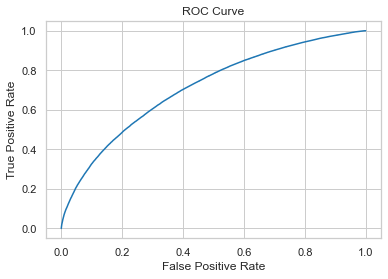

ROC AUC Score: 0.712311016889529


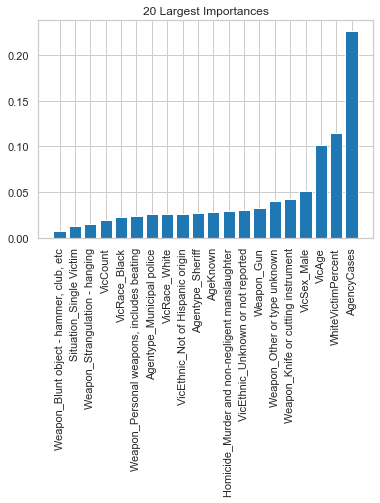

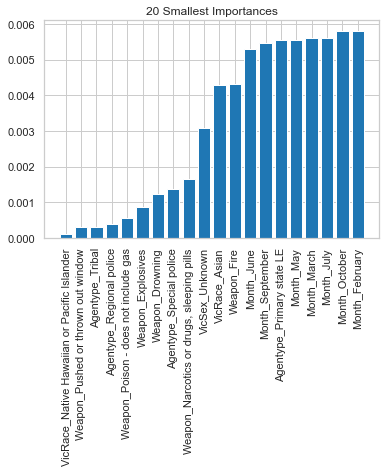

<ipython-input-54-b663c39b4905>:63: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  chart_df = proba_df.groupby('Bin')['Solved', 'Predicted Probability'].mean()


     Bin    Actual  Predicted  Count
0   0.05  0.022222   0.031472     45
1    0.1  0.032258   0.075430     62
2   0.15  0.132075   0.127068    106
3    0.2  0.174242   0.179092    132
4   0.25  0.219780   0.226799    182
5    0.3  0.243421   0.276976    304
6   0.35  0.313093   0.327626    527
7    0.4  0.334171   0.377622   1194
8   0.45  0.390466   0.433144   4615
9    0.5  0.411948   0.473106   7365
10  0.55  0.470675   0.529726   9480
11   0.6  0.530044   0.579093  13963
12  0.65  0.614033   0.626312  31697
13   0.7  0.689433   0.673637  27160
14  0.75  0.738443   0.725023  22649
15   0.8  0.787504   0.776133  25017
16  0.85  0.846603   0.825457  26878
17   0.9  0.898128   0.871274  21046
18  0.95  0.944989   0.918986   7144
19     1  0.971499   0.961939   1614


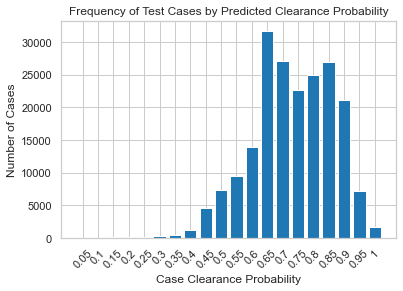

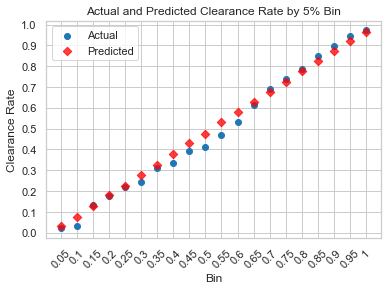

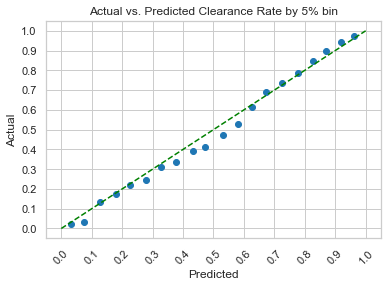

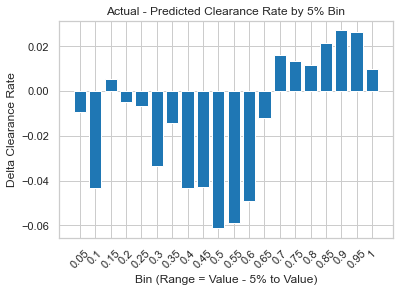

Sum of Squared Binned Residuals: 193.72327364144434
Reporting Time: 2.2 seconds


<ipython-input-3-96a6dbac1e69>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bin_df = df.groupby('Bin')['Actual', 'Predicted Probability'].mean()


In [89]:
model  = ExtraTreesClassifier(random_state = 33,
                              n_estimators = 1000,
                              max_depth = 20,
                              min_samples_split = 3)

train(model, X_train, y_train)
y_pred, y_pred_prob = predict(model, X_test)
proba_df, chart_df = reports(model, X_train.columns, y_test, y_pred, y_pred_prob)

Training Time: 1185.5 seconds
Prediction Time: 103.2 seconds
Confusion Matrix:
 [[  9010  50163]
 [  5568 136439]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.15      0.24     59173
           1       0.73      0.96      0.83    142007

    accuracy                           0.72    201180
   macro avg       0.67      0.56      0.54    201180
weighted avg       0.70      0.72      0.66    201180

Accuracy: 72.3 %
Log Loss: 0.5472753972767911
Brier Score Loss: 0.18411517748268982


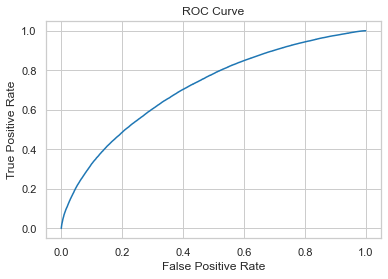

ROC AUC Score: 0.7123216640049278


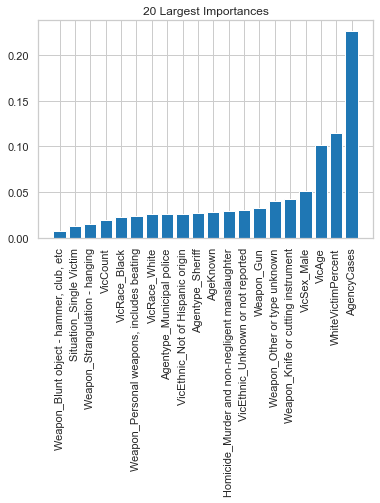

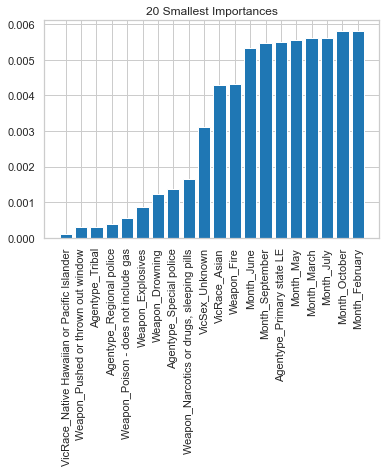

<ipython-input-54-b663c39b4905>:63: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  chart_df = proba_df.groupby('Bin')['Solved', 'Predicted Probability'].mean()


     Bin    Actual  Predicted  Count
0   0.05  0.022222   0.031753     45
1    0.1  0.032258   0.075448     62
2   0.15  0.145631   0.126906    103
3    0.2  0.146154   0.177761    130
4   0.25  0.240838   0.226066    191
5    0.3  0.235099   0.277190    302
6   0.35  0.311321   0.327550    530
7    0.4  0.331954   0.377644   1208
8   0.45  0.391485   0.433246   4580
9    0.5  0.411337   0.472992   7427
10  0.55  0.470962   0.529491   9453
11   0.6  0.529556   0.578997  13821
12  0.65  0.614126   0.626323  31785
13   0.7  0.689798   0.673624  27221
14  0.75  0.737692   0.724947  22607
15   0.8  0.788209   0.776152  25053
16  0.85  0.845828   0.825464  26879
17   0.9  0.898383   0.871253  20971
18  0.95  0.945173   0.918935   7168
19     1  0.971411   0.961959   1644


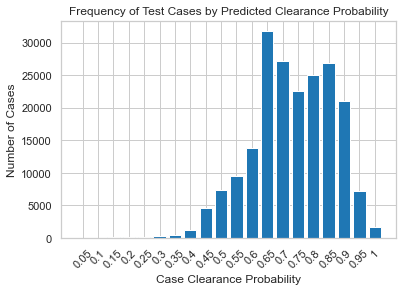

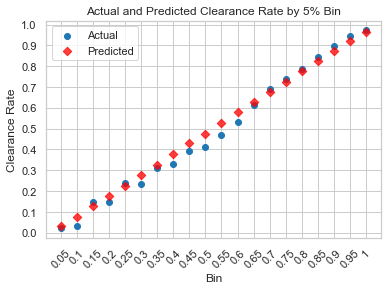

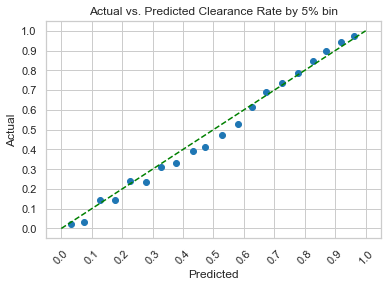

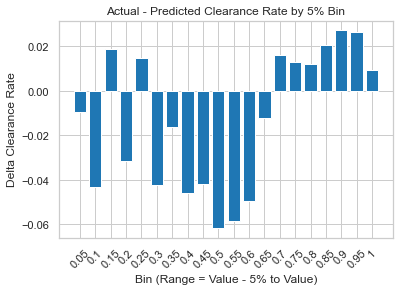

Sum of Squared Binned Residuals: 217.088027795853
Reporting Time: 2.3 seconds


<ipython-input-3-96a6dbac1e69>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bin_df = df.groupby('Bin')['Actual', 'Predicted Probability'].mean()


In [90]:
model  = ExtraTreesClassifier(random_state = 33,
                              n_estimators = 1250,
                              max_depth = 20,
                              min_samples_split = 3)

train(model, X_train, y_train)
y_pred, y_pred_prob = predict(model, X_test)
proba_df, chart_df = reports(model, X_train.columns, y_test, y_pred, y_pred_prob)

starting with model from last set that had best sum of squares results

In [55]:
model  = RandomForestClassifier(n_estimators = 1000,
                                max_depth = 20,
                                min_samples_leaf = 1,
                                n_jobs = 11)
rfc_calibrated_cv_scores = CrossVal(model, X_train, y_train, scoring = bssr, folds = 5)

Mean Score: nan
Score Standard Deviation nan
Scores: [nan nan nan nan nan]
Cross Validation Time: 4.3 seconds


In [56]:
model  = LogisticRegression()
lr_base_cv_scores = CrossVal(model, X_train, y_train, scoring = bssr, folds = 5)

Mean Score: nan
Score Standard Deviation nan
Scores: [nan nan nan nan nan]
Cross Validation Time: 4.4 seconds


In [99]:
print(rfc_calibrated_cv_scores.shape)

(50,)


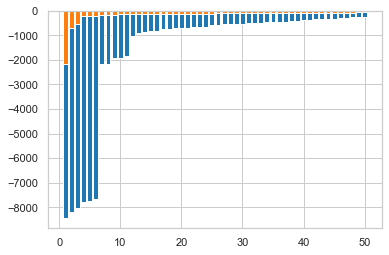

In [102]:
plt.bar(np.arange(1, 51, 1), lr_base_cv_scores)
plt.bar(np.arange(1, 51, 1), rfc_calibrated_cv_scores)
plt.show()

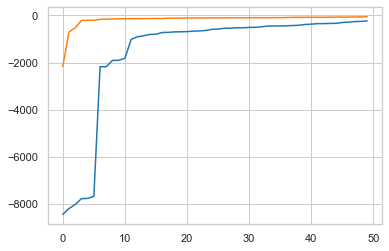

In [103]:
plt.plot(lr_base_cv_scores)
plt.plot(rfc_calibrated_cv_scores)
plt.show()

Training on Unbalanced and Testing on Balanced Datasets:

Creating a balanced version of the originally unbalanced validation set:

In [30]:
y_validation.Solved.value_counts()

1    55038
0    22203
Name: Solved, dtype: int64

In [38]:
solved_count, unsolved_count = y_validation.Solved.value_counts()
y_solved = y_validation.Solved == 1
y_unsolved = y_validation.Solved == 0

balanced = pd.concat([y_validation[y_solved].sample(unsolved_count, random_state = 1), 
                      y_validation[y_unsolved]], axis = 0)
balanced = balanced.join(X_validation)
y_validation_balanced = pd.DataFrame(balanced.Solved)
X_validation_balanced = balanced.drop('Solved', axis = 1)

y_validation_balanced.Solved.value_counts()

1    22203
0    22203
Name: Solved, dtype: int64

In [39]:
y_pred, y_pred_prob = predict(model, X_validation_balanced)

Prediction Time: 14.4 seconds
